In [590]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer, LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
import statsmodels.api as sm
from sklearn.svm import SVR
import time

from __future__ import annotations
from typing import Iterable, Optional, List, Dict, Tuple
from sklearn.base import BaseEstimator, TransformerMixin

In [589]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

def _patch_ct(ct: ColumnTransformer):
    try:
        params = ct.get_params(deep=False)
        if "force_int_remainder_cols" in params:
            val = params["force_int_remainder_cols"]
            if val == "deprecated" or not isinstance(val, (bool,)):
                ct.set_params(force_int_remainder_cols=False)
    except Exception:
        if hasattr(ct, "__dict__") and "force_int_remainder_cols" in ct.__dict__:
            del ct.__dict__["force_int_remainder_cols"]

def patch_sklearn_objects(obj):
    if isinstance(obj, ColumnTransformer):
        _patch_ct(obj)
        for _, trans, _ in getattr(obj, "transformers", []):
            if isinstance(trans, (Pipeline, ColumnTransformer)):
                patch_sklearn_objects(trans)
        return obj

    if isinstance(obj, Pipeline):
        for _, step in obj.steps:
            if isinstance(step, (Pipeline, ColumnTransformer)):
                patch_sklearn_objects(step)
        return obj

    for attr in ("named_steps", "_final_estimator"):
        if hasattr(obj, attr):
            sub = getattr(obj, attr)
            try:
                patch_sklearn_objects(sub)
            except Exception:
                pass
    return obj

In [2]:
Ames_original = pd.read_csv('Ames_HousePrice.csv', index_col=0)

Ames = Ames_original.copy()

In [178]:
# Targeted Feature Engineering
Ames["GrLivArea_per_LotArea"] = Ames["GrLivArea"] / (Ames["LotArea"] + 1)
Ames["TotalSF"] = Ames["GrLivArea"] + Ames["TotalBsmtSF"]
Ames["HouseAge"] = Ames["YrSold"].astype(int) - Ames["YearBuilt"].astype(int)
Ames["HouseAgeSinceRemod"] = Ames["YrSold"].astype(int) - Ames["YearRemodAdd"].astype(int)
Ames["WasRemodeled"] = Ames['YearRemodAdd'] > Ames["YearBuilt"].astype(int)

bath_cols = ["FullBath", "HalfBath", "BsmtFullBath", "BsmtHalfBath"]
Ames[bath_cols] = Ames[bath_cols].fillna(0)
# initialize only if not already set
try:
    half_weight
except NameError:
    half_weight = 0.5

try:
    b_weight
except NameError:
    b_weight = 1.0

try:
    b_weight_half
except NameError:
    b_weight_half = 0.5


Ames['TotalBaths'] = Ames['FullBath'] + half_weight * Ames['HalfBath'] + b_weight * Ames['BsmtFullBath'] + b_weight_half * Ames['BsmtHalfBath']

garage_cols = ['GarageArea', 'GarageCars']
Ames[garage_cols] = Ames[garage_cols].fillna(0)

basement_cols = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']
Ames[basement_cols] = Ames[basement_cols].fillna(0)

Ames['MasVnrArea'] = Ames['MasVnrArea'].fillna(0)
Ames['PoolArea'] = Ames['PoolArea'].fillna(0)

# mapping dictionary
style_map = {
    "1Story": "Ranch",
    "SFoyer": "Ranch",
    "SLvl": "Ranch",
    "2Story": "Colonial",
    "2.5Fin": "Colonial",
    "2.5Unf": "Colonial",
    "1.5Fin": "Other",
    "1.5Unf": "Other"
}

# apply to dataset
Ames["RanchColonial"] = Ames["HouseStyle"].map(style_map)

# Convert the below numeric features to categorical features
Ames['MSSubClass'] = Ames['MSSubClass'].astype('object')
Ames['YrSold'] = Ames['YrSold'].astype('object')
Ames['MoSold'] = Ames['MoSold'].astype('object')
Ames['WasRemodeled'] = Ames['WasRemodeled'].astype('object')


# Add Interactions
Ames['GrLivArea_x_Qual'] = Ames['GrLivArea'] * Ames['OverallQual']
Ames['TotalSF_x_Qual'] = Ames['TotalSF'] * Ames['OverallQual']


X_fe = Ames.drop(columns=['SalePrice','PID'])
y = Ames['SalePrice']

In [650]:
# === ONE-CELL START: encoders + pipelines + CV helper (no-TTR, short params) ===
# ----------------------------- Ordinal maps -----------------------------
ORDINAL_ORDER: Dict[str, List[str]] = {
    'Electrical': ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    'LotShape': ['IR3', 'IR2', 'IR1', 'Reg'],
    'Utilities': ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],
    'LandSlope': ['Sev', 'Mod', 'Gtl'],
    'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtExposure': ['None', 'No', 'Mn', 'Av', 'Gd'],
    'BsmtFinType1': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'BsmtFinType2': ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Functional': ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    'FireplaceQu': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageFinish': ['None', 'Unf', 'RFn', 'Fin'],
    'GarageQual': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageCond': ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'PavedDrive': ['N', 'P', 'Y'],
    'PoolQC': ['None', 'Fa', 'TA', 'Gd', 'Ex'],
    'Fence': ['None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']
}

# --------------------- Utilities (metrics + helpers) --------------------
def rmse(y_true, y_pred) -> float:
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

from pandas.api.types import CategoricalDtype
def _is_object_like(s: pd.Series) -> bool:
    return s.dtype.kind in ("O", "b") or isinstance(s.dtype, CategoricalDtype)

# --------------------------- Quantile capper ----------------------------
class QuantileCapper(BaseEstimator, TransformerMixin):
    def __init__(self, lower_q: float = 0.01, upper_q: float = 0.99):
        self.lower_q = lower_q
        self.upper_q = upper_q

    def fit(self, X, y=None):
        df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
        self.feature_names_in_ = list(df.columns)
        self.lower_ = df.quantile(self.lower_q)
        self.upper_ = df.quantile(self.upper_q)
        return self

    def transform(self, X):
        df = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X, columns=self.feature_names_in_)
        df = df.clip(self.lower_, self.upper_, axis=1)
        return df.infer_objects(copy=False)   # <--- this silences the warning

    def get_feature_names_out(self, input_features=None):
        return np.asarray(self.feature_names_in_, dtype=object)

# ------------------------- Preprocessor builder -------------------------
def build_preprocessor(
    df: pd.DataFrame,
    *,
    mode: str = "linear",  # 'linear' -> log/scale; 'tree' -> no log/scale on numerics
    numeric_cap: Optional[Iterable[str]] = None,
    lower_q: float = 0.01,
    upper_q: float = 0.99,
    log_cols: Optional[Iterable[str]] = None,          # (linear mode only)
    scale_features: Optional[Iterable[str]] = None,    # (linear mode only)
    zero_impute_cols: Optional[Iterable[str]] = None   # exact zeros for these numerics
) -> ColumnTransformer:

    if mode not in {"linear", "tree"}:
        raise ValueError("mode must be 'linear' or 'tree'")

    num_all = df.select_dtypes(include=["number"]).columns.tolist()
    cat_all = [c for c in df.columns if _is_object_like(df[c])]

    ordinal_explicit = [c for c in ORDINAL_ORDER.keys() if c in df.columns and c != "Electrical"]
    nominal_all = [c for c in cat_all if c not in ORDINAL_ORDER.keys()]

    zero_impute_cols = list(zero_impute_cols or ["BsmtFullBath", "BsmtHalfBath"])
    zero_impute_cols = [c for c in zero_impute_cols if c in num_all]

    default_cap = [
        "LotArea","LotFrontage","MasVnrArea","TotalBsmtSF",
        "BsmtFinSF1","BsmtFinSF2","BsmtUnfSF",
        "1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea",
        "GarageArea","WoodDeckSF","OpenPorchSF","EnclosedPorch",
        "3SsnPorch","ScreenPorch","PoolArea","MiscVal",
        "TotalSF","GrLivArea_per_LotArea",
    ]
    numeric_cap = set(numeric_cap or default_cap) & set(num_all)

    if mode == "linear":
        log_cols = set(log_cols or [
            "LotArea", "LotFrontage", "MasVnrArea",
            "BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF",
            "1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea",
            "GarageArea","WoodDeckSF","OpenPorchSF","EnclosedPorch",
            "3SsnPorch","ScreenPorch","PoolArea","MiscVal","TotalSF","GrLivArea_per_LotArea",
        ])
        scale_features = set(scale_features or (
            {
                "GrLivArea","LotFrontage","LotArea","MasVnrArea",
                "BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF",
                "1stFlrSF","2ndFlrSF","LowQualFinSF","GarageArea",
                "WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch",
                "ScreenPorch","PoolArea","MiscVal","TotalSF","GrLivArea_per_LotArea",
            }
            | {"BsmtFullBath","BsmtHalfBath","FullBath","HalfBath",
               "BedroomAbvGr","KitchenAbvGr","TotRmsAbvGrd","Fireplaces",
               "GarageCars","TotalBaths"}
            | {"OverallQual","OverallCond"}
            | {"HouseAge","HouseAgeSinceRemod","GarageAge"}
        ))
    else:
        log_cols = set()
        scale_features = set()

    num_log_cap   = sorted((log_cols & numeric_cap) & set(num_all))
    num_log_plain = sorted((log_cols - numeric_cap) & set(num_all))
    num_cap_only  = sorted((numeric_cap - log_cols) & set(num_all))
    used_linear_buckets = set(num_log_cap) | set(num_log_plain) | set(num_cap_only)
    num_plain = sorted([c for c in num_all if c not in used_linear_buckets])

    def make_imputer_for(cols: List[str]) -> ColumnTransformer:
        zero_cols = [c for c in cols if c in zero_impute_cols]
        mean_cols = [c for c in cols if c not in zero_impute_cols]
        transformers = []
        if zero_cols:
            transformers.append(("zero_imp", SimpleImputer(strategy="constant", fill_value=0), zero_cols))
        if mean_cols:
            transformers.append(("mean_imp", SimpleImputer(strategy="mean"), mean_cols))
        return ColumnTransformer(transformers=transformers, remainder="drop", verbose_feature_names_out=False)

    def numeric_branch(cols: List[str], *, cap: bool, log: bool, scale: bool):
        if not cols:
            return None
        steps = []
        if cap:
            steps.append(("cap", QuantileCapper(lower_q=lower_q, upper_q=upper_q)))
        steps.append(("impute", make_imputer_for(cols)))
        if log:
            steps.append(("log1p", FunctionTransformer(np.log1p, validate=False)))
        if scale:
            steps.append(("scale", StandardScaler()))
        return ("_tmp", Pipeline(steps=steps), cols)

    branches = []
    branches += [numeric_branch(num_log_cap,   cap=True,  log=(mode=="linear"), scale=(mode=="linear"))] or []
    branches += [numeric_branch(num_log_plain, cap=False, log=(mode=="linear"), scale=(mode=="linear"))] or []
    branches += [numeric_branch(num_cap_only,  cap=True,  log=False,           scale=(mode=="linear"))] or []
    branches += [numeric_branch(num_plain,     cap=False, log=False,           scale=(mode=="linear"))] or []
    branches = [b for b in branches if b is not None]

    electrical_pipe = Pipeline(steps=[
        ("impute_mf", SimpleImputer(strategy="most_frequent")),
        ("ordinal",   OrdinalEncoder(categories=[ORDINAL_ORDER["Electrical"]],
                                     handle_unknown="use_encoded_value", unknown_value=-1)),
    ]) if "Electrical" in df.columns else "drop"

    if "Electrical" in nominal_all: nominal_all.remove("Electrical")
    if "Electrical" in ordinal_explicit: ordinal_explicit.remove("Electrical")

    ordinal_pipe = (
        Pipeline(steps=[
            ("impute_none", SimpleImputer(strategy="constant", fill_value="None")),
            ("ordinal", OrdinalEncoder(categories=[ORDINAL_ORDER[c] for c in ordinal_explicit],
                                       handle_unknown="use_encoded_value", unknown_value=-1))
        ])
        if ordinal_explicit else "drop"
    )

    nominal_pipe = (
        Pipeline(steps=[
            ("impute_none", SimpleImputer(strategy="constant", fill_value="None")),
            ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
        ])
        if nominal_all else "drop"
    )

    transformers = []
    if "Electrical" in df.columns:
        transformers.append(("elect", electrical_pipe, ["Electrical"]))
    name_map = ["num_log_cap","num_log_plain","num_cap","num_plain"]
    for i, b in enumerate(branches):
        transformers.append((name_map[i], b[1], b[2]))
    if ordinal_explicit:
        transformers.append(("ordinal", ordinal_pipe, ordinal_explicit))
    if nominal_all:
        transformers.append(("nominal", nominal_pipe, nominal_all))

    pre = ColumnTransformer(
        transformers=transformers,
        remainder="drop",
        sparse_threshold=0.3,
        verbose_feature_names_out=False
    )
    return pre

# ------------------------- Pipeline factories --------------------------
def make_linear_pipe(
    df_schema: pd.DataFrame,
    *,
    model: str = "ridge",                     # 'ridge' | 'lasso' | 'enet'  (pass kwargs via model_kwargs)
    model_kwargs: Optional[dict] = None,
    # preprocessing knobs (optional; use defaults if omitted)
    numeric_cap: Optional[Iterable[str]] = None,
    lower_q: float = 0.01,
    upper_q: float = 0.99,
    log_cols: Optional[Iterable[str]] = None,
    scale_features: Optional[Iterable[str]] = None,
    zero_impute_cols: Optional[Iterable[str]] = None,
) -> Pipeline:
    """
    Linear pipeline with fold-safe preprocessing. NO TTR — keep params short (reg__alpha etc).
    Target logging is handled by the evaluator.
    """
    model_kwargs = model_kwargs or {}
    key = (model or "").lower()
    if key == "ridge":
        model_kwargs = dict(model_kwargs or {})
        model_kwargs.setdefault("max_iter", 200_000)
        model_kwargs.setdefault("tol", 1e-3)
        base = Ridge(**model_kwargs)
    elif key == "lasso":
        base = Lasso(max_iter=200_000, tol=1e-3, **model_kwargs)
    elif key == "enet":
        base = ElasticNet(max_iter=200_000, tol=1e-3, **model_kwargs)
    else:
        raise ValueError("model must be 'ridge' | 'lasso' | 'enet'")

    pre = build_preprocessor(
        df_schema, mode="linear",
        numeric_cap=numeric_cap, lower_q=lower_q, upper_q=upper_q,
        log_cols=log_cols, scale_features=scale_features,
        zero_impute_cols=zero_impute_cols
    )
    return Pipeline([("prep", pre), ("reg", base)])

def make_histgb_pipe(
    df_schema: pd.DataFrame,
    *,
    hgb_kwargs: Optional[dict] = None,
    numeric_cap: Optional[Iterable[str]] = None,
    lower_q: float = 0.01,
    upper_q: float = 0.99,
    zero_impute_cols: Optional[Iterable[str]] = None,
) -> Pipeline:
    """
    Tree pipeline: cap + impute + encoders; NO log/scale on features.
    """
    hgb_kwargs = hgb_kwargs or {"random_state": 42}
    pre = build_preprocessor(
        df_schema, mode="tree",
        numeric_cap=numeric_cap, lower_q=lower_q, upper_q=upper_q,
        log_cols=[], scale_features=[],
        zero_impute_cols=zero_impute_cols
    )
    return Pipeline([("prep", pre), ("reg", HistGradientBoostingRegressor(**hgb_kwargs))])

# ---------------------- Quick CV leaderboard helper --------------------
def cv_eval_models(
    X: pd.DataFrame,
    y: pd.Series | np.ndarray,
    models: List[Tuple[str, BaseEstimator]],
    *,
    cv: int = 5,
    random_state: int = 42,
    log_target: bool = True,     # <— evaluator handles log target (since no TTR)
) -> pd.DataFrame:

    y_np = y.to_numpy() if hasattr(y, "to_numpy") else np.asarray(y)
    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    rows = []

    for name, est in models:
        fold_rmses, oof = [], np.zeros(len(y_np), dtype=float)
        for tr, va in kf.split(X):
            X_tr, X_va = X.iloc[tr], X.iloc[va]
            y_tr, y_va = y_np[tr], y_np[va]

            y_tr_used = np.log1p(y_tr) if log_target else y_tr
            est.fit(X_tr, y_tr_used)

            pred = est.predict(X_va)
            if log_target:
                pred = np.expm1(pred)

            fold_rmses.append(rmse(y_va, pred))
            oof[va] = pred

        # full-fit for r2_full
        y_full_used = np.log1p(y_np) if log_target else y_np
        est.fit(X, y_full_used)
        y_full = est.predict(X)
        if log_target:
            y_full = np.expm1(y_full)

        rows.append({
            "model": name,
            "cv_rmse_mean": float(np.mean(fold_rmses)),
            "cv_rmse_std":  float(np.std(fold_rmses, ddof=0)),
            "r2_cv":  float(r2_score(y_np, oof)),
            "r2_full": float(r2_score(y_np, y_full)),
        })

    return pd.DataFrame(rows).sort_values("cv_rmse_mean").reset_index(drop=True)

In [257]:
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline

def make_catboost_pipe(df_schema, **cb_params):
    pre = build_preprocessor(
        df_schema,
        mode="tree",
        numeric_cap=None,
        log_cols=[],
        scale_features=[]
    )
    return Pipeline([
        ("prep", pre),
        ("reg", CatBoostRegressor(
            loss_function="RMSE",
            random_state=42,
            verbose=0,
            thread_count=-1,
            **cb_params
        ))
    ])

In [415]:
# put this near the top of the file (shared default)
_ELEC_DEFAULT = ["Mix","FuseP","FuseF","FuseA","SBrkr"]

In [179]:
LOG_COLS = ["LotArea","LotFrontage","MasVnrArea","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF",
            "1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea","GarageArea","WoodDeckSF","OpenPorchSF",
            "EnclosedPorch","3SsnPorch","ScreenPorch","PoolArea","MiscVal","TotalSF","GrLivArea_per_LotArea"]
SCALE_FEATURES = LOG_COLS + ["BsmtFullBath","BsmtHalfBath","FullBath","HalfBath","BedroomAbvGr",
                              "KitchenAbvGr","TotRmsAbvGrd","Fireplaces","GarageCars","TotalBaths",
                              "OverallQual","OverallCond","HouseAge","HouseAgeSinceRemod","GarageAge"]
CAP_COLS = ["LotArea","LotFrontage","MasVnrArea","TotalBsmtSF","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF",
            "1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea","GarageArea","WoodDeckSF","OpenPorchSF",
            "EnclosedPorch","3SsnPorch","ScreenPorch","PoolArea","MiscVal","TotalSF","GrLivArea_per_LotArea"]
ZERO_IMPUTE = ["BsmtFullBath","BsmtHalfBath"]

ridge = make_linear_pipe(X_fe, model="ridge", model_kwargs={"alpha": 12.0},
                         numeric_cap=CAP_COLS, log_cols=LOG_COLS, scale_features=SCALE_FEATURES,
                         zero_impute_cols=ZERO_IMPUTE)
enet  = make_linear_pipe(X_fe, model="enet",  model_kwargs={"alpha": 0.01, "l1_ratio": 0.3},
                         numeric_cap=CAP_COLS, log_cols=LOG_COLS, scale_features=SCALE_FEATURES,
                         zero_impute_cols=ZERO_IMPUTE)
hgb   = make_histgb_pipe(X_fe, hgb_kwargs={"random_state":42, "max_iter":800},
                         numeric_cap=CAP_COLS, zero_impute_cols=ZERO_IMPUTE)

models = [("Ridge (log+cap+scale)", ridge),
          ("ElasticNet (log+cap+scale)", enet),
          ("HistGB (cap only)", hgb)]
print(cv_eval_models(X=X_fe, y=y, models=models, cv=5, log_target=True))

                        model  cv_rmse_mean  cv_rmse_std     r2_cv   r2_full
0       Ridge (log+cap+scale)  21716.320420  4861.431265  0.911998  0.940162
1           HistGB (cap only)  21942.302526  3091.927050  0.912745  0.999872
2  ElasticNet (log+cap+scale)  24072.413518  5215.824103  0.892192  0.910012


In [180]:
pd.set_option("future.no_silent_downcasting", True)
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import loguniform, uniform

# --- Ridges ---
alphas = np.logspace(-2, 3, 30)   # 0.01 → 1000
ridge_grid = GridSearchCV(
    make_linear_pipe(X_fe, model="ridge",
                     numeric_cap=CAP_COLS,
                     log_cols=LOG_COLS,
                     scale_features=SCALE_FEATURES,
                     zero_impute_cols=ZERO_IMPUTE),
    param_grid={"reg__alpha": alphas},
    cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1
)
ridge_grid.fit(X_fe, np.log1p(y))   # log-target here because gridsearch doesn’t know about our evaluator
print("Best Ridge alpha:", ridge_grid.best_params_)
print("Best Ridge CV RMSE:", -ridge_grid.best_score_)


# --- ElasticNet ---
enet_grid = GridSearchCV(
    make_linear_pipe(X_fe, model="enet",
                     numeric_cap=CAP_COLS,
                     log_cols=LOG_COLS,
                     scale_features=SCALE_FEATURES,
                     zero_impute_cols=ZERO_IMPUTE),
    param_grid={
        "reg__alpha": np.logspace(-3, 1, 20),   # 0.001 → 10
        "reg__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 1.0]
    },
    cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1
)
enet_grid.fit(X_fe, np.log1p(y))
print("Best ElasticNet params:", enet_grid.best_params_)
print("Best ElasticNet CV RMSE:", -enet_grid.best_score_)


# --- HistGB ---
hgb_random = RandomizedSearchCV(
    make_histgb_pipe(X_fe, hgb_kwargs={"random_state":42, "max_iter":800},
                     numeric_cap=CAP_COLS,
                     zero_impute_cols=ZERO_IMPUTE),
    param_distributions={
        "reg__max_depth": [3, 5, 7, None],
        "reg__learning_rate": loguniform(0.01, 0.2),
        "reg__max_leaf_nodes": [15, 31, 63, None],
        "reg__min_samples_leaf": [5, 10, 20, 50],
    },
    n_iter=25, cv=5, scoring="neg_root_mean_squared_error",
    n_jobs=-1, random_state=42
)
hgb_random.fit(X_fe, y)   # no log target for trees
print("Best HistGB params:", hgb_random.best_params_)
print("Best HistGB CV RMSE:", -hgb_random.best_score_)

warnings.resetwarnings()

Best Ridge alpha: {'reg__alpha': np.float64(18.873918221350976)}
Best Ridge CV RMSE: 0.10478552058106376
Best ElasticNet params: {'reg__alpha': np.float64(0.001623776739188721), 'reg__l1_ratio': 0.1}
Best ElasticNet CV RMSE: 0.1056171339686518
Best HistGB params: {'reg__learning_rate': np.float64(0.061721159481070736), 'reg__max_depth': 3, 'reg__max_leaf_nodes': 15, 'reg__min_samples_leaf': 20}
Best HistGB CV RMSE: 21048.35251564549


In [183]:
import warnings
warnings.filterwarnings("ignore", module='sklearn')

# Collect tuned best models
ridge_best = ridge_grid.best_estimator_
enet_best  = enet_grid.best_estimator_
hgb_best   = hgb_random.best_estimator_

# Compare all side by side
models = [
    ("Ridge tuned", ridge_best),
    ("ElasticNet tuned", enet_best),
    ("HistGB tuned", hgb_best),
]

print(cv_eval_models(X=X_fe, y=y, models=models, cv=5))

              model  cv_rmse_mean  cv_rmse_std     r2_cv   r2_full
0      HistGB tuned  21174.541039  3442.423257  0.918221  0.980088
1       Ridge tuned  21747.012878  4911.535945  0.911674  0.938428
2  ElasticNet tuned  22056.367592  5046.477104  0.909027  0.937909


In [185]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, randint

hgb_pipe = make_histgb_pipe(
    X_fe,
    hgb_kwargs={"random_state": 42, "early_stopping": "auto", "max_iter": 1500}
)

param_dist = {
    "reg__learning_rate": loguniform(0.01, 0.3),  # explore smaller rates
    "reg__max_depth": randint(2, 8),
    "reg__max_leaf_nodes": randint(15, 63),
    "reg__min_samples_leaf": randint(5, 40),
    "reg__l2_regularization": loguniform(1e-8, 1e-1),
    "reg__max_bins": randint(128, 255),           # finer histograms can help
}

hgb_rand = RandomizedSearchCV(
    hgb_pipe,
    param_distributions=param_dist,
    n_iter=60,               # bump if you have time
    scoring="neg_root_mean_squared_error",
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

hgb_rand.fit(X_fe, y)
print("Best HGB params:", hgb_rand.best_params_)
print("Best HGB CV RMSE:", -hgb_rand.best_score_)
hgb_best = hgb_rand.best_estimator_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/var/folders/jp/xgt314z12mgc2qh1wbn4mbx40000gn/T/ipykernel_65017/3532232782.py:66: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/var/folders/jp/xgt314z12mgc2qh1wbn4mbx40000gn/T/ipykernel_65017/3532232782.py:66: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
/var/folders/jp/xgt314z12mgc2qh1wbn4mbx400

Best HGB params: {'reg__l2_regularization': np.float64(0.00026677234978367633), 'reg__learning_rate': np.float64(0.0862581622692092), 'reg__max_bins': 138, 'reg__max_depth': 2, 'reg__max_leaf_nodes': 23, 'reg__min_samples_leaf': 10}
Best HGB CV RMSE: 20957.34646997842


In [187]:
warnings.filterwarnings("ignore")

from sklearn.compose import TransformedTargetRegressor
import numpy as np

hgb_logy = TransformedTargetRegressor(
    regressor=make_histgb_pipe(
        X_fe, hgb_kwargs={"random_state": 42, "early_stopping": "auto", "max_iter": 1500}
    ),
    func=np.log1p, inverse_func=np.expm1
)

# You can tune it the same way; just prefix params with "regressor__"
param_dist_logy = {
    "regressor__reg__learning_rate": loguniform(0.01, 0.3),
    "regressor__reg__max_depth": randint(2, 8),
    "regressor__reg__max_leaf_nodes": randint(15, 63),
    "regressor__reg__min_samples_leaf": randint(5, 40),
    "regressor__reg__l2_regularization": loguniform(1e-8, 1e-1),
    "regressor__reg__max_bins": randint(128, 255),
}

hgb_rand_logy = RandomizedSearchCV(
    hgb_logy, param_distributions=param_dist_logy,
    n_iter=40, scoring="neg_root_mean_squared_error",
    cv=5, n_jobs=-1, random_state=42, verbose=1
)
hgb_rand_logy.fit(X_fe, y)
print("Best HGB+logy params:", hgb_rand_logy.best_params_)
print("Best HGB+logy CV RMSE:", -hgb_rand_logy.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best HGB+logy params: {'regressor__reg__l2_regularization': np.float64(1.8740223688836284e-07), 'regressor__reg__learning_rate': np.float64(0.018659959624904916), 'regressor__reg__max_bins': 203, 'regressor__reg__max_depth': 3, 'regressor__reg__max_leaf_nodes': 36, 'regressor__reg__min_samples_leaf': 29}
Best HGB+logy CV RMSE: 20474.75751732146


In [188]:
models = [
    ("HistGB tuned", hgb_best),
    ("Ridge tuned", ridge_grid.best_estimator_),
    ("ElasticNet tuned", enet_grid.best_estimator_),
    # Optional:
    ("HistGB tuned (log y)", hgb_rand_logy.best_estimator_),
]
print(cv_eval_models(X=X_fe, y=y, models=models, cv=5).to_string(index=False))

               model  cv_rmse_mean  cv_rmse_std    r2_cv  r2_full
        HistGB tuned  20632.194708  3591.196377 0.922064 0.981107
HistGB tuned (log y)  21284.685307  3426.738054 0.917409 0.965327
         Ridge tuned  21747.012878  4911.535945 0.911674 0.938428
    ElasticNet tuned  22056.367592  5046.477104 0.909027 0.937909


In [190]:
# --- BLEND: Ridge (log+cap+scale) + HistGB (cap only) ---

import numpy as np
from sklearn.ensemble import VotingRegressor

# 1) Recreate tuned single models
ridge_best = make_linear_pipe(
    X_fe,
    model="ridge",
    model_kwargs={"alpha": 18.873918221350976, "max_iter": 200_000, "tol": 1e-3},
    # you can pass zero_impute_cols if you overrode earlier; defaults already handle BsmtFull/HalfBath=0
)

# Use the *earlier better* HGB settings (the ones you said you prefer) + max_iter=1500
hgb_best = make_histgb_pipe(
    X_fe,
    hgb_kwargs={
        "random_state": 42,
        "max_iter": 1500,
        "learning_rate": 0.018659959624904916,
        "max_depth": 3,
        "max_leaf_nodes": 36,
        "min_samples_leaf": 29,
        "max_bins": 203,
        "l2_regularization": 1.8740223688836284e-07,
        # any other defaults you want to lock can go here
    },
)

# 2) Simple fixed-weight blend (start with 80% HGB / 20% Ridge)
blend_80_20 = VotingRegressor(
    estimators=[("ridge", ridge_best), ("hgb", hgb_best)],
    weights=[0.2, 0.8]
)

# 3) (Optional) Quick weight sweep to see what blends best on CV
weight_grid = np.linspace(0.0, 1.0, 11)  # 0.0..1.0 step 0.1
blend_rows = []
for w in weight_grid:
    w_ridge, w_hgb = float(w), float(1.0 - w)
    est = VotingRegressor(
        estimators=[("ridge", ridge_best), ("hgb", hgb_best)],
        weights=[w_ridge, w_hgb]
    )
    res = cv_eval_models(
        X=X_fe, y=y,
        models=[(f"Blend w_ridge={w_ridge:.1f} w_hgb={w_hgb:.1f}", est)],
        cv=10, random_state=42
    )
    blend_rows.append(res)

blend_table = pd.concat(blend_rows, ignore_index=True).sort_values("cv_rmse_mean")
print(blend_table.to_string(index=False))

# 4) Also compare against the base models so you can confirm the blend helps
baseline_table = cv_eval_models(
    X=X_fe, y=y, cv=10, random_state=42,
    models=[
        ("Ridge tuned", ridge_best),
        ("HistGB tuned (best prior)", hgb_best),
        ("Blend 20/80", blend_80_20),
    ]
)
print("\n=== Baselines vs Blend ===")
print(baseline_table.to_string(index=False))

                      model  cv_rmse_mean  cv_rmse_std    r2_cv  r2_full
Blend w_ridge=0.4 w_hgb=0.6  20054.658420  4611.672369 0.924752 0.960089
Blend w_ridge=0.5 w_hgb=0.5  20068.649418  4849.279688 0.924253 0.957568
Blend w_ridge=0.3 w_hgb=0.7  20106.712244  4390.208688 0.924735 0.962181
Blend w_ridge=0.6 w_hgb=0.4  20148.513218  5101.466963 0.923236 0.954617
Blend w_ridge=0.2 w_hgb=0.8  20224.488917  4186.328701 0.924201 0.963846
Blend w_ridge=0.7 w_hgb=0.3  20293.591393  5366.623489 0.921700 0.951232
Blend w_ridge=0.1 w_hgb=0.9  20407.183599  4001.275388 0.923152 0.965084
Blend w_ridge=0.8 w_hgb=0.2  20502.764598  5643.165553 0.919643 0.947410
Blend w_ridge=0.0 w_hgb=1.0  20653.538092  3836.028999 0.921584 0.965895
Blend w_ridge=0.9 w_hgb=0.1  20774.494042  5929.602210 0.917061 0.943144
Blend w_ridge=1.0 w_hgb=0.0  21106.876087  6224.588531 0.913950 0.938428

=== Baselines vs Blend ===
                    model  cv_rmse_mean  cv_rmse_std    r2_cv  r2_full
              Blend 20/80

In [192]:
# final training on ALL data
final_blend = VotingRegressor(
    estimators=[("ridge", ridge_best), ("hgb", hgb_best)],
    weights=[0.4, 0.6]
)
final_blend.fit(X_fe, y)
# optionally save it:
import joblib
joblib.dump(final_blend, "final_blend_40_60.joblib")

['final_blend_40_60.joblib']

In [193]:
# quick full-data fit metrics (just to log, not for model selection)
y_hat_full = final_blend.predict(X_fe)
print("Full-data R²:", r2_score(y, y_hat_full))
print("Full-data RMSE:", rmse(y, y_hat_full))

Full-data R²: 0.9591316966018825
Full-data RMSE: 15165.277950539003


In [194]:
from sklearn.model_selection import RepeatedKFold
import numpy as np
import pandas as pd

def eval_blend_weights(X, y, ridge_pipe, hgb_pipe, weights, n_splits=5, n_repeats=3, random_state=42):
    """
    Evaluate a list of blend weights under repeated CV.
    Returns DataFrame with mean/stdev RMSE and R² across all folds/repeats.
    """
    rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    rows = []
    
    for w_ridge, w_hgb in weights:
        rmses, r2s = [], []
        for tr_idx, va_idx in rkf.split(X):
            X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
            y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]
            
            # fit both base models
            ridge_pipe.fit(X_tr, y_tr)
            hgb_pipe.fit(X_tr, y_tr)
            
            # blend predictions
            pred_ridge = ridge_pipe.predict(X_va)
            pred_hgb   = hgb_pipe.predict(X_va)
            pred = w_ridge * pred_ridge + w_hgb * pred_hgb
            
            # metrics
            rmse = np.sqrt(np.mean((y_va - pred)**2))
            r2   = 1 - np.sum((y_va - pred)**2) / np.sum((y_va - np.mean(y_va))**2)
            
            rmses.append(rmse)
            r2s.append(r2)
        
        rows.append({
            "w_ridge": w_ridge, "w_hgb": w_hgb,
            "rmse_mean": np.mean(rmses), "rmse_std": np.std(rmses),
            "r2_mean": np.mean(r2s), "r2_std": np.std(r2s)
        })
    
    return pd.DataFrame(rows).sort_values("rmse_mean").reset_index(drop=True)

# Example: fine grid around 0.35–0.45 ridge weight
weights = [(w, 1-w) for w in np.linspace(0.35, 0.45, 11)]

results = eval_blend_weights(X_fe, y, ridge_best, hgb_best, weights, n_splits=5, n_repeats=3)
print(results)

    w_ridge  w_hgb     rmse_mean     rmse_std   r2_mean    r2_std
0      0.35   0.65  21326.825241  3436.732365  0.916616  0.028763
1      0.36   0.64  21329.336270  3456.129605  0.916565  0.028992
2      0.37   0.63  21332.773106  3475.530306  0.916507  0.029222
3      0.38   0.62  21337.135904  3494.930730  0.916442  0.029453
4      0.39   0.61  21342.424699  3514.327214  0.916370  0.029685
5      0.40   0.60  21348.639409  3533.716172  0.916290  0.029918
6      0.41   0.59  21355.779828  3553.094098  0.916203  0.030152
7      0.42   0.58  21363.845632  3572.457559  0.916109  0.030387
8      0.43   0.57  21372.836377  3591.803202  0.916008  0.030623
9      0.44   0.56  21382.751498  3611.127750  0.915899  0.030860
10     0.45   0.55  21393.590308  3630.428006  0.915784  0.031098


In [195]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

def eval_blend_weights(
    X, y,
    *,
    ridge_pipe=None, hgb_pipe=None,        # preferred names
    ridge_model=None, hgb_model=None,      # aliases (either pair is OK)
    w_min=0.0, w_max=1.0, step=0.1,
    cv=5, random_state=42
):
    """
    Sweep blend weights between Ridge and HGB pipelines and report CV RMSE/R2.
    Returns a DataFrame with columns: w_ridge, w_hgb, rmse_mean, rmse_std, r2_mean, r2_std.
    """
    # accept aliases
    if ridge_pipe is None and ridge_model is not None:
        ridge_pipe = ridge_model
    if hgb_pipe is None and hgb_model is not None:
        hgb_pipe = hgb_model

    if ridge_pipe is None or hgb_pipe is None:
        raise ValueError("Provide both ridge_pipe and hgb_pipe (or ridge_model/hgb_model).")

    y_np = y.to_numpy() if hasattr(y, "to_numpy") else np.asarray(y)
    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)

    # pre-fit predictions per fold for speed (fit each model once per fold)
    ridge_preds_folds, hgb_preds_folds = [], []
    for tr, va in kf.split(X):
        X_tr, X_va = X.iloc[tr], X.iloc[va]
        y_tr, y_va = y_np[tr], y_np[va]

        r = clone(ridge_pipe)
        r.fit(X_tr, y_tr)
        ridge_preds_folds.append((va, r.predict(X_va)))

        h = clone(hgb_pipe)
        h.fit(X_tr, y_tr)
        hgb_preds_folds.append((va, h.predict(X_va)))

    rows = []
    # make weight grid (inclusive of w_max within floating-point tolerance)
    ws = np.arange(w_min, w_max + 1e-12, step).round(10)
    for w in ws:
        fold_rmses, fold_r2s = [], []
        for (va_idx_r, rpred), (va_idx_h, hpred) in zip(ridge_preds_folds, hgb_preds_folds):
            # safety: ensure same validation indices
            if not np.array_equal(va_idx_r, va_idx_h):
                raise RuntimeError("CV split mismatch between models.")
            y_va = y_np[va_idx_r]
            blend = w * rpred + (1.0 - w) * hpred
            fold_rmses.append(np.sqrt(mean_squared_error(y_va, blend)))
            fold_r2s.append(r2_score(y_va, blend))

        rows.append({
            "w_ridge": float(w),
            "w_hgb": float(1.0 - w),
            "rmse_mean": float(np.mean(fold_rmses)),
            "rmse_std":  float(np.std(fold_rmses, ddof=0)),
            "r2_mean":   float(np.mean(fold_r2s)),
            "r2_std":    float(np.std(fold_r2s, ddof=0)),
        })

    return pd.DataFrame(rows).sort_values("rmse_mean").reset_index(drop=True)

def find_best_blend_weight(
    X, y, *, ridge_pipe, hgb_pipe, cv=5, random_state=42,
    coarse=(0.1, 0.9, 0.1), fine=(0.3, 0.7, 0.02), ultra=(0.34, 0.46, 0.005)
):
    """
    Multi-stage search: coarse -> fine -> ultra. Returns (best_w, table).
    """
    tables = []
    for (a, b, s) in (coarse, fine, ultra):
        tbl = eval_blend_weights(
            X, y, ridge_pipe=ridge_pipe, hgb_pipe=hgb_pipe,
            w_min=a, w_max=b, step=s, cv=cv, random_state=random_state
        )
        tables.append(tbl)
        # narrow around current best for the next stage
        wbest = tbl.loc[tbl["rmse_mean"].idxmin(), "w_ridge"]
        a, b = max(0.0, wbest - s*2), min(1.0, wbest + s*2)
    all_tbl = pd.concat(tables, ignore_index=True).drop_duplicates(["w_ridge"]).sort_values("rmse_mean")
    return float(all_tbl.iloc[0]["w_ridge"]), all_tbl

In [196]:
class FittedWeightedBlend:
    """Wrap two already-configured pipelines, fit on full data, and blend at predict time."""
    def __init__(self, ridge_pipe, hgb_pipe, w_ridge: float):
        self.ridge = ridge_pipe
        self.hgb   = hgb_pipe
        self.w_ridge = float(w_ridge)
        self.w_hgb   = 1.0 - self.w_ridge

    def fit(self, X, y):
        self.ridge.fit(X, y)
        self.hgb.fit(X, y)
        return self

    def predict(self, X):
        return self.w_ridge * self.ridge.predict(X) + self.w_hgb * self.hgb.predict(X)

# Pick best weight from results and fit final model on all data
best_w = results.loc[results["rmse_mean"].idxmin(), "w_ridge"]
final_blend = FittedWeightedBlend(ridge_best, hgb_best, best_w).fit(X_fe, y)

# Sanity check: full-data metrics
from sklearn.metrics import mean_squared_error, r2_score
y_hat_full = final_blend.predict(X_fe)
print("Full-data R²:", r2_score(y, y_hat_full))
print("Full-data RMSE:", np.sqrt(mean_squared_error(y, y_hat_full)))

Full-data R²: 0.9610231961809862
Full-data RMSE: 14810.174707087821


In [197]:
best_row = results.loc[results["rmse_mean"].idxmin()]
best_w  = float(best_row["w_ridge"])
print(f"Best so far → w_ridge={best_w:.3f}, w_hgb={1-best_w:.3f}")

Best so far → w_ridge=0.350, w_hgb=0.650


In [198]:
fine = eval_blend_weights(
    X=X_fe, y=y,
    ridge_pipe=ridge_best, hgb_pipe=hgb_best,
    w_min=0.30, w_max=0.35, step=0.005,
    cv=5, random_state=42
)
best_fine = fine.loc[fine["rmse_mean"].idxmin()]
print(best_fine[["w_ridge","w_hgb","rmse_mean","r2_mean"]])

w_ridge          0.325000
w_hgb            0.675000
rmse_mean    21344.584836
r2_mean          0.917685
Name: 0, dtype: float64


In [199]:
best_w, tbl = find_best_blend_weight(
    X=X_fe, y=y,
    ridge_pipe=ridge_best, hgb_pipe=hgb_best,
    cv=5, random_state=42,
    coarse=(0.2, 0.8, 0.1), fine=(0.3, 0.7, 0.02), ultra=(0.34, 0.46, 0.005)
)
print("Best w_ridge:", best_w, "w_hgb:", 1-best_w)
tbl.head(10)

Best w_ridge: 0.32 w_hgb: 0.6799999999999999


,w_ridge,w_hgb,rmse_mean,rmse_std,r2_mean,r2_std
7,0.320,0.680,21344.741238,3770.640221,0.917692,0.023585
8,0.340,0.660,21345.544083,3799.844646,0.917652,0.023910
29,0.345,0.655,21346.340090,3807.151985,0.917638,0.023992
30,0.350,0.650,21347.374260,3814.461308,0.917622,0.024074
0,0.300,0.700,21347.746269,3741.488103,0.917701,0.023264
31,0.355,0.645,21348.646601,3821.772361,0.917604,0.024156
10,0.360,0.640,21350.157115,3829.084896,0.917584,0.024238
33,0.365,0.635,21351.905793,3836.398663,0.917562,0.024321
34,0.370,0.630,21353.892620,3843.713416,0.917538,0.024404
35,0.375,0.625,21356.117574,3851.028909,0.917513,0.024487


In [200]:
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.metrics import r2_score, mean_squared_error
import joblib
import numpy as np
import os

class FixedBlend(BaseEstimator, RegressorMixin):
    def __init__(self, ridge_pipe, hgb_pipe, w_ridge=0.325):
        self.ridge_pipe = ridge_pipe
        self.hgb_pipe = hgb_pipe
        self.w_ridge = float(w_ridge)

    def fit(self, X, y):
        self.ridge_ = clone(self.ridge_pipe).fit(X, y)
        self.hgb_   = clone(self.hgb_pipe).fit(X, y)
        return self

    def predict(self, X):
        pr = self.ridge_.predict(X)
        ph = self.hgb_.predict(X)
        return self.w_ridge * pr + (1.0 - self.w_ridge) * ph

# 1) Reuse your tuned single models (already defined as ridge_best, hgb_best)
w_best = 0.325   # or 0.33 if you prefer a rounder number

final_blend = FixedBlend(ridge_pipe=ridge_best, hgb_pipe=hgb_best, w_ridge=w_best)
final_blend.fit(X_fe, y)

# 2) Sanity-check on the full training set
pred_full = final_blend.predict(X_fe)
r2_full   = r2_score(y, pred_full)
rmse_full = float(np.sqrt(mean_squared_error(y, pred_full)))
print(f"Full-data R²: {r2_full:.6f}")
print(f"Full-data RMSE: {rmse_full:.2f}")

# 3) Save the fitted blender
os.makedirs("models", exist_ok=True)
joblib.dump(final_blend, f"models/blend_ridge_hgb_w{w_best:.3f}.joblib")
print("Saved:", f"models/blend_ridge_hgb_w{w_best:.3f}.joblib")

Full-data R²: 0.961907
Full-data RMSE: 14641.27
Saved: models/blend_ridge_hgb_w0.325.joblib


In [201]:
def confirm_blend_cv(X, y, ridge_pipe, hgb_pipe, w_ridge, cv=10, random_state=42):
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    rmses, r2s = [], []
    for tr, va in kf.split(X):
        X_tr, X_va = X.iloc[tr], X.iloc[va]
        y_tr, y_va = y.iloc[tr], y.iloc[va]
        rid = clone(ridge_pipe).fit(X_tr, y_tr)
        hgb = clone(hgb_pipe).fit(X_tr, y_tr)
        pred = w_ridge * rid.predict(X_va) + (1 - w_ridge) * hgb.predict(X_va)
        rmses.append(np.sqrt(mean_squared_error(y_va, pred)))
        r2s.append(r2_score(y_va, pred))
    return np.mean(rmses), np.std(rmses), np.mean(r2s), np.std(r2s)

rm, rs, r2m, r2s = confirm_blend_cv(X_fe, y, ridge_best, hgb_best, w_best, cv=10, random_state=42)
print(f"CV RMSE mean={rm:.2f} std={rs:.2f} | CV R² mean={r2m:.6f} std={r2s:.6f}")

CV RMSE mean=20857.62 std=4579.22 | CV R² mean=0.917121 std=0.046342


In [210]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder

def get_feature_names_from_ct(prep: ColumnTransformer) -> np.ndarray:
    """
    Build feature names from a *fitted* ColumnTransformer using only public attrs.
    - For numeric/ordinal pipelines: pass through input column names.
    - For one-hot pipelines: use inner OneHotEncoder.get_feature_names_out(cols).
    """
    names = []
    for name, trans, cols in getattr(prep, "transformers_", []):
        if trans is None or trans == "drop":
            continue

        # Normalize cols to a list
        if isinstance(cols, (pd.Index, np.ndarray)):
            cols = list(cols)
        elif not isinstance(cols, list):
            cols = [cols]

        if isinstance(trans, Pipeline):
            # look for OneHotEncoder inside the pipeline
            ohe = None
            for step_name, step in trans.steps:
                if isinstance(step, OneHotEncoder):
                    ohe = step
                    break
            if ohe is not None:
                names.extend(ohe.get_feature_names_out(cols))
            else:
                # steps like cap -> impute -> log -> scale keep 1:1 naming
                names.extend(cols)
        elif isinstance(trans, OneHotEncoder):
            names.extend(trans.get_feature_names_out(cols))
        else:
            # SimpleImputer / OrdinalEncoder branches stay 1:1
            names.extend(cols)

    return np.asarray(names, dtype=object)


def bath_ratios_from_model(model, feature_names=("FullBath","HalfBath","BsmtFullBath","BsmtHalfBath")) -> pd.DataFrame:
    """
    Extract bath-related coefficients and ratios vs FullBath
    from a fitted TransformedTargetRegressor (or plain Pipeline).
    """
    # unwrap TTR if present
    pipe = model.regressor_ if isinstance(model, TransformedTargetRegressor) else model
    prep = pipe.named_steps["prep"]
    reg  = pipe.named_steps["reg"]

    names = get_feature_names_from_ct(prep)
    coefs = pd.Series(reg.coef_.ravel(), index=names)

    missing = [f for f in feature_names if f not in coefs.index]
    if missing:
        raise ValueError(
            f"Bath feature(s) not found after preprocessing: {missing}. "
            "Check names or ensure those columns exist and aren’t one-hot."
        )

    bath_coefs = coefs.loc[list(feature_names)]
    full = bath_coefs["FullBath"]
    ratios = bath_coefs / full

    expected = pd.Series(
        {"FullBath": 1.0, "HalfBath": 0.5, "BsmtFullBath": 1.0, "BsmtHalfBath": 0.5}
    )

    out = pd.DataFrame({
        "coef_after_prep": bath_coefs,
        "ratio_vs_FullBath": ratios,
        "expected_ratio": expected.reindex(bath_coefs.index)
    }).loc[list(feature_names)]
    return out

In [211]:
# ridge_best must be FITTED
# ridge_best.fit(X_fe, y)
ratios_df = bath_ratios_from_model(ridge_best)
display(ratios_df)

,coef_after_prep,ratio_vs_FullBath,expected_ratio
FullBath,-48.219201,1.000000,1.0
HalfBath,984.360757,-20.414290,0.5
BsmtFullBath,322.024575,-6.678347,1.0
BsmtHalfBath,-2999.843533,62.212634,0.5


In [212]:
def compare_bath_weights(model_raw, model_total, X, y):
    """
    model_raw: Ridge pipe with raw bath features (FullBath, HalfBath, BsmtFullBath, BsmtHalfBath)
    model_total: Ridge pipe with engineered TotalBaths only
    X, y: full dataset
    """
    # --- fit both models ---
    model_raw.fit(X, y)
    model_total.fit(X, y)

    # unwrap
    pipe_raw   = model_raw.regressor_
    prep_raw   = pipe_raw.named_steps["prep"]
    reg_raw    = pipe_raw.named_steps["reg"]

    pipe_total = model_total.regressor_
    prep_total = pipe_total.named_steps["prep"]
    reg_total  = pipe_total.named_steps["reg"]

    # --- feature names after preprocessing ---
    prep_raw.set_output(transform="pandas")
    X_raw_names = prep_raw.transform(X.iloc[:5]).columns
    prep_raw.set_output(transform=None)

    prep_total.set_output(transform="pandas")
    X_total_names = prep_total.transform(X.iloc[:5]).columns
    prep_total.set_output(transform=None)

    # --- get coefficients ---
    coefs_raw   = pd.Series(reg_raw.coef_.ravel(), index=X_raw_names)
    coefs_total = pd.Series(reg_total.coef_.ravel(), index=X_total_names)

    # subset bath features
    bath_feats = ["FullBath", "HalfBath", "BsmtFullBath", "BsmtHalfBath"]
    bath_coefs = coefs_raw[bath_feats]

    # implied "TotalBaths" coefficient if using your weights (1, 0.5, 1, 0.5)
    assumed_weights = pd.Series({"FullBath":1.0, "HalfBath":0.5, "BsmtFullBath":1.0, "BsmtHalfBath":0.5})
    implied_total_coef = (bath_coefs * assumed_weights).sum()

    # --- build comparison table ---
    out = pd.DataFrame({
        "coef_raw": bath_coefs,
        "weight_vs_FullBath": bath_coefs / bath_coefs["FullBath"],
        "assumed_weight": assumed_weights,
    })

    out.loc["ImpliedTotal"] = [implied_total_coef, np.nan, np.nan]
    out.loc["ActualTotal"]  = [coefs_total["TotalBaths"], np.nan, np.nan]

    return out

# === usage ===
# results = compare_bath_weights(ridge_raw_baths, ridge_total_baths, X_fe, y)
# display(results)

In [213]:
# columns to drop (raw bath components)
drop_bath_cols = ["FullBath", "HalfBath", "BsmtFullBath", "BsmtHalfBath"]

# Start from the full feature set but exclude the raw bath columns
cols_total = [c for c in X_fe.columns if c not in drop_bath_cols]

# (Optional) sanity check: ensure TotalBaths is present and names are unique
assert "TotalBaths" in cols_total, "TotalBaths is missing from X_fe."
assert len(cols_total) == len(set(cols_total)), "Duplicate column names detected."

# Build and fit the TotalBaths model using the deduped subset
ridge_total_baths = make_linear_pipe(
    X_fe[cols_total],
    model="ridge",
    model_kwargs={"alpha": 18.87, "max_iter": 200_000, "tol": 1e-3},
)
ridge_total_baths.fit(X_fe[cols_total], y)

,steps,"[('prep', ...), ('reg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('elect', ...), ('num_log_cap', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [158]:
def cv_bath_weight_search(
    X: pd.DataFrame,
    y: pd.Series,
    *,
    alpha: float = 18.87,
    half_range=(0.3, 0.7, 0.1),   # search HalfBath weights
    bsmthalf_range=(0.3, 0.7, 0.1), # search BsmtHalfBath weights
    cv: int = 5,
    random_state: int = 42,
) -> pd.DataFrame:
    """
    Search over different weights for HalfBath and BsmtHalfBath in BathWeighted.
    """
    rows = []
    half_vals = np.arange(*half_range)
    bsmthalf_vals = np.arange(*bsmthalf_range)

    for half_w in half_vals:
        for bsmthalf_w in bsmthalf_vals:
            # Build BathWeighted column
            X_mod = X.copy()
            X_mod["BathWeighted"] = (
                1.0 * X_mod["FullBath"]
                + half_w * X_mod["HalfBath"]
                + 1.0 * X_mod["BsmtFullBath"]
                + bsmthalf_w * X_mod["BsmtHalfBath"]
            )
            X_mod = X_mod.drop(columns=["FullBath","HalfBath","BsmtFullBath","BsmtHalfBath"])

            # Build model
            pipe = make_linear_pipe(
                X_mod, model="ridge",
                model_kwargs={"alpha": alpha, "max_iter": 200_000, "tol": 1e-3}
            )

            # Evaluate
            res = cv_eval_models(X_mod, y, models=[(f"Rule half={half_w}, bsmthalf={bsmthalf_w}", pipe)],
                                 cv=cv, random_state=random_state)
            row = {
                "half_w": half_w,
                "bsmthalf_w": bsmthalf_w,
                "cv_rmse_mean": res.iloc[0]["cv_rmse_mean"],
                "cv_rmse_std":  res.iloc[0]["cv_rmse_std"],
                "r2_cv":        res.iloc[0]["r2_cv"],
                "r2_full":      res.iloc[0]["r2_full"],
            }
            rows.append(row)

    return pd.DataFrame(rows).sort_values("cv_rmse_mean").reset_index(drop=True)

In [215]:
grid_results = cv_bath_weight_search(X_fe, y, half_range=(0.3,0.8,0.1), bsmthalf_range=(0.3,0.8,0.1), cv=5)
display(grid_results.head(10))

,half_w,bsmthalf_w,cv_rmse_mean,cv_rmse_std,r2_cv,r2_full
0,0.7,0.7,21725.429383,4917.494391,0.911830,0.938277
1,0.7,0.6,21727.706944,4920.568842,0.911807,0.938272
2,0.6,0.7,21728.137276,4917.620487,0.911809,0.938263
3,0.6,0.6,21730.115320,4921.475336,0.911787,0.938253
4,0.5,0.7,21731.422796,4917.183937,0.911784,0.938253
5,0.7,0.5,21731.634935,4924.164448,0.911770,0.938262
6,0.5,0.6,21732.996714,4921.244333,0.911765,0.938241
7,0.6,0.5,21733.590553,4925.748577,0.911752,0.938241
8,0.4,0.7,21734.012770,4916.516600,0.911765,0.938251
9,0.4,0.6,21735.198471,4920.319221,0.911749,0.938238


In [177]:
half_weight = grid_results.head(1)['half_w'][0]
b_weight_half = grid_results.head(1)['bsmthalf_w'][0]

In [219]:
# --- add to your one-cell utilities ---
from sklearn.base import BaseEstimator, RegressorMixin, clone

class WeightedBlend(BaseEstimator, RegressorMixin):
    """
    Blend two regressors with a fixed weight: yhat = w1 * est1(x) + (1-w1) * est2(x).
    Works with full pipelines (incl. TTR) as long as both predict in $-space.
    """
    def __init__(self, est1, est2, w1=0.5):
        self.est1 = est1
        self.est2 = est2
        self.w1 = w1

    def fit(self, X, y):
        # clone to keep fold-safe & avoid refitting original objects
        self.est1_ = clone(self.est1)
        self.est2_ = clone(self.est2)
        self.est1_.fit(X, y)
        self.est2_.fit(X, y)
        return self

    def predict(self, X):
        p1 = self.est1_.predict(X)
        p2 = self.est2_.predict(X)
        return self.w1 * p1 + (1.0 - self.w1) * p2

def make_blend_pipe(*, ridge, hgb, w_ridge=0.4):
    """Convenience wrapper to build a WeightedBlend from your tuned ridge & HGB."""
    return WeightedBlend(est1=ridge, est2=hgb, w1=w_ridge)

In [220]:
# define the base models (you already had these)
ridge_raw = make_linear_pipe(
    X_fe, model="ridge",
    model_kwargs={"alpha": 18.87}  # no max_iter/tol; factory already sets them
)

hgb_tuned = make_histgb_pipe(
    X_fe,
    hgb_kwargs={
        "random_state": 42,
        "max_depth": 3,
        "max_leaf_nodes": 36,
        "min_samples_leaf": 29,
        "max_bins": 203,
        "learning_rate": 0.0186599596,
        "l2_regularization": 1.874022e-07,
        "max_iter": 1500
    }
)

# blends
blend_4060 = make_blend_pipe(ridge=ridge_raw, hgb=hgb_tuned, w_ridge=0.40)
blend_3565 = make_blend_pipe(ridge=ridge_raw, hgb=hgb_tuned, w_ridge=0.35)

# evaluate
print(cv_eval_models(
    X=X_fe, y=y, cv=5, models=[
        ("Ridge raw", ridge_raw),
        ("HGB tuned", hgb_tuned),
        ("Blend 40/60", blend_4060),
        ("Blend 35/65", blend_3565),
    ]
).to_string(index=False))

      model  cv_rmse_mean  cv_rmse_std    r2_cv  r2_full
Blend 40/60  20603.913170  3892.311946 0.921871 0.960089
Blend 35/65  20619.386870  3818.658197 0.921858 0.961188
  HGB tuned  21208.748432  3381.116207 0.918037 0.965895
  Ridge raw  21746.994992  4911.509870 0.911674 0.938429


In [224]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Price per square foot
df = X_fe.copy()
df["SalePrice"] = y
df["PPSF"] = df["SalePrice"] / df["GrLivArea"]

# Large home = above 80th percentile of GrLivArea
q80 = df["GrLivArea"].quantile(0.80)
df["LargeHome"] = (df["GrLivArea"] > q80).astype(int)

print("80th percentile of GrLivArea:", q80)
df.groupby("LargeHome")["PPSF"].agg(["mean","median","count"])

80th percentile of GrLivArea: 1828.2000000000003


,mean,median,count
LargeHome,,,
0,121.756433,121.191751,2064
1,117.494098,112.682992,516


In [225]:
import statsmodels.api as sm

def fit_ppsf_model(subset, label):
    X = sm.add_constant(subset["GrLivArea"])
    y = subset["SalePrice"]
    model = sm.OLS(y, X).fit()
    print(f"\n=== {label} ===")
    print(model.summary().tables[1])   # coefficients
    return model

small_model = fit_ppsf_model(df[df["LargeHome"]==0], "Small/Mid homes (<80%)")
large_model = fit_ppsf_model(df[df["LargeHome"]==1], "Large homes (>80%)")


=== Small/Mid homes (<80%) ===
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.877e+04   3862.042      4.860      0.000    1.12e+04    2.63e+04
GrLivArea    106.4212      2.894     36.771      0.000     100.746     112.097

=== Large homes (>80%) ===
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.371e+04   2.29e+04      0.598      0.550   -3.13e+04    5.87e+04
GrLivArea    111.2579     10.136     10.977      0.000      91.345     131.171


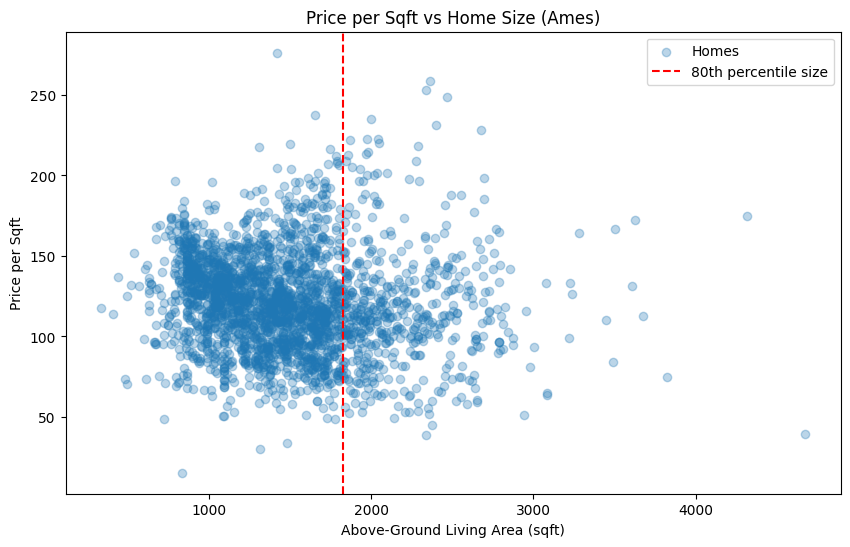

In [226]:
plt.figure(figsize=(10,6))
plt.scatter(df["GrLivArea"], df["PPSF"], alpha=0.3, label="Homes")
plt.axvline(q80, color="red", linestyle="--", label="80th percentile size")
plt.xlabel("Above-Ground Living Area (sqft)")
plt.ylabel("Price per Sqft")
plt.title("Price per Sqft vs Home Size (Ames)")
plt.legend()
plt.show()

In [232]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

def make_xgb_pipe(df_schema, xgb_kwargs=None, **pre_kwargs):
    xgb_kwargs = xgb_kwargs or {"random_state": 42, "n_estimators": 2000, "learning_rate": 0.05}
    pre = build_preprocessor(df_schema, mode="tree", **pre_kwargs)
    return Pipeline([("prep", pre), ("reg", XGBRegressor(**xgb_kwargs))])

def make_lgbm_pipe(df_schema, lgbm_kwargs=None, **pre_kwargs):
    lgbm_kwargs = lgbm_kwargs or {"random_state": 42, "n_estimators": 2000, "learning_rate": 0.05}
    pre = build_preprocessor(df_schema, mode="tree", **pre_kwargs)
    return Pipeline([("prep", pre), ("reg", LGBMRegressor(**lgbm_kwargs))])

def make_catboost_pipe(df_schema, cat_kwargs=None, **pre_kwargs):
    cat_kwargs = cat_kwargs or {"random_state": 42, "iterations": 2000, "learning_rate": 0.05, "depth": 6, "verbose": 0}
    pre = build_preprocessor(df_schema, mode="tree", **pre_kwargs)
    return Pipeline([("prep", pre), ("reg", CatBoostRegressor(**cat_kwargs))])

In [233]:
xgb_pipe = make_xgb_pipe(X_fe)
lgbm_pipe = make_lgbm_pipe(X_fe)
cat_pipe = make_catboost_pipe(X_fe)

models = [
    ("XGBoost", xgb_pipe),
    ("LightGBM", lgbm_pipe),
    ("CatBoost", cat_pipe),
    ("HistGB tuned", hgb_tuned),
    ("Ridge tuned", ridge_raw),  # or your best ridge
]

results = cv_eval_models(X=X_fe, y=y, models=models, cv=5)
print(results)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5010
[LightGBM] [Info] Number of data points in the train set: 2064, number of used features: 192
[LightGBM] [Info] Start training from score 12.007160
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5002
[LightGBM] [Info] Number of data points in the train set: 2064, number of used features: 192
[LightGBM] [Info] Start training from score 12.007915
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5001
[LightGBM] [Info] Number of data points in the train set: 2064, number of used features: 193
[LightGBM] [Info] Start t

In [262]:
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline

def make_catboost_pipe(df_schema, **cb_params):
    pre = build_preprocessor(df_schema, mode="tree", log_cols=[], scale_features=[])
    # set safe defaults only if not provided
    cb_params = dict(cb_params)
    cb_params.setdefault("loss_function", "RMSE")
    cb_params.setdefault("random_state", 42)
    cb_params.setdefault("verbose", 0)
    cb_params.setdefault("thread_count", -1)
    reg = CatBoostRegressor(**cb_params)
    return Pipeline([("prep", pre), ("reg", reg)])

In [235]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, KFold

cb_pipe = make_catboost_pipe(X_fe)

# Reasonable fast search space (40 trials)
param_dist = {
    "reg__n_estimators":      [700, 900, 1100, 1300, 1500],
    "reg__learning_rate":     np.logspace(np.log10(0.01), np.log10(0.2), 20),
    "reg__depth":             [4, 5, 6, 7, 8, 9],
    "reg__l2_leaf_reg":       np.logspace(-2, np.log10(50), 20),
    "reg__subsample":         [0.6, 0.7, 0.8, 0.9, 1.0],
    "reg__colsample_bylevel": [0.6, 0.7, 0.8, 0.9, 1.0],
    # optional extra knobs if you want:
    # "reg__min_data_in_leaf":  [1, 5, 10, 20, 50],
    # "reg__grow_policy":       ["SymmetricTree", "Depthwise"],
}

cb_fast = RandomizedSearchCV(
    estimator=cb_pipe,
    param_distributions=param_dist,
    n_iter=40,
    scoring="neg_root_mean_squared_error",
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    random_state=42,
    verbose=1,
    refit=True,
)

cb_fast.fit(X_fe, y)
print("Fast best params:", cb_fast.best_params_)
print("Fast best CV RMSE:", -cb_fast.best_score_)
cb_fast_best = cb_fast.best_estimator_

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fast best params: {'reg__subsample': 0.8, 'reg__n_estimators': 1300, 'reg__learning_rate': np.float64(0.09091879706907821), 'reg__l2_leaf_reg': np.float64(3.39526919761953), 'reg__depth': 6, 'reg__colsample_bylevel': 0.8}
Fast best CV RMSE: 19600.590105599393


In [249]:
from sklearn.model_selection import RandomizedSearchCV, KFold
import numpy as np

cb_center = {
    "reg__n_estimators":      1300,
    "reg__learning_rate":     float(0.09091879706907821),
    "reg__depth":             6,
    "reg__l2_leaf_reg":       float(3.39526919761953),
    "reg__subsample":         0.8,
    "reg__colsample_bylevel": 0.8,
}

# jitter helpers
def jitter_around(v, pct=0.25, n=7, minv=None, maxv=None):
    vals = [v*(1 + t) for t in np.linspace(-pct, pct, n)]
    if minv is not None: vals = [max(minv, x) for x in vals]
    if maxv is not None: vals = [min(maxv, x) for x in vals]
    return sorted(set(vals))

param_dist_small = {
    "reg__learning_rate":     jitter_around(cb_center["reg__learning_rate"], pct=0.35, n=9, minv=0.01, maxv=0.2),
    "reg__l2_leaf_reg":       jitter_around(cb_center["reg__l2_leaf_reg"], pct=1.0,  n=9, minv=0.01, maxv=50),
    "reg__n_estimators":      [1100, 1200, 1300, 1400, 1500],
    # keep the structure that worked:
    "reg__depth":             [6],      # optionally try [5,6,7]
    "reg__subsample":         [0.8],    # optionally try [0.7, 0.8, 0.9]
    "reg__colsample_bylevel": [0.8],    # optionally try [0.7, 0.8, 0.9]
}

cb_micro = RandomizedSearchCV(
    estimator=make_catboost_pipe(X_fe),
    param_distributions=param_dist_small,
    n_iter=12,                               # fast! try 20 if you have time
    scoring="neg_root_mean_squared_error",
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    random_state=42,
    verbose=1,
    refit=True,
)

cb_micro.fit(X_fe, y)
print("Micro best params:", cb_micro.best_params_)
print("Micro best CV RMSE:", -cb_micro.best_score_)
cb_best = cb_micro.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Micro best params: {'reg__subsample': 0.8, 'reg__n_estimators': 1300, 'reg__learning_rate': np.float64(0.05909721809490084), 'reg__l2_leaf_reg': np.float64(2.5464518982146473), 'reg__depth': 6, 'reg__colsample_bylevel': 0.8}
Micro best CV RMSE: 19395.960542977562


In [258]:
cat_micro = make_catboost_pipe(
    X_fe,
    depth=6,
    learning_rate=0.05909721809490084,
    l2_leaf_reg=2.5464518982146473,
    n_estimators=1300,     # or "iterations" depending on CatBoost version
    subsample=0.8,
    colsample_bylevel=0.8
)

In [259]:
from sklearn.ensemble import VotingRegressor

ridge_tuned = make_linear_pipe(
    X_fe,
    model="ridge",
    model_kwargs={"alpha": 18.873918221350976, "max_iter": 200_000, "tol": 1e-3}
)

# Example blend with 40/60 Ridge/CatBoost
blend_ridge_cat = VotingRegressor(
    estimators=[("ridge", ridge_tuned), ("cat", cat_micro)],
    weights=[0.4, 0.6]
)

print(cv_eval_models(X=X_fe, y=y, cv=5, models=[
    ("Ridge tuned", ridge_tuned),
    ("CatBoost micro", cat_micro),
    ("Blend Ridge+CatBoost 40/60", blend_ridge_cat),
]))

                        model  cv_rmse_mean  cv_rmse_std     r2_cv   r2_full
0              CatBoost micro  19775.988856  3744.654389  0.928012  0.995954
1  Blend Ridge+CatBoost 40/60  19944.025516  4267.218382  0.926082  0.984502
2                 Ridge tuned  21971.295139  5118.373556  0.909562  0.938575


In [271]:
# Fit final CatBoost on all data
cat_final = make_catboost_pipe(
    X_fe,
    depth=6,
    learning_rate=0.05909721809490084,
    l2_leaf_reg=2.5464518982146473,
    n_estimators=1300,
    subsample=0.8,
    colsample_bylevel=0.8
)
cat_final.fit(X_fe, y)

# In-sample fit quality (for reference only)
from sklearn.metrics import r2_score, mean_squared_error
pred_full = cat_final.predict(X_fe)

print("Full-data R²:", r2_score(y, pred_full))
print("Full-data RMSE:", np.sqrt(mean_squared_error(y, pred_full)))

Full-data R²: 0.9967039061805991
Full-data RMSE: 4306.8213027390475


             feature  importance_mean  importance_std
87    TotalSF_x_Qual         0.152907        0.004109
86  GrLivArea_x_Qual         0.047228        0.001837
80           TotalSF         0.020480        0.001196
18       OverallCond         0.010680        0.000344
4            LotArea         0.010085        0.000413
12      Neighborhood         0.010032        0.000224
34        BsmtFinSF1         0.006912        0.000252
27         ExterQual         0.006296        0.000344
20      YearRemodAdd         0.005552        0.000269
84        TotalBaths         0.004884        0.000257
55        Fireplaces         0.004815        0.000430
60        GarageCars         0.004457        0.000222
81          HouseAge         0.004234        0.000180
89   GrLivArea_large         0.004188        0.000106
17       OverallQual         0.004109        0.000214
52       KitchenQual         0.003772        0.000166
61        GarageArea         0.003744        0.000098
32      BsmtExposure        

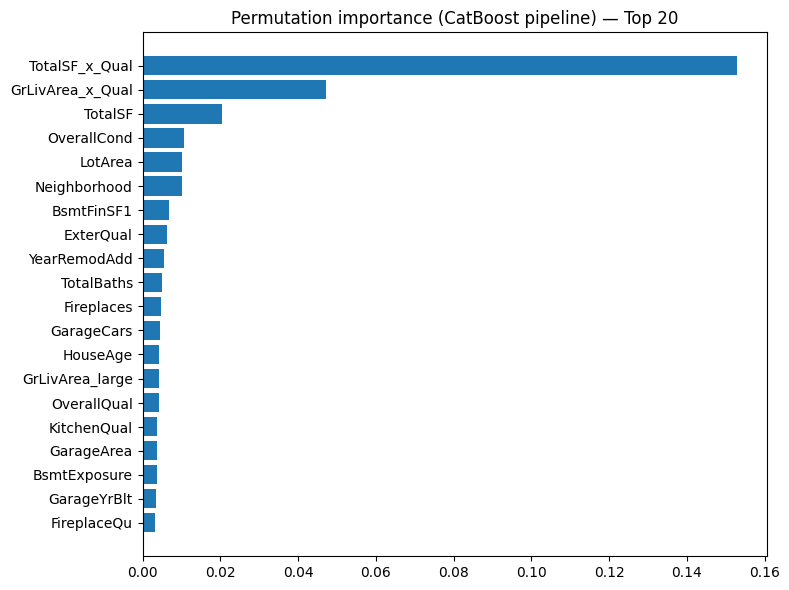

In [273]:
from sklearn.inspection import permutation_importance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# cat_final is your fitted Pipeline([... ("prep", ...), ("reg", CatBoostRegressor(...))])
perm = permutation_importance(cat_final, X_fe, y, n_repeats=10, random_state=42, n_jobs=-1)

perm_df = (
    pd.DataFrame({
        "feature": X_fe.columns,
        "importance_mean": perm.importances_mean,
        "importance_std": perm.importances_std
    })
    .sort_values("importance_mean", ascending=False)
)

print(perm_df.head(20))

plt.figure(figsize=(8,6))
top = perm_df.head(20).iloc[::-1]
plt.barh(top["feature"], top["importance_mean"])
plt.title("Permutation importance (CatBoost pipeline) — Top 20")
plt.tight_layout()
plt.show()

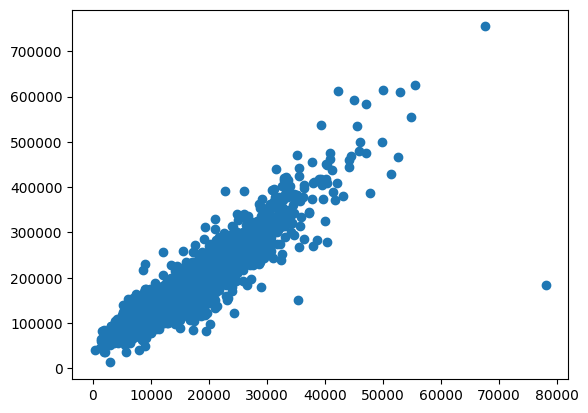

In [284]:
plt.scatter(X_fe['TotalSF_x_Qual'],y)


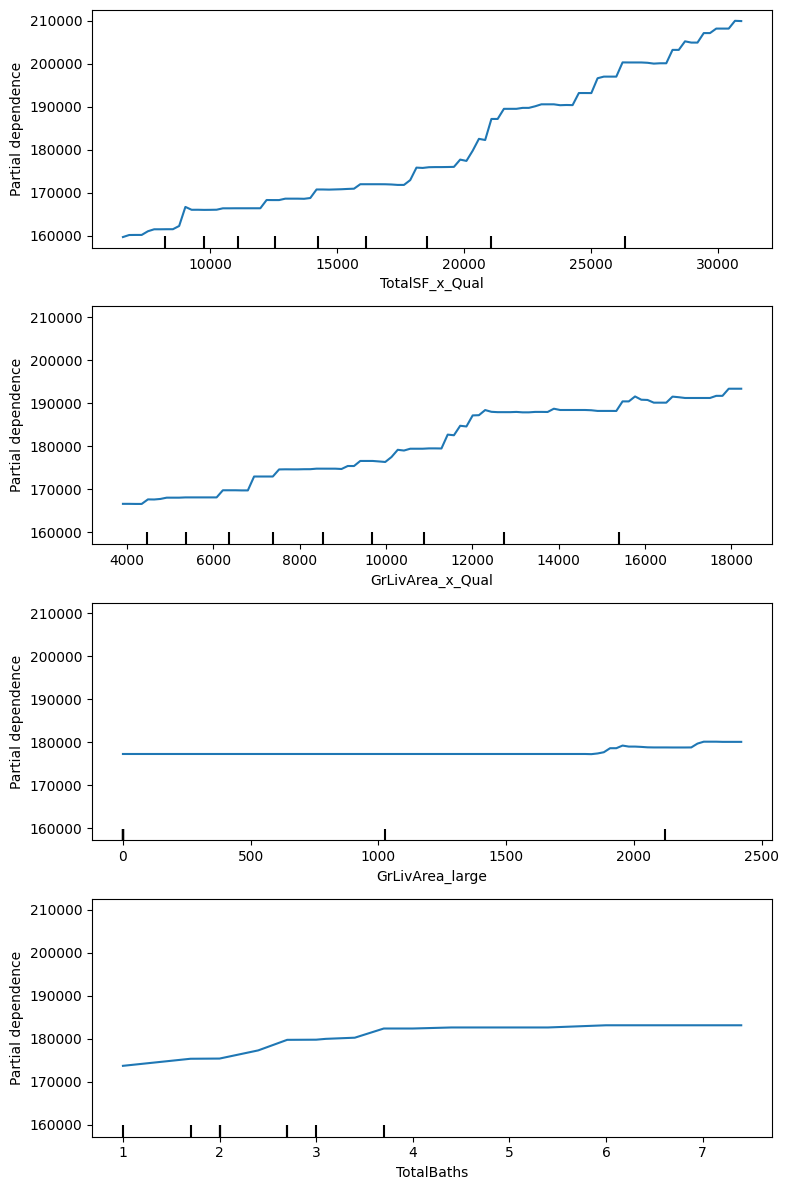

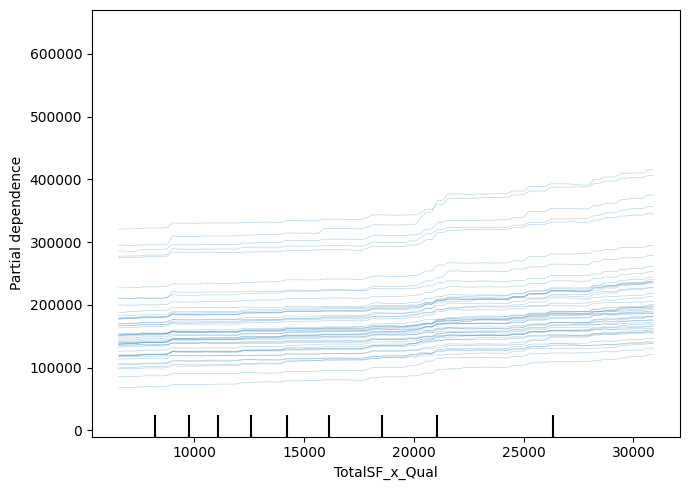

In [285]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Grab the fitted CatBoost pipeline
cat_final.fit(X_fe, y)

# Pick top features you care about
features_to_plot = [
    "TotalSF_x_Qual",     # interaction: size × quality
    "GrLivArea_x_Qual",   # interaction
    "GrLivArea_large",    # top 20% size flag
    "TotalBaths",         # useful linear-type feature
]

# --- Partial dependence plots (averaged) ---
fig, ax = plt.subplots(len(features_to_plot), 1, figsize=(8, 12))
PartialDependenceDisplay.from_estimator(
    cat_final, X_fe, features_to_plot, kind="average", ax=ax
)
plt.tight_layout()
plt.show()

# --- ICE curves for one interaction ---
fig, ax = plt.subplots(figsize=(7,5))
PartialDependenceDisplay.from_estimator(
    cat_final, X_fe,
    ["TotalSF_x_Qual"], kind="individual",   # ICE = individual curves
    subsample=50,                            # to avoid overplotting
    ax=ax
)
plt.tight_layout()
plt.show()

In [381]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

# ---------- helpers to read categories from your fitted preprocessor ----------

def _find_transformer_for_column(prep: ColumnTransformer, col: str):
    """Return (transformer, cols_in_this_block, block_index_of_col) for a given column name.
    Works when the transformer is a Pipeline that contains an OrdinalEncoder (your setup)."""
    # Try robust iteration over CT internals across sklearn versions
    try:
        it = prep._iter(fitted=True, column_as_labels=True, skip_drop=True)
    except TypeError:
        # fallback for older versions
        it = prep._iter(fitted=True, column_as_labels=True)
    for name, trans, cols, *_ in it:
        if isinstance(cols, (list, tuple, pd.Index)) and col in cols:
            # If this block is a Pipeline, unwrap to find an OrdinalEncoder
            enc = None
            if isinstance(trans, Pipeline):
                for step_name, step in trans.steps:
                    if isinstance(step, OrdinalEncoder):
                        enc = step
                        break
            elif isinstance(trans, OrdinalEncoder):
                enc = trans
            idx = list(cols).index(col)
            return enc, list(cols), idx
    return None, None, None


def _grid_for_feature_auto(model, X: pd.DataFrame, col: str, n: int,
                           q_lo=0.05, q_hi=0.95, max_levels=20):
    """
    If 'col' is handled by an OrdinalEncoder in model['prep'], return its categories
    in the learned order. Otherwise, build a numeric quantile grid.
    """
    # default: treat as numeric if dtype is numeric
    x = X[col]
    prep = None
    if isinstance(model, Pipeline) and "prep" in dict(model.steps):
        prep = model.named_steps["prep"]

    if prep is not None and isinstance(prep, ColumnTransformer):
        enc, cols_block, idx_in_block = _find_transformer_for_column(prep, col)
        if isinstance(enc, OrdinalEncoder):
            # enc.categories_ is a list aligned to 'cols_block'
            cats = enc.categories_[idx_in_block]
            # Keep original order from the encoder; convert to python list
            cats = list(cats)
            # If there are too many levels, downsample evenly (keep order)
            if len(cats) > max_levels:
                sel = np.linspace(0, len(cats)-1, max_levels).round().astype(int)
                cats = [cats[i] for i in sel]
            return cats, False  # not numeric axis

    # Fallbacks (no encoder found)
    if pd.api.types.is_numeric_dtype(x):
        lo, hi = x.quantile(q_lo), x.quantile(q_hi)
        if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:  # guard rails
            lo, hi = x.min(), x.max()
        grid = np.linspace(lo, hi, n)
        return grid, True
    else:
        # categorical/string without encoder: use most frequent levels (keep order by freq)
        counts = x.value_counts(dropna=False)
        cats = counts.index.tolist()
        if len(cats) > n:
            sel = np.linspace(0, len(cats)-1, n).round().astype(int)
            cats = [cats[i] for i in sel]
        return cats, False


# ------------------------------ main plotting function ------------------------------

def pdp_2d_heatmap_auto(
    model,                  # fitted Pipeline (with "prep" -> ColumnTransformer) + regressor
    X: pd.DataFrame,
    feat_x: str,
    feat_y: str,
    n_x: int = 25,          # used only for numeric/continuous axes
    n_y: int = 25,          # used only for numeric/continuous axes
    q_lo: float = 0.05,
    q_hi: float = 0.95,
    cmap: str = "viridis",
    figsize=(7, 6),
    show_contours: bool = True,
    levels: int = 12,
):
    """
    2D PDP-style heatmap that *automatically*:
      - uses encoder category order for ordinal/categorical features
      - uses quantile grids for continuous features
    """
    assert feat_x in X.columns and feat_y in X.columns, "Features must exist in X"

    grid_x, x_is_numeric = _grid_for_feature_auto(model, X, feat_x, n_x, q_lo, q_hi)
    grid_y, y_is_numeric = _grid_for_feature_auto(model, X, feat_y, n_y, q_lo, q_hi)

    # Build a base "typical" row (numeric -> median, non-numeric -> mode)
    vals = {}
    for c in X.columns:
        s = X[c]
        if pd.api.types.is_numeric_dtype(s):
            vals[c] = s.median()
        else:
            m = s.mode()
            vals[c] = (m.iloc[0] if not m.empty else s.iloc[0])
    base = pd.Series(vals)

    # Full cartesian grid to predict in one shot (faster & consistent)
    GX, GY = np.meshgrid(range(len(grid_x)), range(len(grid_y)))  # index grid
    rows = []
    for iy, vy in enumerate(grid_y):
        for ix, vx in enumerate(grid_x):
            row = base.copy()
            row[feat_x] = vx
            row[feat_y] = vy
            rows.append(row)
    to_pred = pd.DataFrame(rows, columns=X.columns)

    preds = model.predict(to_pred).reshape(len(grid_y), len(grid_x))

    # --- Plot ---
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    im = ax.imshow(
        preds,
        origin="lower",
        aspect="auto",
        cmap=cmap,
        extent=[0, len(grid_x)-1, 0, len(grid_y)-1]
    )

    if show_contours:
        Xc, Yc = np.meshgrid(np.arange(len(grid_x)), np.arange(len(grid_y)))
        cs = ax.contour(Xc, Yc, preds, levels=levels, colors="k", alpha=0.35, linewidths=0.8)
        ax.clabel(cs, inline=True, fontsize=8, fmt="%.0f")

    # Ticks & labels that respect numeric vs categorical axes
    if x_is_numeric:
        xticks = np.linspace(0, len(grid_x)-1, 6).round().astype(int)
        xticks = np.clip(xticks, 0, len(grid_x)-1)
        ax.set_xticks(xticks)
        ax.set_xticklabels([f"{grid_x[t]:,.0f}" for t in xticks])
    else:
        ax.set_xticks(np.arange(len(grid_x)))
        ax.set_xticklabels([str(v) for v in grid_x], rotation=45, ha="right")

    if y_is_numeric:
        yticks = np.linspace(0, len(grid_y)-1, 6).round().astype(int)
        yticks = np.clip(yticks, 0, len(grid_y)-1)
        ax.set_yticks(yticks)
        ax.set_yticklabels([f"{grid_y[t]:,.0f}" for t in yticks])
    else:
        ax.set_yticks(np.arange(len(grid_y)))
        ax.set_yticklabels([str(v) for v in grid_y])

    ax.set_xlabel(feat_x)
    ax.set_ylabel(feat_y)
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Predicted price")
    ax.set_title(f"2D PDP: {feat_x} × {feat_y}")
    plt.tight_layout()
    plt.show()

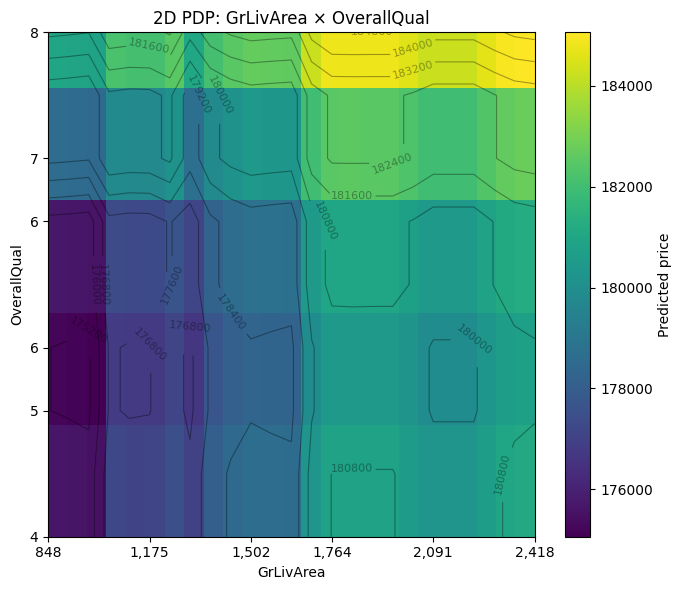

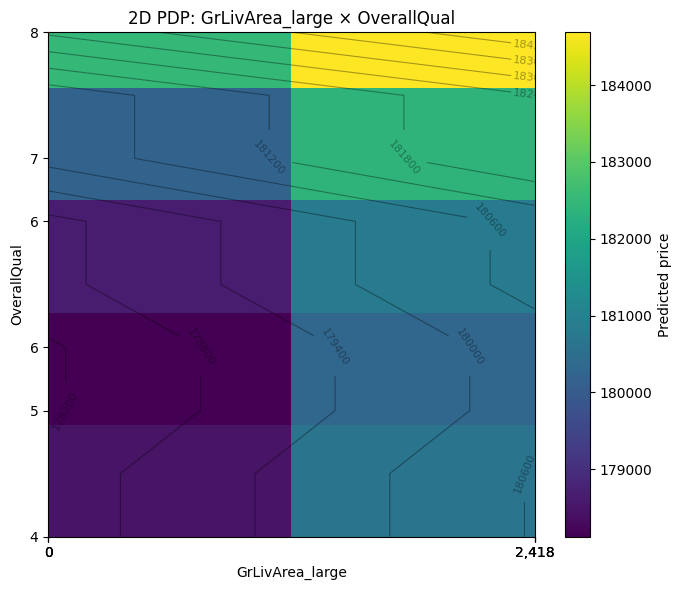

In [387]:
# ------------------ usage examples ------------------
# 1) GrLivArea (numeric) × OverallQual (ordinal/categorical)
pdp_2d_heatmap(cat_final, X_fe, "GrLivArea", "OverallQual", n_x=25, n_y=9)

# 2) Large-home flag × OverallQual (to visualize the 'discount zone')
# If your flag column is named differently, adjust below:
pdp_2d_heatmap(cat_final, X_fe, "GrLivArea_large", "OverallQual", n_x=2, n_y=9)

PDP values by OverallQual:
                   Small          Large
4.000000  173449.423963  178478.997408
4.444444  173449.423963  178478.997408
4.888889  174231.575804  179261.149249
5.333333  174231.575804  179261.149249
5.777778  175153.973009  180183.546454
6.222222  175153.973009  180183.546454
6.666667  177239.728614  181622.309997
7.111111  177239.728614  181622.309997
7.555556  179470.649110  183756.900554
8.000000  179470.649110  183756.900554

Average price gain per +1 quality point:
 Small    669.025016
Large    586.433683
Name: avg_increment, dtype: float64


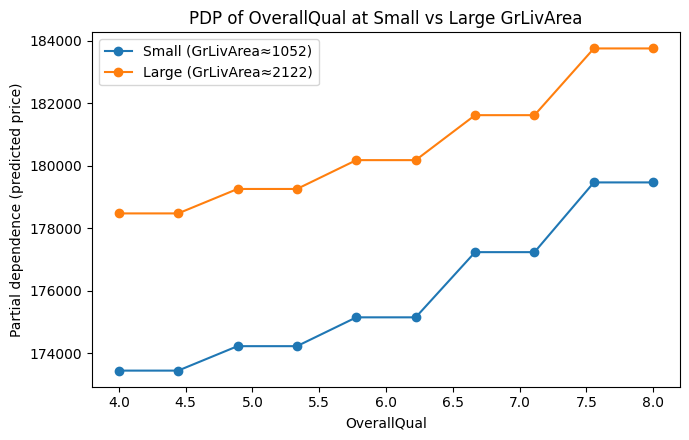

In [293]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence

def marginal_effect(model, X, feature, conditioning, grid_resolution=None):
    """
    PDP for a single feature while holding the rest of X fixed.
    Works with sklearn >=1.3 (Bunch with 'grid_values') and older (tuple).
    Returns a Series indexed by the grid values.
    """
    res = partial_dependence(
        model,
        X,
        features=[feature],
        grid_resolution=grid_resolution or 20,
        kind="average",
    )

    # New API (Bunch)
    if hasattr(res, "average"):
        pdp = res.average[0]              # shape (n_grid,)
        if hasattr(res, "grid_values"):   # >=1.3
            grid = res.grid_values[0]
        elif hasattr(res, "values"):      # some interim versions
            grid = res.values[0]
        else:
            raise RuntimeError("partial_dependence result missing grid values")
    else:
        # Old API (tuple)
        pdp, grid = res
        pdp = pdp[0]
        grid = grid[0]

    return pd.Series(pdp, index=np.asarray(grid), name=conditioning)

# ----- build "small" vs "large" scenarios -----
# Choose representative sizes (e.g., 20th and 90th percentiles of GrLivArea)
q20, q90 = np.percentile(X_fe["GrLivArea"], [20, 90])
X_small = X_fe.copy(); X_small["GrLivArea"] = q20
X_large = X_fe.copy(); X_large["GrLivArea"] = q90

# PDP for OverallQual under both size regimes
pdp_small = marginal_effect(cat_final, X_small, "OverallQual", "Small", grid_resolution=len(np.unique(X_fe["OverallQual"])))
pdp_large = marginal_effect(cat_final, X_large, "OverallQual", "Large", grid_resolution=len(np.unique(X_fe["OverallQual"])))

# Combine and show average marginal increment per +1 quality
df_effects = pd.concat([pdp_small, pdp_large], axis=1)
avg_inc = df_effects.diff().mean().rename("avg_increment")
print("PDP values by OverallQual:\n", df_effects)
print("\nAverage price gain per +1 quality point:\n", avg_inc)

# ----- plot overlay -----
plt.figure(figsize=(7,4.5))
plt.plot(df_effects.index, df_effects["Small"], marker="o", label=f"Small (GrLivArea≈{int(q20)})")
plt.plot(df_effects.index, df_effects["Large"], marker="o", label=f"Large (GrLivArea≈{int(q90)})")
plt.xlabel("OverallQual")
plt.ylabel("Partial dependence (predicted price)")
plt.title("PDP of OverallQual at Small vs Large GrLivArea")
plt.legend()
plt.tight_layout()
plt.show()

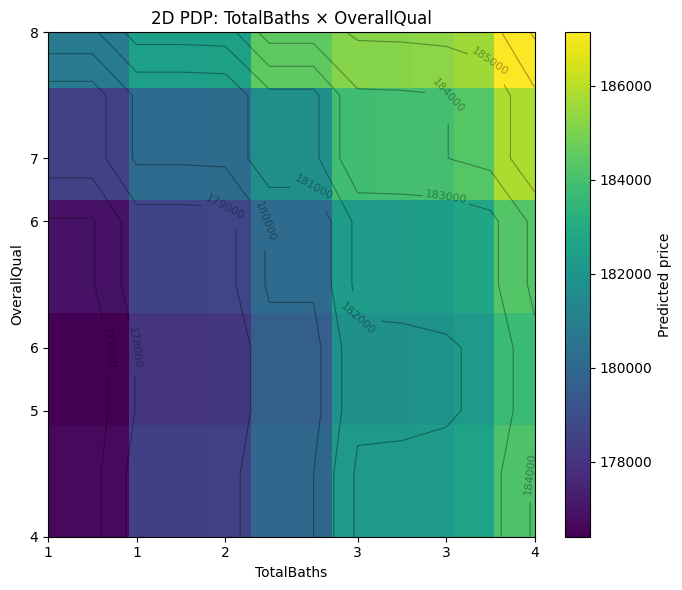

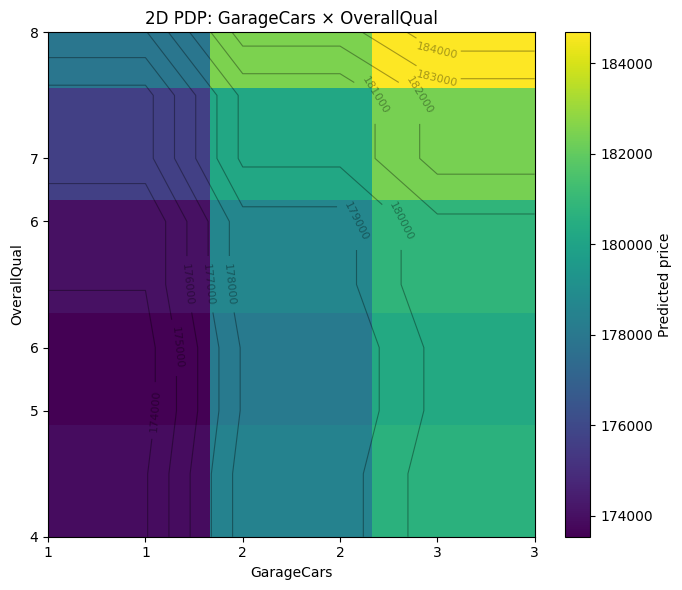

In [343]:
# TotalBaths × OverallQual
pdp_2d_heatmap(cat_final, X_fe, "TotalBaths", "OverallQual", n_x=12, n_y=9)

# GarageCars × OverallQual
pdp_2d_heatmap(cat_final, X_fe, "GarageCars", "OverallQual", n_x=6, n_y=9)


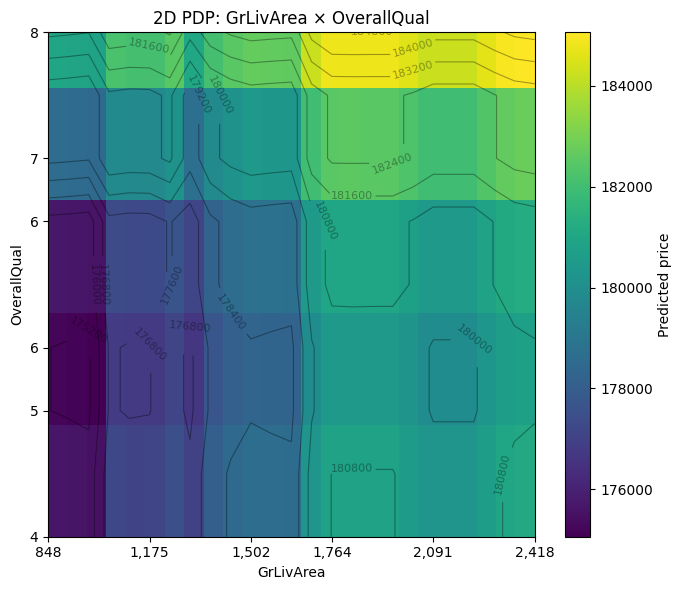

In [370]:

# GarageCars × OverallQual
pdp_2d_heatmap(cat_final, X_fe, "GrLivArea", "OverallQual", n_x=25, n_y=9)

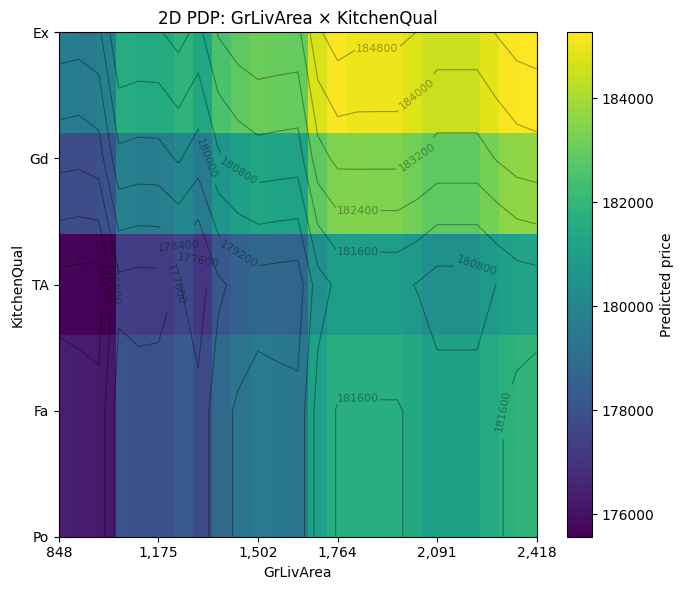

In [403]:

# GarageCars × OverallQual
pdp_2d_heatmap(cat_final, X_fe, "GrLivArea", "KitchenQual", n_x=25, n_y=9)

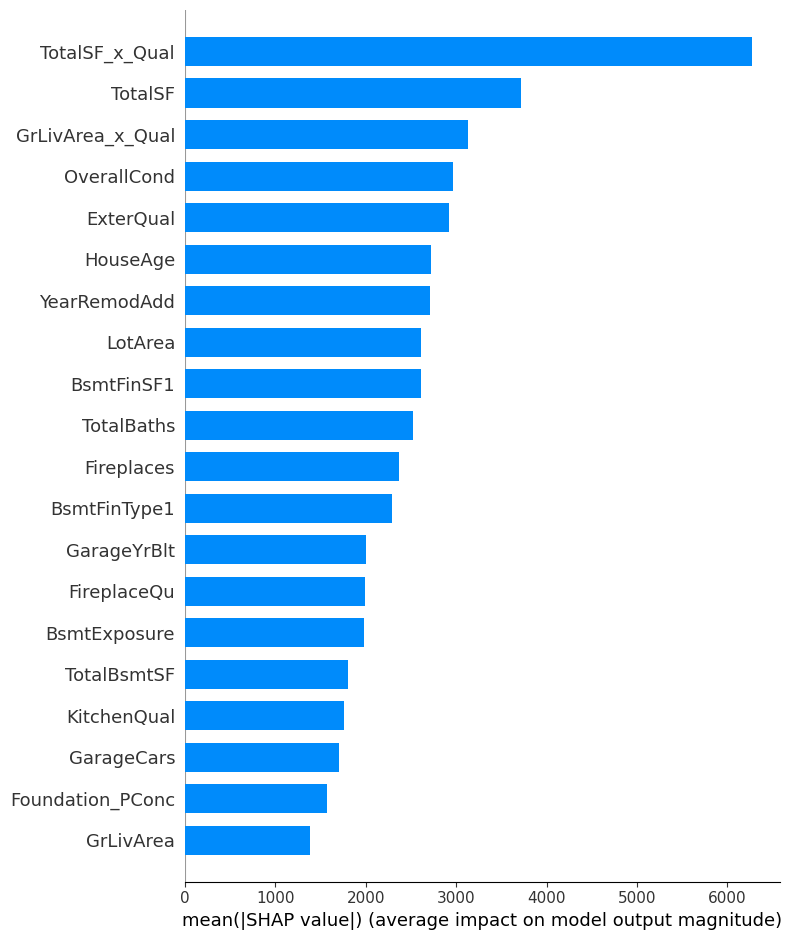

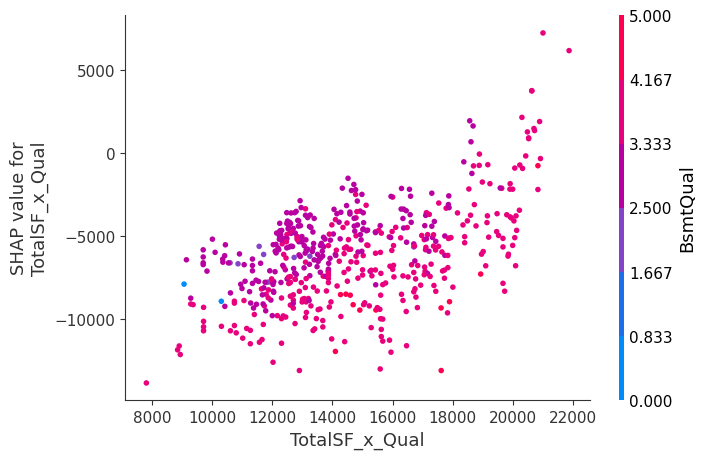

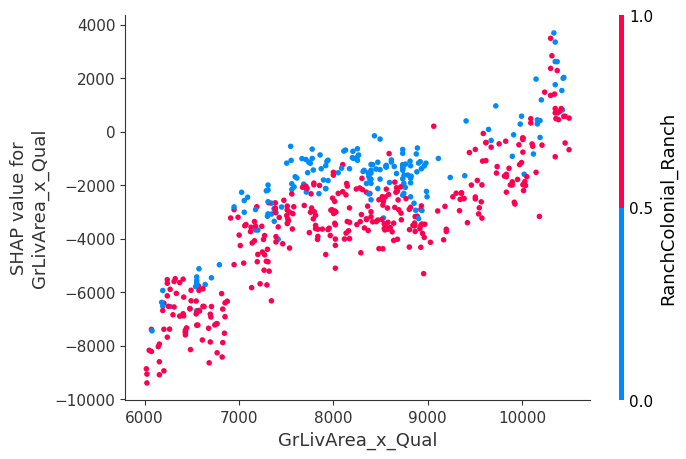

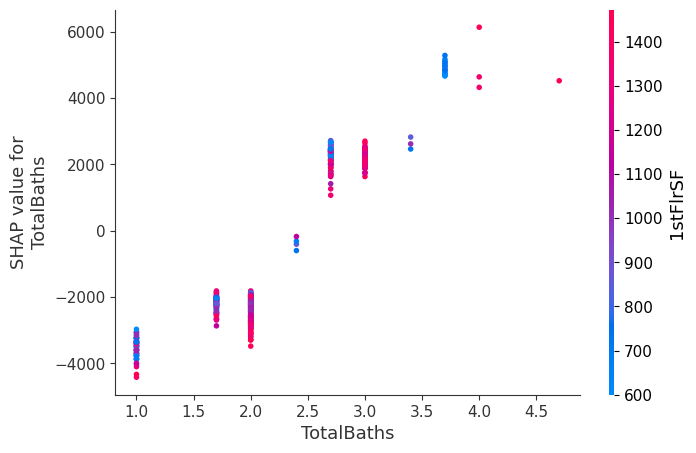

In [323]:
# --- 0) pick your slice (your red-box mask is fine) ---
mask = (X_fe["GrLivArea"].between(1000, 1500)) & (X_fe["OverallQual"].between(6, 7))
X_slice = X_fe[mask]
y_slice = y[mask]

# --- 1) get the trained pieces ---
prep = cat_final.named_steps["prep"]
cat  = cat_final.named_steps["reg"]

# --- 2) transform slice to the model's feature space (numeric) ---
#    If OHE was sparse, densify for SHAP plots
X_trans = prep.transform(X_slice)
if hasattr(X_trans, "toarray"):  # sparse
    X_trans = X_trans.toarray()

# names that align with the transformed columns
feat_names = prep.get_feature_names_out()

# wrap as DataFrame so SHAP/plots have labels
import pandas as pd
X_trans_df = pd.DataFrame(X_trans, columns=feat_names)

# --- 3) SHAP on the CatBoost model using transformed features ---
import shap
explainer   = shap.TreeExplainer(cat)                 # explain the regressor
shap_values = explainer.shap_values(X_trans_df)       # EXPLAIN THE TRANSFORMED DATA

# --- 4) Local importance (bar) + detailed dependence ---
shap.summary_plot(shap_values, X_trans_df, plot_type="bar", max_display=20)

# a couple of high-importance engineered features (adjust to your list)
for f in ["TotalSF_x_Qual", "GrLivArea_x_Qual", "TotalBaths"]:
    if f in X_trans_df.columns:
        shap.dependence_plot(f, shap_values, X_trans_df)

Slice size: 365 rows  |  GrLivArea∈[1189,1490]  OverallQual∈[6,7]


,improvement,slice_n,baseline_avg_price,mean_uplift_$,mean_uplift_%_of_baseline,assumed_cost_$,ROI_%,$-per-$1k_cost
0,ExterQual +1 level,365,167577.22,3615.92,2.16,11000,32.9,328.7
1,KitchenQual +1 level,365,167577.22,4283.04,2.56,15000,28.6,285.5
2,Add Garage bay (+1 GarageCars),365,167577.22,2543.01,1.52,9000,28.3,282.6
3,Add FullBath (+1),365,167577.22,1462.62,0.87,12000,12.2,121.9
4,Convert Half→Full (if HalfBath>0),365,167577.22,175.08,0.10,6000,2.9,29.2
5,Add HalfBath (+1),365,167577.22,85.01,0.05,7000,1.2,12.1


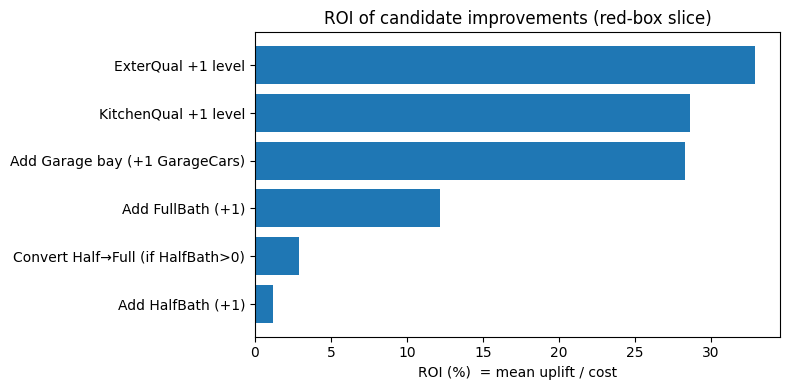

In [324]:
# === ROI on improvements inside the “red-box” slice ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# If you have ORDINAL_ORDER in scope already, this will use it for stepwise bumps.
# Otherwise define the few we need here:
ORDINAL_ORDER_LOCAL = {
    "KitchenQual": ["Po","Fa","TA","Gd","Ex"],
    "ExterQual":   ["Po","Fa","TA","Gd","Ex"],
    "OverallQual": list(range(1,11)),   # numeric ordinal (handled as numeric anyway)
}

def _bump_category(val, order, steps=1):
    """Move categorical/ordinal 'val' up by 'steps' within 'order' list."""
    try:
        i = order.index(val)
    except ValueError:
        # If unseen label, leave unchanged
        return val
    return order[min(i + steps, len(order)-1)]

def simulate_uplift(model, X_slice: pd.DataFrame, change_fn):
    """
    change_fn: function that takes a DataFrame and returns a *modified copy*
               reflecting the improvement (e.g., +1 bath)
    Returns: dict with mean/median uplift and full vector of uplifts.
    """
    base_pred = model.predict(X_slice)
    X_mod = change_fn(X_slice.copy())
    new_pred = model.predict(X_mod)
    uplift = new_pred - base_pred
    return {
        "uplift_mean": float(np.mean(uplift)),
        "uplift_median": float(np.median(uplift)),
        "uplift_perc": float(np.mean(uplift) / float(np.mean(base_pred))),  # relative to avg baseline
        "uplift_vec": uplift,
        "baseline_mean": float(np.mean(base_pred)),
        "new_mean": float(np.mean(new_pred)),
    }

# ---- 1) define the red-box slice (tweak bounds as you like) ----
# Example: OverallQual in [6,7] and GrLivArea within the 30–55th percentiles
ql_lo, ql_hi = 0.30, 0.55
gla_lo, gla_hi = X_fe["GrLivArea"].quantile(ql_lo), X_fe["GrLivArea"].quantile(ql_hi)

mask = (
    (X_fe["OverallQual"].between(6, 7)) &
    (X_fe["GrLivArea"].between(gla_lo, gla_hi))
)
X_slice = X_fe.loc[mask].copy()
print(f"Slice size: {len(X_slice)} rows  |  GrLivArea∈[{gla_lo:.0f},{gla_hi:.0f}]  OverallQual∈[6,7]")

# ---- 2) define candidate improvements & costs (edit costs to your market) ----
# Costs are *total project cost per unit change*
improvements = {
    # Bathrooms: add a half bath, full bath, or convert half->full
    "Add HalfBath (+1)": {
        "cost": 7000,
        "apply": lambda df: df.assign(HalfBath=(df["HalfBath"] + 1).clip(upper=2))  # cap to a reasonable max
    },
    "Add FullBath (+1)": {
        "cost": 12000,
        "apply": lambda df: df.assign(FullBath=(df["FullBath"] + 1).clip(upper=4))
    },
    "Convert Half→Full (if HalfBath>0)": {
        "cost": 6000,
        "apply": lambda df: df.assign(
            HalfBath=(df["HalfBath"] - (df["HalfBath"]>0).astype(int)).clip(lower=0),
            FullBath=(df["FullBath"] + (df["HalfBath"]>0).astype(int))
        )
    },
    # Garage capacity
    "Add Garage bay (+1 GarageCars)": {
        "cost": 9000,
        "apply": lambda df: df.assign(GarageCars=(df["GarageCars"] + 1).clip(upper=4))
    },
    # Kitchen quality bump by 1 level within ordinal ladder
    "KitchenQual +1 level": {
        "cost": 15000,
        "apply": lambda df: df.assign(
            KitchenQual=df["KitchenQual"].map(
                lambda v: _bump_category(
                    v,
                    (ORDINAL_ORDER_LOCAL.get("KitchenQual") or ORDINAL_ORDER["KitchenQual"]),
                    steps=1
                )
            )
        )
    },
    # Exterior quality bump by 1
    "ExterQual +1 level": {
        "cost": 11000,
        "apply": lambda df: df.assign(
            ExterQual=df["ExterQual"].map(
                lambda v: _bump_category(
                    v,
                    (ORDINAL_ORDER_LOCAL.get("ExterQual") or ORDINAL_ORDER["ExterQual"]),
                    steps=1
                )
            )
        )
    },
}

# ---- 3) run simulations & assemble ROI table ----
rows = []
for name, spec in improvements.items():
    res = simulate_uplift(cat_final, X_slice, spec["apply"])
    mean_uplift = res["uplift_mean"]
    base_avg = res["baseline_mean"]
    roi = (mean_uplift / spec["cost"]) * 100.0
    rows.append({
        "improvement": name,
        "slice_n": len(X_slice),
        "baseline_avg_price": round(base_avg, 2),
        "mean_uplift_$": round(mean_uplift, 2),
        "mean_uplift_%_of_baseline": round(100.0 * mean_uplift / base_avg, 2),
        "assumed_cost_$": spec["cost"],
        "ROI_%": round(roi, 1),
        "$-per-$1k_cost": round(mean_uplift / (spec["cost"]/1000.0), 1),
    })

roi_df = pd.DataFrame(rows).sort_values("ROI_%", ascending=False).reset_index(drop=True)
display(roi_df)

# ---- 4) quick bar chart of ROI ----
plt.figure(figsize=(8,4))
plt.barh(roi_df["improvement"], roi_df["ROI_%"])
plt.gca().invert_yaxis()
plt.xlabel("ROI (%)  = mean uplift / cost")
plt.title("ROI of candidate improvements (red-box slice)")
plt.tight_layout()
plt.show()

dataset,Full dataset,Red-box slice
improvement,,
Add FullBath (+1),10.9,12.2
Add Garage bay (+1 GarageCars),32.0,28.3
Add HalfBath (+1),1.6,1.2
Convert Half→Full (if HalfBath>0),0.3,2.9
ExterQual +1 level,38.7,32.9
KitchenQual +1 level,26.4,28.6


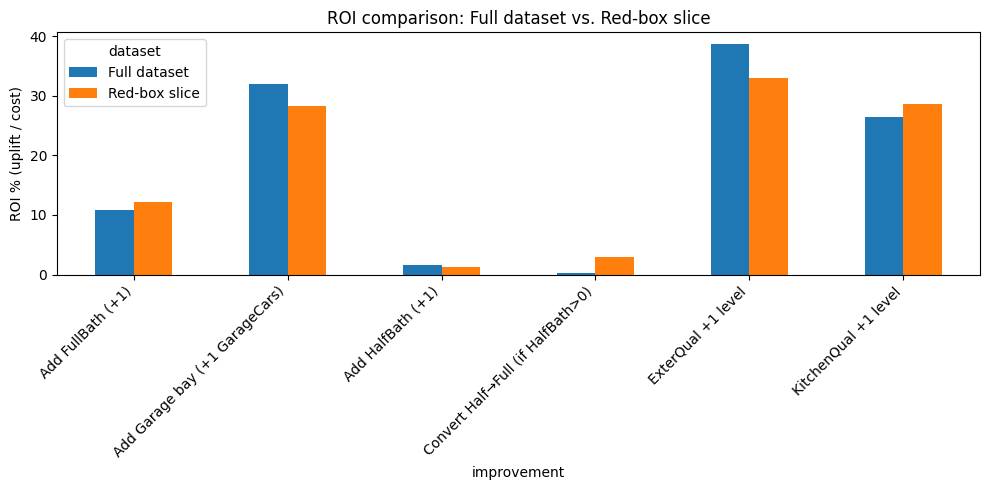

In [325]:
# === Compare ROI for full dataset vs. red-box slice ===

def compute_roi_table(model, X: pd.DataFrame, improvements: dict, label: str):
    rows = []
    for name, spec in improvements.items():
        res = simulate_uplift(model, X, spec["apply"])
        mean_uplift = res["uplift_mean"]
        base_avg = res["baseline_mean"]
        roi = (mean_uplift / spec["cost"]) * 100.0
        rows.append({
            "dataset": label,
            "improvement": name,
            "n": len(X),
            "baseline_avg_price": round(base_avg, 2),
            "mean_uplift_$": round(mean_uplift, 2),
            "mean_uplift_%_of_baseline": round(100.0 * mean_uplift / base_avg, 2),
            "assumed_cost_$": spec["cost"],
            "ROI_%": round(roi, 1),
            "$-per-$1k_cost": round(mean_uplift / (spec["cost"]/1000.0), 1),
        })
    return pd.DataFrame(rows)

# Compute for both datasets
roi_all   = compute_roi_table(cat_final, X_fe, improvements, "Full dataset")
roi_slice = compute_roi_table(cat_final, X_slice, improvements, "Red-box slice")

# Combine
roi_compare = pd.concat([roi_all, roi_slice], axis=0).reset_index(drop=True)

# Pivot for easy side-by-side comparison
roi_pivot = roi_compare.pivot(index="improvement", columns="dataset", values="ROI_%")
display(roi_pivot)

# --- Plot: ROI comparison side-by-side ---
roi_pivot.plot(kind="bar", figsize=(10,5))
plt.ylabel("ROI % (uplift / cost)")
plt.title("ROI comparison: Full dataset vs. Red-box slice")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

=== ROI % Comparison ===


dataset,Full dataset,Red-box slice
improvement,,
Add FullBath (+1),10.9,12.2
Add Garage bay (+1 GarageCars),32.0,28.3
Add HalfBath (+1),1.6,1.2
Convert Half→Full (if HalfBath>0),0.3,2.9
ExterQual +1 level,38.7,32.9
KitchenQual +1 level,26.4,28.6



=== Absolute $ Uplift Comparison ===


dataset,Full dataset,Red-box slice
improvement,,
Add FullBath (+1),1310.0,1463.0
Add Garage bay (+1 GarageCars),2880.0,2543.0
Add HalfBath (+1),109.0,85.0
Convert Half→Full (if HalfBath>0),18.0,175.0
ExterQual +1 level,4255.0,3616.0
KitchenQual +1 level,3958.0,4283.0


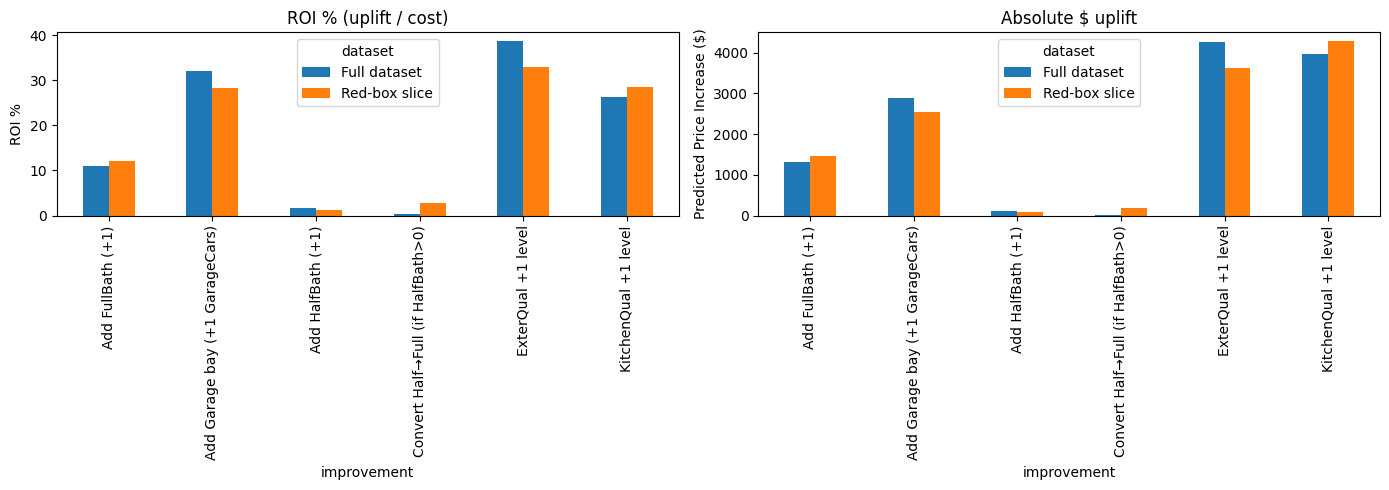

In [326]:
# === Extended ROI comparison: ROI% and Absolute $ uplift ===

def compute_roi_table(model, X: pd.DataFrame, improvements: dict, label: str):
    rows = []
    for name, spec in improvements.items():
        res = simulate_uplift(model, X, spec["apply"])
        mean_uplift = res["uplift_mean"]
        base_avg    = res["baseline_mean"]
        roi = (mean_uplift / spec["cost"]) * 100.0
        rows.append({
            "dataset": label,
            "improvement": name,
            "n": len(X),
            "baseline_avg_price": round(base_avg, 0),
            "uplift_$": round(mean_uplift, 0),
            "uplift_%_of_baseline": round(100.0 * mean_uplift / base_avg, 2),
            "assumed_cost_$": spec["cost"],
            "ROI_%": round(roi, 1),
            "$-per-$1k_cost": round(mean_uplift / (spec["cost"]/1000.0), 1),
        })
    return pd.DataFrame(rows)

# Run for both full dataset and slice
roi_all   = compute_roi_table(cat_final, X_fe, improvements, "Full dataset")
roi_slice = compute_roi_table(cat_final, X_slice, improvements, "Red-box slice")

# Combine into one table
roi_compare = pd.concat([roi_all, roi_slice], axis=0).reset_index(drop=True)

# Pivot into two summary tables for readability
roi_pivot_roi   = roi_compare.pivot(index="improvement", columns="dataset", values="ROI_%")
roi_pivot_uplift= roi_compare.pivot(index="improvement", columns="dataset", values="uplift_$")

# --- Display results ---
print("=== ROI % Comparison ===")
display(roi_pivot_roi)

print("\n=== Absolute $ Uplift Comparison ===")
display(roi_pivot_uplift)

# --- Plot ROI and Uplift side-by-side ---
fig, axes = plt.subplots(1, 2, figsize=(14,5))

roi_pivot_roi.plot(kind="bar", ax=axes[0], title="ROI % (uplift / cost)")
axes[0].set_ylabel("ROI %")

roi_pivot_uplift.plot(kind="bar", ax=axes[1], title="Absolute $ uplift")
axes[1].set_ylabel("Predicted Price Increase ($)")

plt.tight_layout()
plt.show()

=== ROI % Comparison ===


dataset,Full dataset,Red-box slice
improvement,,
Add FullBath (+1),10.9,12.2
Add Garage bay (+1 GarageCars),32.0,28.3
Add HalfBath (+1),1.6,1.2
Convert Half→Full (if HalfBath>0),0.3,2.9
ExterQual +1 level,38.7,32.9
KitchenQual +1 level,26.4,28.6



=== Absolute $ Uplift Comparison ===


dataset,Full dataset,Red-box slice
improvement,,
Add FullBath (+1),1310.0,1463.0
Add Garage bay (+1 GarageCars),2880.0,2543.0
Add HalfBath (+1),109.0,85.0
Convert Half→Full (if HalfBath>0),18.0,175.0
ExterQual +1 level,4255.0,3616.0
KitchenQual +1 level,3958.0,4283.0



=== Uplift as % of baseline home value ===


dataset,Full dataset,Red-box slice
improvement,,
Add FullBath (+1),0.74,0.87
Add Garage bay (+1 GarageCars),1.62,1.52
Add HalfBath (+1),0.06,0.05
Convert Half→Full (if HalfBath>0),0.01,0.10
ExterQual +1 level,2.39,2.16
KitchenQual +1 level,2.22,2.56


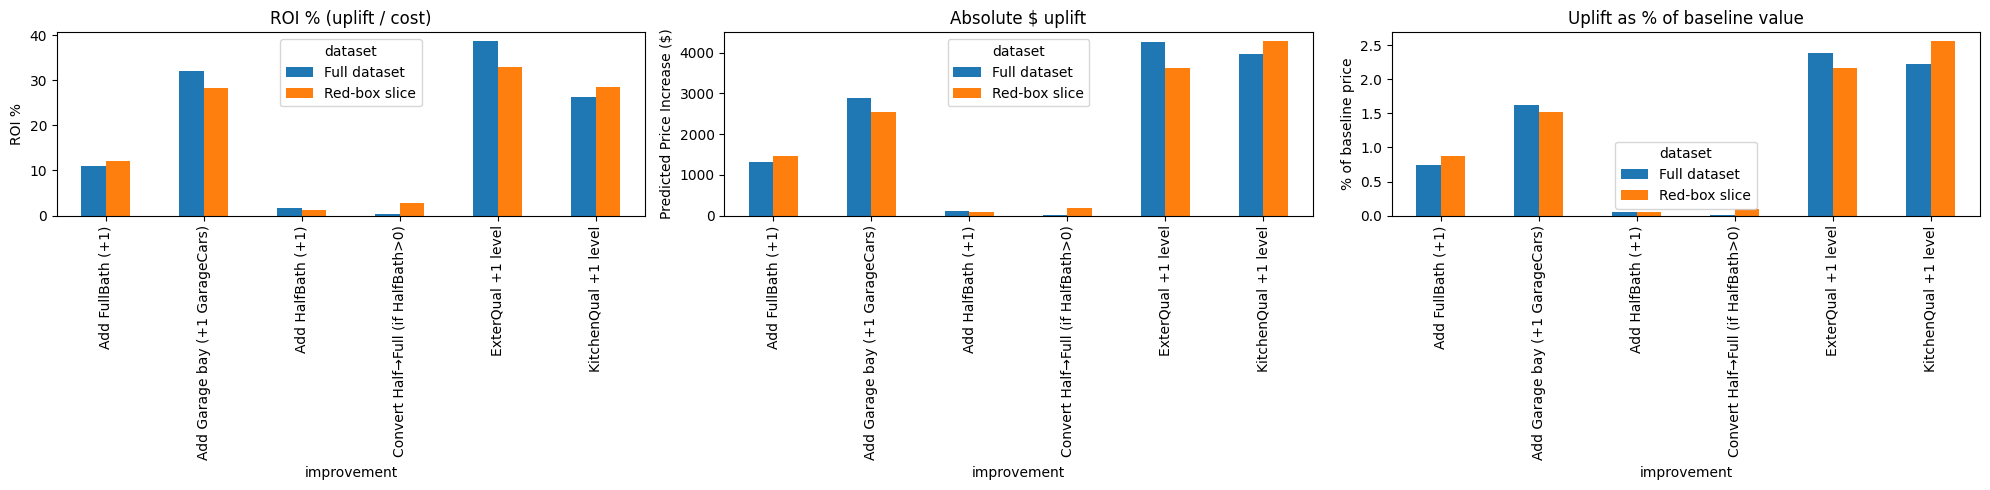

In [327]:
# === ROI comparison with normalization by baseline price ===

def compute_roi_table(model, X: pd.DataFrame, improvements: dict, label: str):
    rows = []
    for name, spec in improvements.items():
        res = simulate_uplift(model, X, spec["apply"])
        mean_uplift = res["uplift_mean"]
        base_avg    = res["baseline_mean"]
        roi = (mean_uplift / spec["cost"]) * 100.0
        rows.append({
            "dataset": label,
            "improvement": name,
            "n": len(X),
            "baseline_avg_price": round(base_avg, 0),
            "uplift_$": round(mean_uplift, 0),
            "uplift_%_of_baseline": round(100.0 * mean_uplift / base_avg, 2),   # NEW normalization
            "assumed_cost_$": spec["cost"],
            "ROI_%": round(roi, 1),
            "$-per-$1k_cost": round(mean_uplift / (spec["cost"]/1000.0), 1),
        })
    return pd.DataFrame(rows)

# Run both
roi_all   = compute_roi_table(cat_final, X_fe, improvements, "Full dataset")
roi_slice = compute_roi_table(cat_final, X_slice, improvements, "Red-box slice")

roi_compare = pd.concat([roi_all, roi_slice], axis=0).reset_index(drop=True)

# Pivot summaries
roi_pivot_roi      = roi_compare.pivot(index="improvement", columns="dataset", values="ROI_%")
roi_pivot_uplift   = roi_compare.pivot(index="improvement", columns="dataset", values="uplift_$")
roi_pivot_upliftpc = roi_compare.pivot(index="improvement", columns="dataset", values="uplift_%_of_baseline")

# Display
print("=== ROI % Comparison ===")
display(roi_pivot_roi)

print("\n=== Absolute $ Uplift Comparison ===")
display(roi_pivot_uplift)

print("\n=== Uplift as % of baseline home value ===")
display(roi_pivot_upliftpc)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(20,5))

roi_pivot_roi.plot(kind="bar", ax=axes[0], title="ROI % (uplift / cost)")
axes[0].set_ylabel("ROI %")

roi_pivot_uplift.plot(kind="bar", ax=axes[1], title="Absolute $ uplift")
axes[1].set_ylabel("Predicted Price Increase ($)")

roi_pivot_upliftpc.plot(kind="bar", ax=axes[2], title="Uplift as % of baseline value")
axes[2].set_ylabel("% of baseline price")

plt.tight_layout()
plt.show()

In [329]:
import pandas as pd
import numpy as np

# --- 1) Define renovation cost assumptions ---
upgrade_costs = {
    "HalfBath+1": 7000,
    "FullBath+1": 12000,
    "GarageCars+1": 15000,
    "OverallQual+1": 20000,  # quality bump (e.g. kitchen remodel)
    "BsmtFinSF1+500": 15000  # finish 500 sqft of basement
}

# --- 2) Helper to simulate upgrades ---
def simulate_upgrades(model, X: pd.DataFrame, upgrades: dict):
    """
    For each house and each upgrade, compute new predicted price,
    delta vs. baseline, and ROI%.
    """
    base_pred = model.predict(X)
    results = []

    for upgrade, cost in upgrades.items():
        X_mod = X.copy()

        # Apply upgrade
        if upgrade == "HalfBath+1":
            X_mod["HalfBath"] = X_mod["HalfBath"] + 1
        elif upgrade == "FullBath+1":
            X_mod["FullBath"] = X_mod["FullBath"] + 1
        elif upgrade == "GarageCars+1":
            X_mod["GarageCars"] = X_mod["GarageCars"] + 1
        elif upgrade == "OverallQual+1":
            X_mod["OverallQual"] = np.minimum(X_mod["OverallQual"] + 1, 10)
        elif upgrade == "BsmtFinSF1+500":
            X_mod["BsmtFinSF1"] = X_mod["BsmtFinSF1"] + 500

        # Predict new prices
        new_pred = model.predict(X_mod)

        # Gains and ROI
        gain = new_pred - base_pred
        roi = gain / cost

        df_up = pd.DataFrame({
            "upgrade": upgrade,
            "cost": cost,
            "gain": gain,
            "roi": roi,
            "baseline_pred": base_pred,
            "new_pred": new_pred
        })
        results.append(df_up)

    return pd.concat(results, axis=0)

# --- 3) Run on full dataset ---
roi_results = simulate_upgrades(cat_final, X_fe, upgrade_costs)

# --- 4) Summarize best opportunities ---
top_candidates = (
    roi_results
    .groupby(["upgrade"])
    .agg(avg_gain=("gain","mean"),
         avg_roi=("roi","mean"),
         max_roi=("roi","max"))
    .sort_values("avg_roi", ascending=False)
)

# Individual best flips (ROI sorted)
house_opportunities = roi_results.sort_values("roi", ascending=False).head(20)

# Show the top upgrade opportunities for specific houses
house_opportunities = roi_results.sort_values("roi", ascending=False).head(20)

# Show in notebook
house_opportunities.head(20)

,upgrade,cost,gain,roi,baseline_pred,new_pred
942,BsmtFinSF1+500,15000,22262.454983,1.484164,384424.936768,406687.391750
290,HalfBath+1,7000,9551.771887,1.364539,480903.047302,490454.819188
416,BsmtFinSF1+500,15000,18998.698239,1.266580,322285.301368,341283.999607
246,HalfBath+1,7000,8617.087274,1.231012,238784.146213,247401.233488
103,HalfBath+1,7000,8509.149737,1.215593,467647.343254,476156.492991
275,BsmtFinSF1+500,15000,18175.648289,1.211710,150951.267594,169126.915883
635,BsmtFinSF1+500,15000,17407.011586,1.160467,403839.203914,421246.215500
944,BsmtFinSF1+500,15000,15815.379401,1.054359,325995.869127,341811.248528
666,BsmtFinSF1+500,15000,15690.042193,1.046003,316956.562869,332646.605062
781,BsmtFinSF1+500,15000,15526.454911,1.035097,337122.036789,352648.491699


In [333]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 0) Define the red-box subset
#    (adjust ranges if your box is different)
# -----------------------------
q80, q95 = X_fe["GrLivArea"].quantile([0.80, 0.95])
mask_subset = (
    (X_fe["GrLivArea"] >= q80) &
    (X_fe["GrLivArea"] <= q95) &
    (X_fe["OverallQual"].between(5, 7))
)
X_subset = X_fe.loc[mask_subset].copy()

print(f"Subset size: {len(X_subset)} rows (of {len(X_fe)})")

# -----------------------------
# 1) Helper: safe category bump
# -----------------------------
ORDINAL_ORDER = {
    "KitchenQual": ["Po","Fa","TA","Gd","Ex"],
    "ExterQual":   ["Po","Fa","TA","Gd","Ex"],
}
def bump_one_level(val, order):
    try:
        i = order.index(val)
        return order[min(i+1, len(order)-1)]
    except ValueError:
        # unseen level -> leave as is
        return val

# -----------------------------
# 2) Define upgrade scenarios
#    (edit costs to your market)
# -----------------------------
COSTS = {
    "Add Half Bath":                 6000,   # convert closet / powder addition
    "Add Full Bath":                12000,   # add shower/tub
    "Upgrade Kitchen Quality +1":   15000,   # modest refresh
    "Upgrade Exterior Quality +1":   8000,   # siding/paint/window trims
    "Add Garage Car (capacity +1)": 12000,   # add bay / carport
    "Add Fireplace":                  4000,
}

def apply_upgrade(df: pd.DataFrame, name: str) -> pd.DataFrame:
    out = df.copy()
    if name == "Add Half Bath":
        if "TotalBaths" in out.columns:
            out["TotalBaths"] = out["TotalBaths"] + 0.5
        else:
            # fall back to raw parts if TotalBaths not present
            if "HalfBath" in out.columns:
                out["HalfBath"] = out["HalfBath"] + 1
    elif name == "Add Full Bath":
        if "TotalBaths" in out.columns:
            out["TotalBaths"] = out["TotalBaths"] + 1.0
        else:
            if "FullBath" in out.columns:
                out["FullBath"] = out["FullBath"] + 1
    elif name == "Upgrade Kitchen Quality +1":
        col = "KitchenQual"
        if col in out.columns:
            out[col] = out[col].apply(lambda v: bump_one_level(v, ORDINAL_ORDER["KitchenQual"]))
    elif name == "Upgrade Exterior Quality +1":
        col = "ExterQual"
        if col in out.columns:
            out[col] = out[col].apply(lambda v: bump_one_level(v, ORDINAL_ORDER["ExterQual"]))
    elif name == "Add Garage Car (capacity +1)":
        col = "GarageCars"
        if col in out.columns:
            out[col] = out[col] + 1
    elif name == "Add Fireplace":
        col = "Fireplaces"
        if col in out.columns:
            out[col] = out[col] + 1
    else:
        raise ValueError(f"Unknown upgrade: {name}")
    return out

def applicable_mask(before: pd.DataFrame, after: pd.DataFrame) -> np.ndarray:
    """Rows where the upgrade actually changed something (e.g., was not already max)."""
    diff_cols = [c for c in before.columns if not before[c].equals(after[c])]
    if not diff_cols:
        return np.zeros(len(before), dtype=bool)
    # Any changed col flags applicability
    return np.any([(before[c] != after[c]).to_numpy() for c in diff_cols], axis=0)

# -----------------------------
# 3) Core ROI calculator
# -----------------------------
def upgrade_roi_table(model, X: pd.DataFrame, costs: dict, top_k=None) -> pd.DataFrame:
    """
    Predict price delta for each upgrade scenario and compute ROI:
      ROI% = 100 * (avg_price_gain - cost) / cost
    Returns per-upgrade stats (only among rows where the change applied).
    """
    base_pred = model.predict(X)  # uses pipeline preprocessing internally
    rows = []
    for upg, cost in costs.items():
        X_up = apply_upgrade(X, upg)
        pred_up = model.predict(X_up)
        delta = pred_up - base_pred

        # keep only rows where something actually changed
        X_mask = applicable_mask(X, X_up)
        if X_mask.sum() == 0:
            continue
        d = delta[X_mask]

        rows.append({
            "upgrade": upg,
            "n_applicable": int(X_mask.sum()),
            "avg_gain_$": float(np.mean(d)),
            "median_gain_$": float(np.median(d)),
            "p25_gain_$": float(np.percentile(d, 25)),
            "p75_gain_$": float(np.percentile(d, 75)),
            "cost_$": float(cost),
            "avg_ROI_%": float(100.0 * (np.mean(d) - cost) / cost),
            "median_ROI_%": float(100.0 * (np.median(d) - cost) / cost),
        })
    df = pd.DataFrame(rows).sort_values("avg_ROI_%", ascending=False).reset_index(drop=True)
    return df if top_k is None else df.head(top_k)

# -----------------------------
# 4) Run for subset vs full
# -----------------------------
roi_subset = upgrade_roi_table(cat_final, X_subset, COSTS)
roi_full   = upgrade_roi_table(cat_final, X_fe,     COSTS)

# Pretty side-by-side merge
def _rename(df, suffix):
    return df.rename(columns={
        "n_applicable": f"n_applicable_{suffix}",
        "avg_gain_$":   f"avg_gain_${suffix}",
        "median_gain_$":f"median_gain_${suffix}",
        "p25_gain_$":   f"p25_gain_${suffix}",
        "p75_gain_$":   f"p75_gain_${suffix}",
        "cost_$":       f"cost_${suffix}",
        "avg_ROI_%":    f"avg_ROI_%_{suffix}",
        "median_ROI_%": f"median_ROI_%_{suffix}",
    })

comp = _rename(roi_subset, "subset").merge(
    _rename(roi_full, "full"),
    on="upgrade", suffixes=("", "")
)

# Reorder a few useful columns up front
front_cols = [
    "upgrade",
    "n_applicable_subset", "n_applicable_full",
    "avg_gain_$subset", "avg_gain_$full",
    "avg_ROI_%_subset", "avg_ROI_%_full",
    "median_ROI_%_subset", "median_ROI_%_full",
    "cost_$subset", "cost_$full",
]
other_cols = [c for c in comp.columns if c not in front_cols]
comp = comp[front_cols + other_cols]

# Show the comparison table
comp

Subset size: 256 rows (of 2580)


,upgrade,n_applicable_subset,n_applicable_full,avg_gain_$subset,avg_gain_$full,avg_ROI_%_subset,avg_ROI_%_full,median_ROI_%_subset,median_ROI_%_full,cost_$subset,cost_$full,median_gain_$subset,p25_gain_$subset,p75_gain_$subset,median_gain_$full,p25_gain_$full,p75_gain_$full
0,Add Fireplace,256,2580,4026.441314,3749.582975,0.661033,-6.260426,1.868952,-17.445803,4000.0,4000.0,4074.758089,2973.981906,5662.413600,3302.167873,2617.808266,4811.677377
1,Upgrade Exterior Quality +1,255,2507,5396.417104,4378.638370,-32.544786,-45.267020,-34.312791,-55.324237,8000.0,8000.0,5254.976749,3797.445757,6662.270960,3574.061014,2469.329150,5269.268761
2,Upgrade Kitchen Quality +1,249,2438,5073.589925,4188.660001,-66.176067,-72.075600,-68.298447,-75.675187,15000.0,15000.0,4755.232979,3439.291135,6784.843412,3648.721953,2816.858640,5362.238366
3,Add Garage Car (capacity +1),256,2580,3545.062476,2879.543821,-70.457813,-76.003801,-68.561273,-76.922998,12000.0,12000.0,3772.647191,2000.324555,5013.903932,2769.240298,1966.335175,3849.249457
4,Add Full Bath,256,2580,2144.112987,2361.751381,-82.132392,-80.318738,-81.795705,-80.184724,12000.0,12000.0,2184.515443,1160.611199,3065.589339,2377.833152,1369.755512,3226.382811
5,Add Half Bath,256,2580,545.251562,733.809601,-90.912474,-87.769840,-95.897752,-91.346591,6000.0,6000.0,246.134851,0.000000,1119.114627,519.204567,89.727301,1303.107550


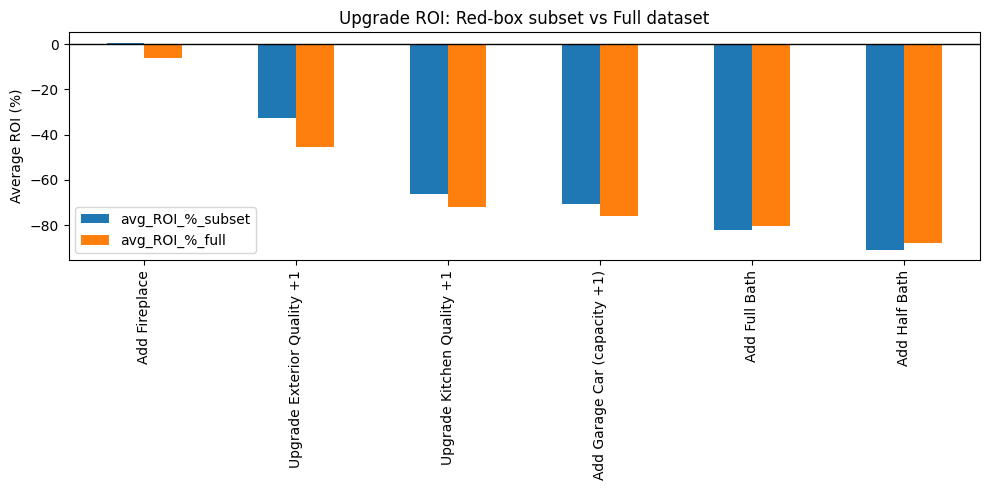

In [334]:
# Bar chart: average ROI% comparison
plot_df = comp[["upgrade", "avg_ROI_%_subset", "avg_ROI_%_full"]].set_index("upgrade")
ax = plot_df.plot(kind="bar", figsize=(10,5))
ax.set_ylabel("Average ROI (%)")
ax.set_xlabel("")
ax.set_title("Upgrade ROI: Red-box subset vs Full dataset")
ax.axhline(0, color="k", linewidth=1)
plt.tight_layout()
plt.show()

Subset size: 256 rows (of 2580)


,upgrade,n_applicable_subset,avg_gain_$_subset,median_gain_$_subset,p25_gain_$_subset,p75_gain_$_subset,n_applicable_full,avg_gain_$_full,median_gain_$_full,p25_gain_$_full,p75_gain_$_full
0,Upgrade Exterior Quality +1,255,5396.417104,5254.976749,3797.445757,6662.270960,2507,4378.638370,3574.061014,2469.329150,5269.268761
1,Upgrade Kitchen Quality +1,249,5073.589925,4755.232979,3439.291135,6784.843412,2438,4188.660001,3648.721953,2816.858640,5362.238366
2,Add Fireplace,256,4026.441314,4074.758089,2973.981906,5662.413600,2580,3749.582975,3302.167873,2617.808266,4811.677377
3,Add Garage Car (capacity +1),256,3545.062476,3772.647191,2000.324555,5013.903932,2580,2879.543821,2769.240298,1966.335175,3849.249457
4,Add Full Bath,256,2144.112987,2184.515443,1160.611199,3065.589339,2580,2361.751381,2377.833152,1369.755512,3226.382811
5,Add Half Bath,256,545.251562,246.134851,0.000000,1119.114627,2580,733.809601,519.204567,89.727301,1303.107550


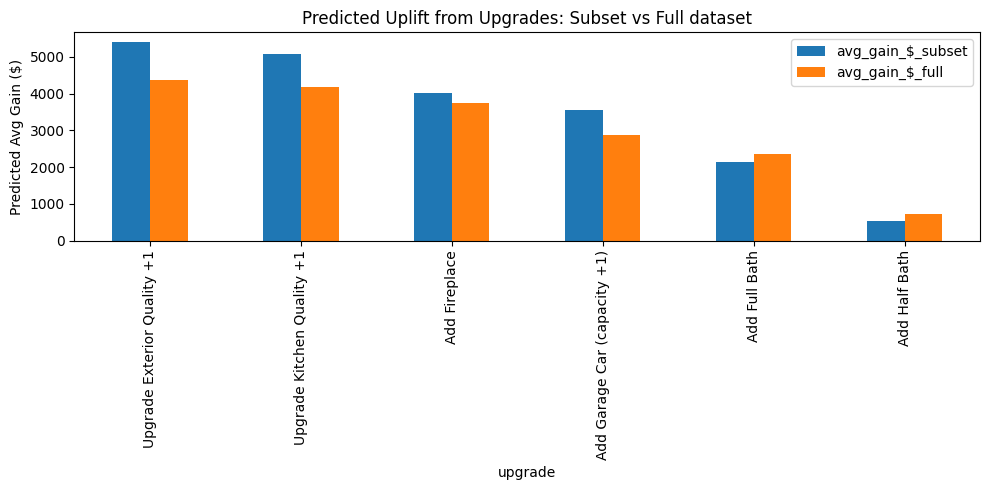

In [335]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# 0) Define the red-box subset
# -----------------------------
q80, q95 = X_fe["GrLivArea"].quantile([0.80, 0.95])
mask_subset = (
    (X_fe["GrLivArea"] >= q80) &
    (X_fe["GrLivArea"] <= q95) &
    (X_fe["OverallQual"].between(5, 7))
)
X_subset = X_fe.loc[mask_subset].copy()
print(f"Subset size: {len(X_subset)} rows (of {len(X_fe)})")

# -----------------------------
# 1) Upgrade scenarios
# -----------------------------
ORDINAL_ORDER = {
    "KitchenQual": ["Po","Fa","TA","Gd","Ex"],
    "ExterQual":   ["Po","Fa","TA","Gd","Ex"],
}
def bump_one_level(val, order):
    try:
        i = order.index(val)
        return order[min(i+1, len(order)-1)]
    except ValueError:
        return val

def apply_upgrade(df, name):
    out = df.copy()
    if name == "Add Half Bath":
        if "TotalBaths" in out.columns:
            out["TotalBaths"] = out["TotalBaths"] + 0.5
        elif "HalfBath" in out.columns:
            out["HalfBath"] = out["HalfBath"] + 1
    elif name == "Add Full Bath":
        if "TotalBaths" in out.columns:
            out["TotalBaths"] = out["TotalBaths"] + 1
        elif "FullBath" in out.columns:
            out["FullBath"] = out["FullBath"] + 1
    elif name == "Upgrade Kitchen Quality +1":
        out["KitchenQual"] = out["KitchenQual"].apply(lambda v: bump_one_level(v, ORDINAL_ORDER["KitchenQual"]))
    elif name == "Upgrade Exterior Quality +1":
        out["ExterQual"] = out["ExterQual"].apply(lambda v: bump_one_level(v, ORDINAL_ORDER["ExterQual"]))
    elif name == "Add Garage Car (capacity +1)":
        out["GarageCars"] = out["GarageCars"] + 1
    elif name == "Add Fireplace":
        out["Fireplaces"] = out["Fireplaces"] + 1
    return out

def applicable_mask(before, after):
    diff_cols = [c for c in before.columns if not before[c].equals(after[c])]
    if not diff_cols:
        return np.zeros(len(before), dtype=bool)
    return np.any([(before[c] != after[c]).to_numpy() for c in diff_cols], axis=0)

# -----------------------------
# 2) Core uplift calculator
# -----------------------------
def upgrade_gain_table(model, X, upgrades, top_k=None):
    base_pred = model.predict(X)
    rows = []
    for upg in upgrades:
        X_up = apply_upgrade(X, upg)
        pred_up = model.predict(X_up)
        delta = pred_up - base_pred
        mask = applicable_mask(X, X_up)
        if mask.sum() == 0:
            continue
        d = delta[mask]
        rows.append({
            "upgrade": upg,
            "n_applicable": int(mask.sum()),
            "avg_gain_$": float(np.mean(d)),
            "median_gain_$": float(np.median(d)),
            "p25_gain_$": float(np.percentile(d, 25)),
            "p75_gain_$": float(np.percentile(d, 75)),
        })
    df = pd.DataFrame(rows).sort_values("avg_gain_$", ascending=False).reset_index(drop=True)
    return df if top_k is None else df.head(top_k)

# -----------------------------
# 3) Run for subset vs full
# -----------------------------
UPGRADES = [
    "Add Half Bath",
    "Add Full Bath",
    "Upgrade Kitchen Quality +1",
    "Upgrade Exterior Quality +1",
    "Add Garage Car (capacity +1)",
    "Add Fireplace",
]

gain_subset = upgrade_gain_table(cat_final, X_subset, UPGRADES)
gain_full   = upgrade_gain_table(cat_final, X_fe,     UPGRADES)

# Merge side-by-side
comp = gain_subset.rename(columns=lambda c: f"{c}_subset" if c!="upgrade" else c).merge(
    gain_full.rename(columns=lambda c: f"{c}_full" if c!="upgrade" else c),
    on="upgrade"
)

display(comp)

# -----------------------------
# 4) Visualization
# -----------------------------
plot_df = comp.set_index("upgrade")[["avg_gain_$_subset", "avg_gain_$_full"]]
ax = plot_df.plot(kind="bar", figsize=(10,5))
ax.set_ylabel("Predicted Avg Gain ($)")
ax.set_title("Predicted Uplift from Upgrades: Subset vs Full dataset")
plt.tight_layout()
plt.show()

,upgrade,n_applicable_subset,avg_gain_$_subset,median_gain_$_subset,avg_gain_%_subset,median_gain_%_subset,p25_gain_%_subset,p75_gain_%_subset,n_applicable_full,avg_gain_$_full,median_gain_$_full,avg_gain_%_full,median_gain_%_full,p25_gain_%_full,p75_gain_%_full
0,Upgrade Exterior Quality +1,255,5396.417104,5254.976749,2.777177,2.492144,1.861418,3.435230,2507,4378.638370,3574.061014,2.549784,2.325388,1.674251,3.162892
1,Upgrade Kitchen Quality +1,249,5073.589925,4755.232979,2.508263,2.444040,1.655461,3.299906,2438,4188.660001,3648.721953,2.559227,2.497577,1.810749,3.193775
2,Add Fireplace,256,4026.441314,4074.758089,2.079905,2.277163,1.358043,2.890908,2580,3749.582975,3302.167873,2.351233,2.275484,1.646768,2.918011
3,Add Garage Car (capacity +1),256,3545.062476,3772.647191,1.692327,1.824532,1.049791,2.279202,2580,2879.543821,2769.240298,1.838454,1.704473,0.990955,2.523436
4,Add Full Bath,256,2144.112987,2184.515443,1.168001,1.042902,0.493178,1.613878,2580,2361.751381,2377.833152,1.515929,1.379036,0.793895,2.141226
5,Add Half Bath,256,545.251562,246.134851,0.320625,0.109912,0.000000,0.565138,2580,733.809601,519.204567,0.506039,0.321518,0.052523,0.925317


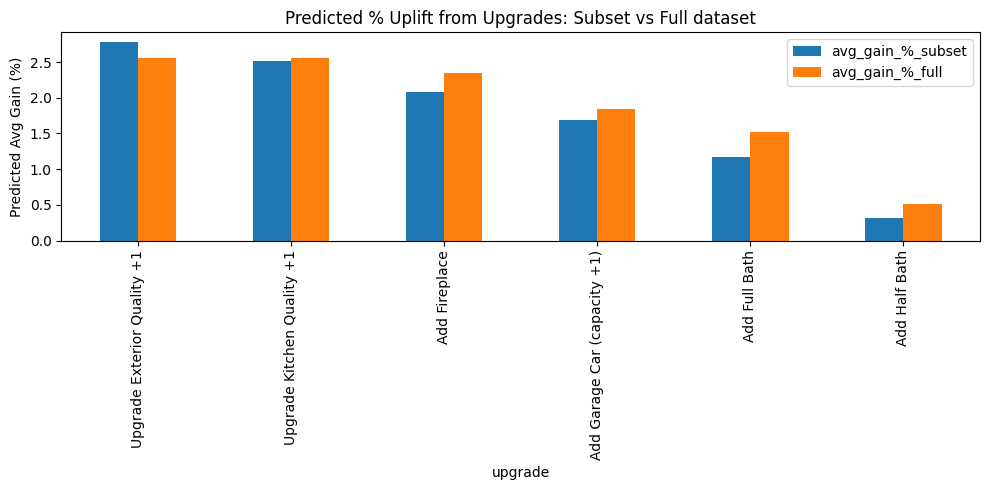

In [336]:
def upgrade_gain_table(model, X, upgrades, top_k=None):
    base_pred = model.predict(X)
    rows = []
    for upg in upgrades:
        X_up = apply_upgrade(X, upg)
        pred_up = model.predict(X_up)
        delta = pred_up - base_pred
        mask = applicable_mask(X, X_up)
        if mask.sum() == 0:
            continue
        d = delta[mask]
        base_vals = base_pred[mask]
        pct = d / base_vals * 100  # % uplift vs baseline
        rows.append({
            "upgrade": upg,
            "n_applicable": int(mask.sum()),
            "avg_gain_$": float(np.mean(d)),
            "median_gain_$": float(np.median(d)),
            "avg_gain_%": float(np.mean(pct)),
            "median_gain_%": float(np.median(pct)),
            "p25_gain_%": float(np.percentile(pct, 25)),
            "p75_gain_%": float(np.percentile(pct, 75)),
        })
    df = pd.DataFrame(rows).sort_values("avg_gain_%", ascending=False).reset_index(drop=True)
    return df if top_k is None else df.head(top_k)

# --- Run for subset vs full ---
gain_subset = upgrade_gain_table(cat_final, X_subset, UPGRADES)
gain_full   = upgrade_gain_table(cat_final, X_fe,     UPGRADES)

comp = gain_subset.rename(columns=lambda c: f"{c}_subset" if c!="upgrade" else c).merge(
    gain_full.rename(columns=lambda c: f"{c}_full" if c!="upgrade" else c),
    on="upgrade"
)

display(comp)

# --- Visualization: % uplift ---
plot_df = comp.set_index("upgrade")[["avg_gain_%_subset", "avg_gain_%_full"]]
ax = plot_df.plot(kind="bar", figsize=(10,5))
ax.set_ylabel("Predicted Avg Gain (%)")
ax.set_title("Predicted % Uplift from Upgrades: Subset vs Full dataset")
plt.tight_layout()
plt.show()

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


,upgrade,avg_gain_%_subset,avg_gain_%_full,uplift_diff_%
0,Upgrade Exterior Quality +1,2.78,2.55,0.23
1,Upgrade Kitchen Quality +1,2.51,2.56,-0.05
2,Add Garage Car (capacity +1),1.69,1.84,-0.15
3,Add Half Bath,0.32,0.51,-0.19
4,Add Fireplace,2.08,2.35,-0.27
5,Add Full Bath,1.17,1.52,-0.35


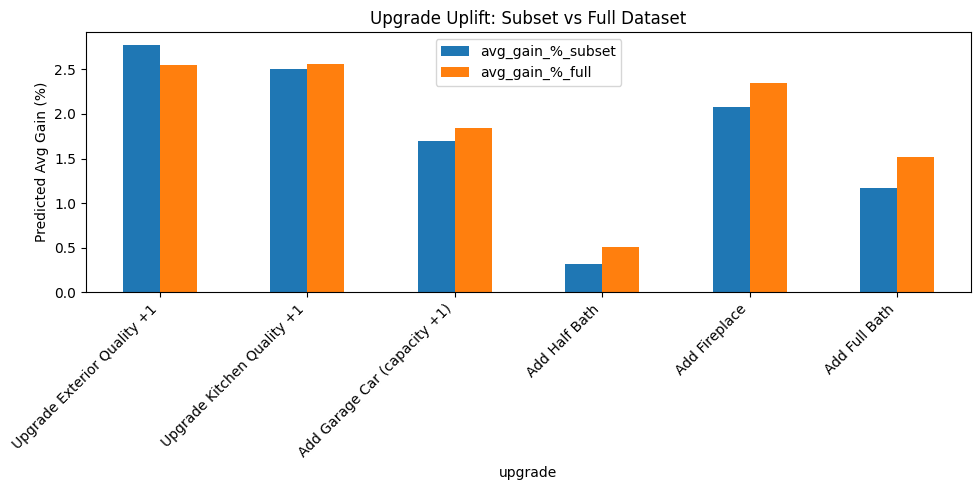

Top opportunities (subset uplift >> full):
                        upgrade  uplift_diff_%
0   Upgrade Exterior Quality +1           0.23
1    Upgrade Kitchen Quality +1          -0.05
2  Add Garage Car (capacity +1)          -0.15
3                 Add Half Bath          -0.19
4                 Add Fireplace          -0.27


In [337]:
def compare_upgrade_uplift(cat_model, X_subset, X_full, upgrades):
    gain_subset = upgrade_gain_table(cat_model, X_subset, upgrades)
    gain_full   = upgrade_gain_table(cat_model, X_full,   upgrades)

    comp = gain_subset.rename(columns=lambda c: f"{c}_subset" if c!="upgrade" else c).merge(
        gain_full.rename(columns=lambda c: f"{c}_full" if c!="upgrade" else c),
        on="upgrade"
    )

    # Calculate differential
    comp["uplift_diff_%"] = comp["avg_gain_%_subset"] - comp["avg_gain_%_full"]

    # Sort by difference (descending → subset ROI advantage)
    comp = comp.sort_values("uplift_diff_%", ascending=False).reset_index(drop=True)

    return comp

# --- Run ---
upgrade_diff = compare_upgrade_uplift(cat_final, X_subset, X_fe, UPGRADES)

# Display table
import pandas as pd
pd.set_option("display.float_format", "{:,.2f}".format)
display(upgrade_diff[["upgrade","avg_gain_%_subset","avg_gain_%_full","uplift_diff_%"]])

# --- Visualize ---
ax = upgrade_diff.set_index("upgrade")[["avg_gain_%_subset","avg_gain_%_full"]].plot(
    kind="bar", figsize=(10,5)
)
ax.set_ylabel("Predicted Avg Gain (%)")
ax.set_title("Upgrade Uplift: Subset vs Full Dataset")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Highlight upgrades with biggest subset advantage
top_diff = upgrade_diff.nlargest(5, "uplift_diff_%")
print("Top opportunities (subset uplift >> full):")
print(top_diff[["upgrade","uplift_diff_%"]])

In [339]:
import numpy as np

def bootstrap_upgrade_uplift(cat_model, X, upgrades, n_boot=200, random_state=42):
    rng = np.random.RandomState(random_state)
    results = {u["upgrade"]: [] for u in upgrades}

    for _ in range(n_boot):
        sample_idx = rng.choice(len(X), size=len(X), replace=True)
        Xb = X.iloc[sample_idx]

        gains = upgrade_gain_table(cat_model, Xb, upgrades)  # <- same table function
        for _, row in gains.iterrows():
            results[row["upgrade"]].append(row["avg_gain_%"])

    out = []
    for u, vals in results.items():
        arr = np.array(vals)
        mean = arr.mean()
        lo, hi = np.percentile(arr, [2.5, 97.5])
        out.append({"upgrade": u, "mean": mean, "ci_low": lo, "ci_high": hi})
    return pd.DataFrame(out)


def compare_with_ci(cat_model, X_subset, X_full, upgrades, n_boot=200):
    # Bootstrap both
    ci_subset = bootstrap_upgrade_uplift(cat_model, X_subset, upgrades, n_boot=n_boot)
    ci_full   = bootstrap_upgrade_uplift(cat_model, X_full,   upgrades, n_boot=n_boot)

    comp = ci_subset.rename(columns=lambda c: f"{c}_subset" if c!="upgrade" else c).merge(
        ci_full.rename(columns=lambda c: f"{c}_full" if c!="upgrade" else c),
        on="upgrade"
    )

    comp["uplift_diff_%"] = comp["mean_subset"] - comp["mean_full"]
    return comp.sort_values("uplift_diff_%", ascending=False)


# --- Run ---
upgrade_diff_ci = compare_with_ci(cat_final, X_subset, X_fe, UPGRADES, n_boot=200)

# Display
print(upgrade_diff_ci[[
    "upgrade",
    "mean_subset","ci_low_subset","ci_high_subset",
    "mean_full","ci_low_full","ci_high_full",
    "uplift_diff_%"
]])

TypeError: string indices must be integers, not 'str'

In [340]:
import numpy as np
import pandas as pd

# --- 1) A small catalog for string → spec mapping (extend as needed) ---
DEFAULT_UPGRADE_CATALOG = {
    "Extra bath":       {"feature": "TotalBaths",   "delta": 1},
    "Garage +1":        {"feature": "GarageCars",   "delta": 1},
    "Kitchen → Ex":     {"feature": "KitchenQual",  "delta": "Ex"},
    "Fireplace → 1":    {"feature": "Fireplaces",   "delta": 1},  # set to 1 if currently 0
    # add your own common labels here...
}

# --- 2) Normalizer: accepts list[str] | list[dict] | dict[str, dict] ---
def normalize_upgrades(upgrades, catalog=DEFAULT_UPGRADE_CATALOG):
    """
    Normalize upgrades into a list of dicts:
    [{"upgrade": <name>, "feature": <col>, "delta": <num or target>}, ...]
    """
    norm = []
    if isinstance(upgrades, dict):
        # {"Extra bath": {"feature":"TotalBaths","delta":1}, ...}
        for name, spec in upgrades.items():
            spec = dict(spec)
            spec["upgrade"] = name
            norm.append(spec)
    elif isinstance(upgrades, (list, tuple)):
        for item in upgrades:
            if isinstance(item, str):
                if item not in catalog:
                    raise ValueError(
                        f"Upgrade label '{item}' not in catalog. "
                        f"Add it to DEFAULT_UPGRADE_CATALOG or pass full dicts."
                    )
                spec = dict(catalog[item])
                spec["upgrade"] = item
                norm.append(spec)
            elif isinstance(item, dict):
                if "upgrade" not in item:
                    # synthesize a name if not provided
                    name = f"{item.get('feature','<feat>')}->{item.get('delta','<delta>')}"
                    d = {"upgrade": name, **item}
                else:
                    d = dict(item)
                # basic validation
                if "feature" not in d or "delta" not in d:
                    raise ValueError(f"Each upgrade dict must have 'feature' and 'delta': got {d}")
                norm.append(d)
            else:
                raise TypeError(
                    "Each upgrade must be a string label or a dict "
                    "(with 'feature' and 'delta')."
                )
    else:
        raise TypeError("UPGRADES must be a dict or list/tuple.")
    return norm

# --- 3) Apply an upgrade to a DataFrame copy (vectorized) ---
def apply_upgrade_to_df(X: pd.DataFrame, feature: str, delta):
    X1 = X.copy()
    if feature not in X1.columns:
        raise KeyError(f"Feature '{feature}' not in DataFrame.")
    # numeric delta: add; string delta: set to that level/value
    if np.issubdtype(np.array([delta]).dtype, np.number):
        # if feature is numeric: add delta. If it's categorical/obj but numeric-like, try to coerce
        if pd.api.types.is_numeric_dtype(X1[feature]):
            X1[feature] = X1[feature] + delta
        else:
            # For non-numeric column a numeric delta is ambiguous; fallback: leave unchanged
            # or implement your own rule here.
            pass
    else:
        # treat as "set to explicit target value"
        X1[feature] = delta
    return X1

# --- 4) Compute uplift table for a set of upgrades on a given sample X ---
def upgrade_gain_table(model, X: pd.DataFrame, upgrades):
    """
    Returns DataFrame with columns:
      upgrade, n, base_mean, new_mean, avg_gain, avg_gain_%
    """
    upgrades = normalize_upgrades(upgrades)
    base_pred = model.predict(X)
    base_mean = base_pred.mean()

    rows = []
    for u in upgrades:
        feat, delta, name = u["feature"], u["delta"], u["upgrade"]
        X1 = apply_upgrade_to_df(X, feat, delta)
        new_pred = model.predict(X1)
        gain = new_pred - base_pred
        rows.append({
            "upgrade":    name,
            "n":          len(X),
            "base_mean":  base_mean,
            "new_mean":   new_pred.mean(),
            "avg_gain":   gain.mean(),
            "avg_gain_%": 100.0 * (gain / base_pred).mean()
        })
    return pd.DataFrame(rows)

# --- 5) Bootstrap CIs for avg_gain_% for each upgrade on a sample X ---
def bootstrap_upgrade_uplift(model, X: pd.DataFrame, upgrades, n_boot=200, random_state=42):
    rng = np.random.RandomState(random_state)
    upgrades = normalize_upgrades(upgrades)
    names = [u["upgrade"] for u in upgrades]
    buckets = {name: [] for name in names}

    for _ in range(n_boot):
        idx = rng.choice(len(X), size=len(X), replace=True)
        Xb = X.iloc[idx]
        tbl = upgrade_gain_table(model, Xb, upgrades)
        for _, row in tbl.iterrows():
            buckets[row["upgrade"]].append(row["avg_gain_%"])

    out = []
    for name in names:
        arr = np.asarray(buckets[name], dtype=float)
        out.append({
            "upgrade": name,
            "mean":    arr.mean(),
            "ci_low":  np.percentile(arr, 2.5),
            "ci_high": np.percentile(arr, 97.5),
        })
    return pd.DataFrame(out)

# --- 6) Compare subset vs full with CIs ---
def compare_with_ci(model, X_subset, X_full, upgrades, n_boot=200):
    ci_subset = bootstrap_upgrade_uplift(model, X_subset, upgrades, n_boot=n_boot)
    ci_full   = bootstrap_upgrade_uplift(model, X_full,   upgrades, n_boot=n_boot)

    comp = ci_subset.rename(columns=lambda c: f"{c}_subset" if c != "upgrade" else c).merge(
        ci_full.rename(columns=lambda c: f"{c}_full" if c != "upgrade" else c),
        on="upgrade"
    )
    comp["uplift_diff_%"] = comp["mean_subset"] - comp["mean_full"]
    return comp.sort_values("uplift_diff_%", ascending=False)

In [341]:
# Example UPGRADES as simple labels (strings):
UPGRADES = ["Extra bath", "Garage +1", "Kitchen → Ex"]

# OR list of dicts (works too):
# UPGRADES = [
#     {"upgrade": "Extra bath", "feature": "TotalBaths",  "delta": 1},
#     {"upgrade": "Garage +1",  "feature": "GarageCars",  "delta": 1},
#     {"upgrade": "Kitchen → Ex","feature":"KitchenQual", "delta": "Ex"},
# ]

# Make sure cat_final is your fitted Pipeline (prep -> CatBoostRegressor)
# Make sure X_subset and X_fe are the subset and full feature DataFrames

upgrade_diff_ci = compare_with_ci(cat_final, X_subset, X_fe, UPGRADES, n_boot=200)

# Nice, readable view:
cols = [
    "upgrade",
    "mean_subset","ci_low_subset","ci_high_subset",
    "mean_full","ci_low_full","ci_high_full",
    "uplift_diff_%"
]
display(upgrade_diff_ci[cols])

# If you also want the plain (non-CI) uplift table for quick ranking:
subset_table = upgrade_gain_table(cat_final, X_subset, UPGRADES).sort_values("avg_gain_%", ascending=False)
full_table   = upgrade_gain_table(cat_final, X_fe,     UPGRADES).sort_values("avg_gain_%", ascending=False)
display(subset_table)
display(full_table)

,upgrade,mean_subset,ci_low_subset,ci_high_subset,mean_full,ci_low_full,ci_high_full,uplift_diff_%
1,Garage +1,1.69,1.59,1.79,1.84,1.79,1.89,-0.15
0,Extra bath,1.17,1.07,1.28,1.52,1.47,1.56,-0.35
2,Kitchen → Ex,3.28,3.09,3.47,3.92,3.83,4.05,-0.64


,upgrade,n,base_mean,new_mean,avg_gain,avg_gain_%
2,Kitchen → Ex,256,"207,887.21","214,234.56","6,347.35",3.27
1,Garage +1,256,"207,887.21","211,432.27","3,545.06",1.69
0,Extra bath,256,"207,887.21","210,031.32","2,144.11",1.17


,upgrade,n,base_mean,new_mean,avg_gain,avg_gain_%
2,Kitchen → Ex,2580,"178,059.89","183,888.00","5,828.11",3.93
1,Garage +1,2580,"178,059.89","180,939.43","2,879.54",1.84
0,Extra bath,2580,"178,059.89","180,421.64","2,361.75",1.52


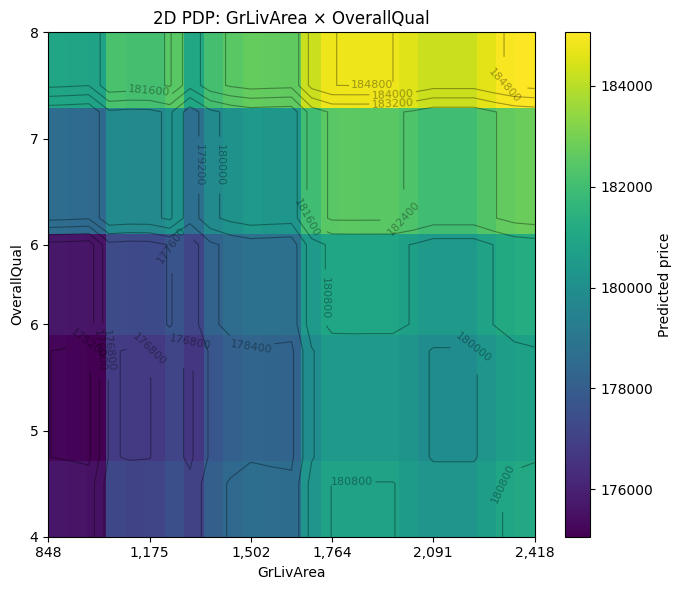

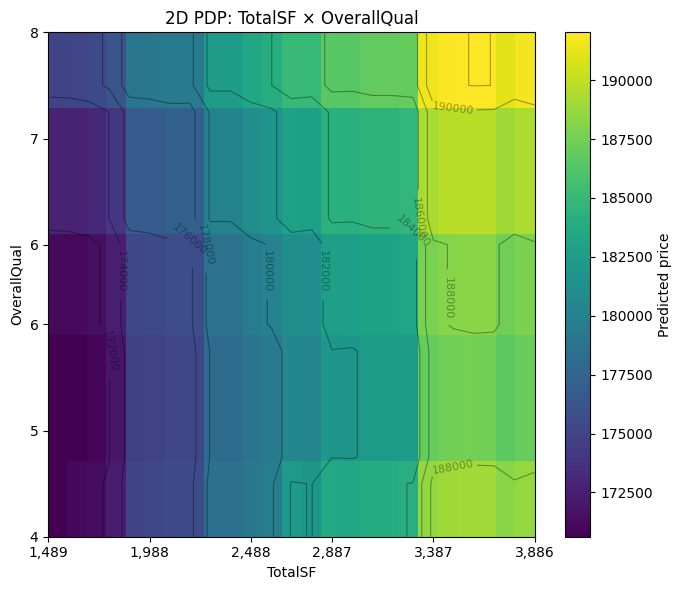

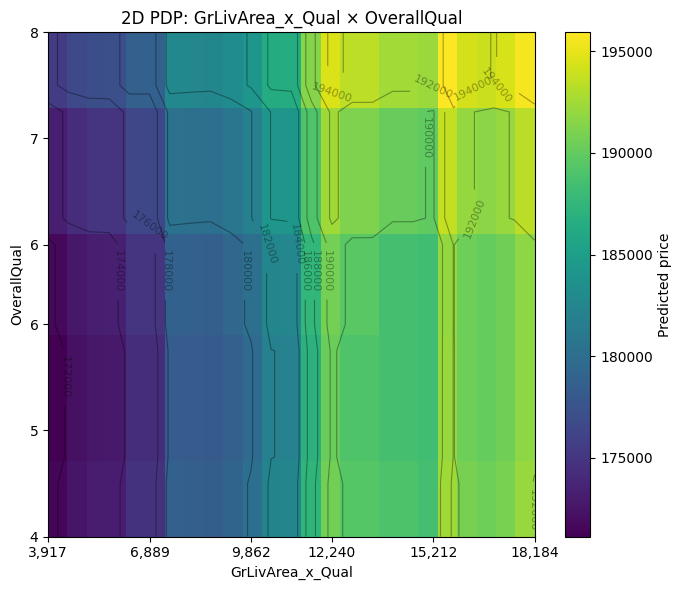

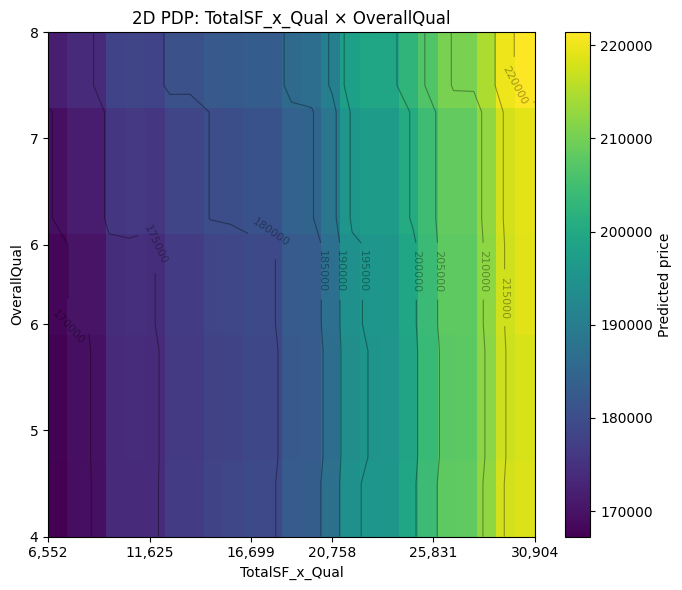

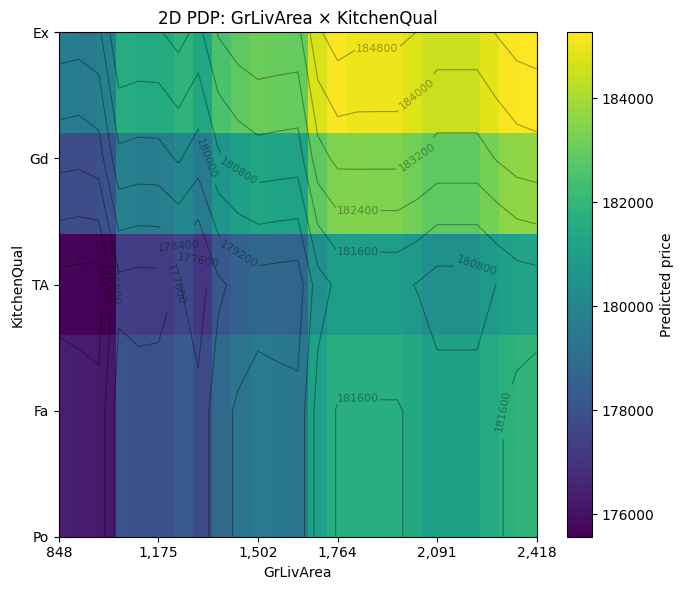

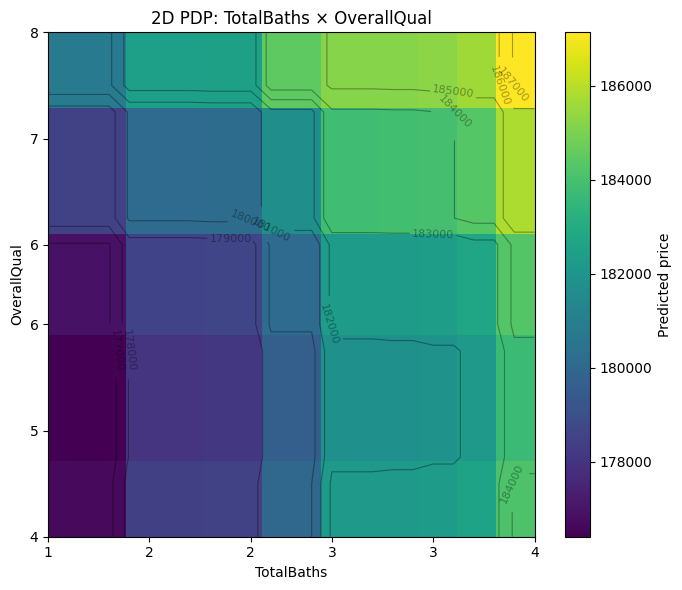

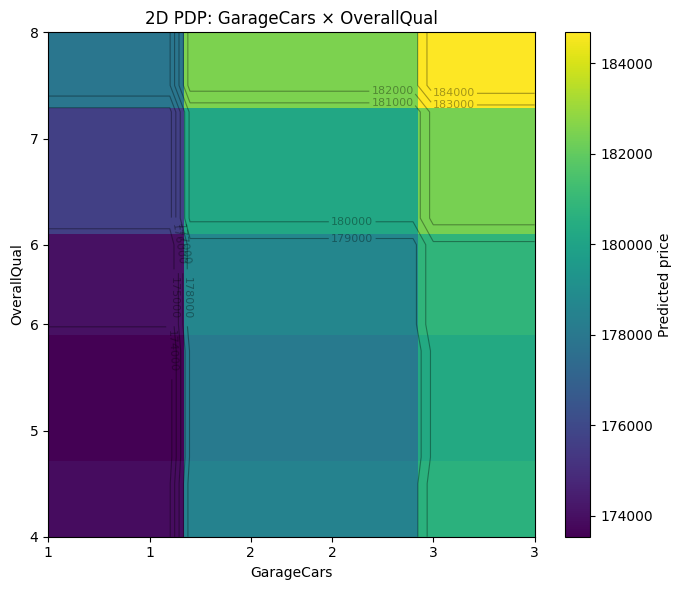

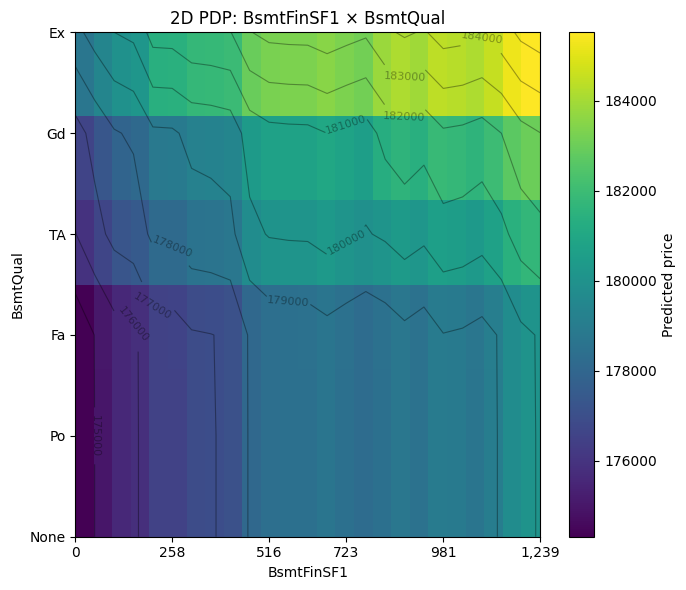

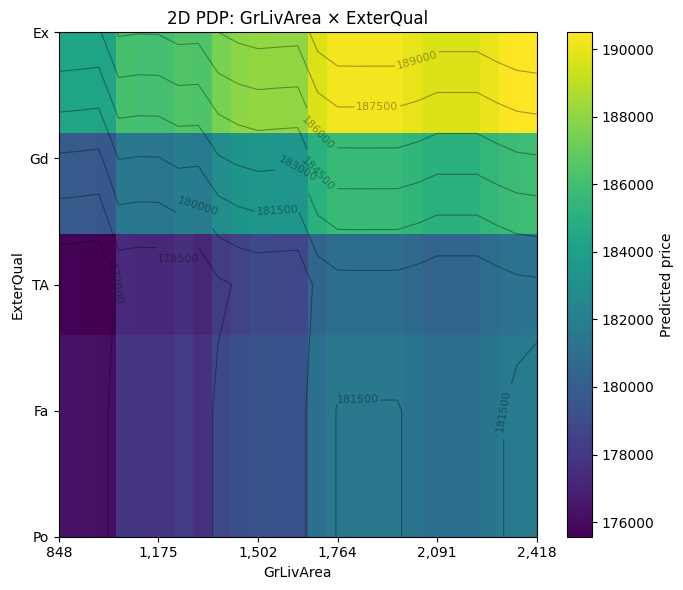

In [379]:
# --- choose pairs likely to reveal flipper/remodel opportunities ---
CANDIDATE_PAIRS = [
    # Size × quality
    ("GrLivArea",        "OverallQual"),
    ("TotalSF",          "OverallQual"),
    ("GrLivArea_x_Qual", "OverallQual"),   # if you kept this engineered feature
    ("TotalSF_x_Qual",   "OverallQual"),

    # Kitchens / baths / garage (classic value levers)
    ("GrLivArea",  "KitchenQual"),
    ("TotalBaths", "OverallQual"),
    ("GarageCars", "OverallQual"),

    # Optional basement/finish quality, if present
    ("BsmtFinSF1", "BsmtQual"),
    ("GrLivArea",  "ExterQual"),
]

# --- utility: plot all pairs, auto-select n_y for ordinals, save/skip gracefully ---
import os
import numpy as np
import pandas as pd

def _get_prep(estimator):
    if hasattr(estimator, "regressor_"):
        pipe = estimator.regressor_
    else:
        pipe = estimator
    return pipe.named_steps["prep"]

def _ordinal_mapping_from_prep(prep):
    mapping = {}
    for name, trans, cols in prep.transformers_:
        if name not in ("ordinal", "elect"):
            continue
        enc = trans.named_steps.get("ordinal", None) if hasattr(trans, "named_steps") else None
        if enc is None or not hasattr(enc, "categories_"):
            continue
        for j, col in enumerate(cols):
            mapping[col] = list(enc.categories_[j])
    return mapping

def plot_opportunity_heatmaps(
    model,
    X: pd.DataFrame,
    pairs,
    outdir=None,
    default_nx=25,
    default_ny=20,
    ny_cap=12,      # cap categorical levels shown (keeps plots readable)
    q_lo=0.05, q_hi=0.95,
):
    prep = _get_prep(model)
    ord_map = _ordinal_mapping_from_prep(prep)

    if outdir:
        os.makedirs(outdir, exist_ok=True)

    made_any = False
    for fx, fy in pairs:
        if fx not in X.columns or fy not in X.columns:
            print(f"[skip] Missing columns: ({fx}, {fy})")
            continue

        # choose n_y: ordinal -> exact #categories (capped), else default
        if fy in ord_map:
            n_y = min(len(ord_map[fy]), ny_cap)
            n_y = max(n_y, 3)  # keep at least a few bands
        else:
            # if categorical but not in ord_map, use #unique (capped), else default
            if not pd.api.types.is_numeric_dtype(X[fy]):
                n_y = min(X[fy].nunique(), ny_cap)
                n_y = max(n_y, 3)
            else:
                n_y = default_ny

        # plot
        try:
            result = pdp_2d_heatmap(
                model, X,
                feat_x=fx, feat_y=fy,
                n_x=default_nx, n_y=n_y,
                q_lo=q_lo, q_hi=q_hi,
                show_contours=True, levels=12,
                return_data=False
            )
            made_any = True
            if outdir:
                # Save the last created figure
                import matplotlib.pyplot as plt
                fname = f"pdp2d_{fx}__{fy}.png".replace("/", "-")
                plt.savefig(os.path.join(outdir, fname), dpi=160, bbox_inches="tight")
                print(f"[saved] {fname}")
        except Exception as e:
            print(f"[error] ({fx}, {fy}): {e}")

    if not made_any:
        print("No plots created (all pairs missing or errors).")

# ---- run it ----
plot_opportunity_heatmaps(
    cat_final,         # your fitted CatBoost pipeline
    X_fe,              # your modeling frame
    CANDIDATE_PAIRS,
    outdir=None,       # or e.g. "figs/pdp_flipper_opps"
    default_nx=25,
    default_ny=20,
    ny_cap=12
)

In [408]:
import numpy as np
import pandas as pd

# --- Configure which upgrades to test (edit freely) ---
# Uses your ORDINAL_ORDER from earlier for categorical "max" levels.
UPGRADES = {
    # categorical -> force to best label
    "Kitchen → Ex": {"type": "to_max", "col": "KitchenQual"},
    "ExterQual → Ex": {"type": "to_max", "col": "ExterQual"},
    "FireplaceQu +1 step": {"type": "step_up", "col": "FireplaceQu", "steps": 1},
    "BsmtQual +1 step": {"type": "step_up", "col": "BsmtQual", "steps": 1},
    "HeatingQC +1 step": {"type": "step_up", "col": "HeatingQC", "steps": 1},
    # numeric -> add delta
    "TotalBaths +1": {"type": "add", "col": "TotalBaths", "delta": 1.0},
    "GarageCars +1": {"type": "add", "col": "GarageCars", "delta": 1.0},
}

# --- Helpers to apply upgrades on a copy of X ---
def _cat_to_max(x: pd.Series, col: str, ordinal_map: dict) -> pd.Series:
    if col not in ordinal_map:  # fall back to mode "max" (sorted by frequency)
        # If not in known ordinals, leave as is
        return x
    best = ordinal_map[col][-1]  # last entry is best (e.g., 'Ex')
    return pd.Series(np.where(x.notna(), best, x), index=x.index, dtype=x.dtype)

def _cat_step_up(x: pd.Series, col: str, steps: int, ordinal_map: dict) -> pd.Series:
    if col not in ordinal_map:
        return x
    cats = ordinal_map[col]
    pos = x.map({c:i for i,c in enumerate(cats)}).astype("float")
    # if unseen category -> leave as is
    pos = pos.where(pos.notna(), other=pos)  # keep NaNs
    new_pos = pos + steps
    new_pos = new_pos.clip(upper=len(cats)-1)  # cap at max
    # For rows with NaN pos (unseen), keep original
    # Build a safe mapping back
    new_vals = new_pos.round().astype("Int64").map({i:c for i,c in enumerate(cats)})
    return x.where(pos.isna(), new_vals)

def _num_add(x: pd.Series, delta: float) -> pd.Series:
    return (x.astype(float) + float(delta)).astype(x.dtype if pd.api.types.is_integer_dtype(x.dtype)==False else "float64")

def apply_upgrade_frame(X: pd.DataFrame, key: str, spec: dict, ordinal_map: dict) -> pd.DataFrame:
    """Return a *new* DataFrame with the upgrade applied to column(s) specified in spec."""
    if spec["type"] in ("to_max", "step_up", "add"):
        col = spec["col"]
        if col not in X.columns:
            # if the engineered column isn't present, just return X as-is
            return X.copy()
        X_new = X.copy()
        if spec["type"] == "to_max":
            X_new[col] = _cat_to_max(X_new[col], col, ordinal_map)
        elif spec["type"] == "step_up":
            steps = int(spec.get("steps", 1))
            X_new[col] = _cat_step_up(X_new[col], col, steps, ordinal_map)
        elif spec["type"] == "add":
            delta = float(spec.get("delta", 1.0))
            X_new[col] = _num_add(X_new[col], delta)
        return X_new
    else:
        raise ValueError(f"Unknown upgrade type: {spec['type']}")

# --- Core evaluator ---
def evaluate_upgrades(model, X: pd.DataFrame, upgrades: dict, clip_base: float = 1.0) -> pd.DataFrame:
    """
    For each upgrade:
      - predict baseline and upgraded prices
      - compute absolute and % uplift
    Returns a ranked DataFrame (by % uplift).
    """
    # Baseline predictions
    base_pred = model.predict(X)
    base_pred = np.asarray(base_pred, dtype=float)
    base_safe = np.clip(base_pred, clip_base, None)

    rows = []
    for name, spec in upgrades.items():
        X_new = apply_upgrade_frame(X, name, spec, ORDINAL_ORDER)
        new_pred = model.predict(X_new).astype(float)

        gain = new_pred - base_pred
        gain_pct = (gain / base_safe) * 100.0

        rows.append({
            "upgrade": name,
            "n": len(X),
            "base_mean": float(base_pred.mean()),
            "new_mean": float(new_pred.mean()),
            "avg_gain": float(gain.mean()),
            "avg_gain_%": float(gain_pct.mean()),
            "median_gain_%": float(np.median(gain_pct)),
            "p75_gain_%": float(np.percentile(gain_pct, 75)),
            "p90_gain_%": float(np.percentile(gain_pct, 90)),
        })

    out = pd.DataFrame(rows).sort_values("avg_gain_%", ascending=False).reset_index(drop=True)

    # Prettier formatting preview (optional)
    display_cols = ["upgrade","n","base_mean","new_mean","avg_gain","avg_gain_%","median_gain_%","p75_gain_%","p90_gain_%"]
    try:
        from IPython.display import display
        display(out[display_cols])
    except Exception:
        pass
    return out

# --- (Optional) Bootstrap CIs for each upgrade's % uplift ---
def evaluate_upgrades_bootstrap(model, X: pd.DataFrame, upgrades: dict, n_boot=200, random_state=42, clip_base=1.0) -> pd.DataFrame:
    rng = np.random.RandomState(random_state)
    base_pred = model.predict(X).astype(float)
    base_safe = np.clip(base_pred, clip_base, None)

    rows = []
    for name, spec in upgrades.items():
        X_new = apply_upgrade_frame(X, name, spec, ORDINAL_ORDER)
        new_pred_all = model.predict(X_new).astype(float)
        gain_pct_all = ((new_pred_all - base_pred) / base_safe) * 100.0

        # bootstrap mean(gain_%)
        means = []
        n = len(X)
        for _ in range(n_boot):
            idx = rng.choice(n, size=n, replace=True)
            means.append(float(np.mean(gain_pct_all[idx])))
        ci_low, ci_high = np.percentile(means, [2.5, 97.5])

        rows.append({
            "upgrade": name,
            "mean_%": float(np.mean(gain_pct_all)),
            "ci_low_%": float(ci_low),
            "ci_high_%": float(ci_high),
        })
    df_ci = pd.DataFrame(rows).sort_values("mean_%", ascending=False).reset_index(drop=True)
    return df_ci

# ======== USAGE ========
# cat_final: your fitted pipeline (prep -> CatBoost)
# X_fe: your full engineered DataFrame (same columns the pipeline expects)

upgrade_table = evaluate_upgrades(cat_final, X_fe, UPGRADES)
print("\nRanked upgrades (whole dataset):")
print(upgrade_table[["upgrade","avg_gain_%","avg_gain","base_mean","new_mean","median_gain_%","p75_gain_%","p90_gain_%"]])

# Optional: add uncertainty bars (slower)
upgrade_ci = evaluate_upgrades_bootstrap(cat_final, X_fe, UPGRADES, n_boot=200)
print("\nBootstrap CIs for avg % uplift:")
print(upgrade_ci)

,upgrade,n,base_mean,new_mean,avg_gain,avg_gain_%,median_gain_%,p75_gain_%,p90_gain_%
0,ExterQual → Ex,2580,"178,059.89","185,840.72","7,780.83",5.34,4.61,7.12,9.54
1,Kitchen → Ex,2580,"178,059.89","183,888.00","5,828.11",3.93,3.52,4.99,6.81
2,GarageCars +1,2580,"178,059.89","180,939.43","2,879.54",1.84,1.70,2.52,3.41
3,TotalBaths +1,2580,"178,059.89","180,421.64","2,361.75",1.52,1.38,2.14,2.71
4,FireplaceQu +1 step,2580,"178,059.89","178,059.89",0.00,0.00,0.00,0.00,0.00
5,BsmtQual +1 step,2580,"178,059.89","178,059.89",0.00,0.00,0.00,0.00,0.00
6,HeatingQC +1 step,2580,"178,059.89","178,059.89",0.00,0.00,0.00,0.00,0.00



Ranked upgrades (whole dataset):
               upgrade  avg_gain_%  avg_gain  base_mean   new_mean  \
0       ExterQual → Ex        5.34  7,780.83 178,059.89 185,840.72   
1         Kitchen → Ex        3.93  5,828.11 178,059.89 183,888.00   
2        GarageCars +1        1.84  2,879.54 178,059.89 180,939.43   
3        TotalBaths +1        1.52  2,361.75 178,059.89 180,421.64   
4  FireplaceQu +1 step        0.00      0.00 178,059.89 178,059.89   
5     BsmtQual +1 step        0.00      0.00 178,059.89 178,059.89   
6    HeatingQC +1 step        0.00      0.00 178,059.89 178,059.89   

   median_gain_%  p75_gain_%  p90_gain_%  
0           4.61        7.12        9.54  
1           3.52        4.99        6.81  
2           1.70        2.52        3.41  
3           1.38        2.14        2.71  
4           0.00        0.00        0.00  
5           0.00        0.00        0.00  
6           0.00        0.00        0.00  

Bootstrap CIs for avg % uplift:
               upgrade  mean

In [409]:
# ===== Build an expanded UPGRADES list for flip/remodel opportunities =====

def _mk(step_label, col, *, kind="to_max", steps=1, delta=None):
    if kind == "to_max":
        return (f"{col} → best ({step_label})", {"type": "to_max", "col": col})
    if kind == "step_up":
        return (f"{col} +{steps} step", {"type": "step_up", "col": col, "steps": steps})
    if kind == "add":
        return (f"{col} +{delta}", {"type": "add", "col": col, "delta": delta})
    raise ValueError

def build_upgrade_scenarios(X, ordinal_order):
    """Return a dict of candidate upgrades; automatically filtered to columns present in X."""
    candidates = []

    # --- High-impact interior/exterior quality knobs (ordinal) ---
    for c in ["KitchenQual","ExterQual","ExterCond","HeatingQC","FireplaceQu",
              "BsmtQual","BsmtCond","BsmtExposure","GarageFinish","GarageQual",
              "GarageCond","Functional","PavedDrive","Electrical"]:
        if c in X.columns:
            # Force to max grade
            candidates.append(_mk("max", c, kind="to_max"))
            # Also a modest +1 step option where ordinal makes sense
            if c in ordinal_order:
                candidates.append(_mk("step", c, kind="step_up", steps=1))

    # --- Outdoor / curb-appeal (if present) ---
    for c in ["PoolQC","Fence"]:
        if c in X.columns and c in ordinal_order:
            candidates.append(_mk("max", c, kind="to_max"))
            candidates.append(_mk("step", c, kind="step_up", steps=1))

    # --- Numeric “additions” (light-touch, interpretable deltas) ---
    numeric_adds = [
        ("TotalBaths", 1.0),
        ("GarageCars", 1.0),
        ("GarageArea", 100.0),
        ("WoodDeckSF", 100.0),
        ("OpenPorchSF", 50.0),
        ("EnclosedPorch", 50.0),
        ("ScreenPorch", 50.0),
        ("TotalSF", 200.0),
    ]
    for col, delta in numeric_adds:
        if col in X.columns:
            candidates.append(_mk(None, col, kind="add", delta=delta))

    # Keep only features that truly exist in X
    upgrades = {}
    for name, spec in candidates:
        if spec["col"] in X.columns:
            upgrades[name] = spec
    return upgrades

# Build from your data
UPGRADES_EXPANDED = build_upgrade_scenarios(X_fe, ORDINAL_ORDER)

# Quick peek at what we’ll evaluate
print(f"{len(UPGRADES_EXPANDED)} upgrade scenarios detected:")
for k in list(UPGRADES_EXPANDED.keys())[:15]:
    print(" •", k)
if len(UPGRADES_EXPANDED) > 15:
    print(" • …")

# ===== Evaluate (whole dataset) =====
upgrade_table_full = evaluate_upgrades(cat_final, X_fe, UPGRADES_EXPANDED)

# Nicely formatted summary (top 15 by % uplift)
cols_show = ["upgrade","avg_gain_%","avg_gain","base_mean","new_mean","median_gain_%","p75_gain_%","p90_gain_%"]
print("\nTop upgrade candidates by % uplift (whole dataset):")
display(upgrade_table_full.sort_values("avg_gain_%", ascending=False).head(15)[cols_show])

# (Optional) Bootstrap confidence intervals for avg % uplift — enable if you want uncertainty bars.
# upgrade_ci_full = evaluate_upgrades_bootstrap(cat_final, X_fe, UPGRADES_EXPANDED, n_boot=200)
# display(upgrade_ci_full.head(15))

24 upgrade scenarios detected:
 • KitchenQual → best (max)
 • KitchenQual +1 step
 • ExterQual → best (max)
 • ExterQual +1 step
 • ExterCond → best (max)
 • HeatingQC → best (max)
 • FireplaceQu → best (max)
 • BsmtQual → best (max)
 • BsmtCond → best (max)
 • BsmtExposure → best (max)
 • GarageFinish → best (max)
 • GarageQual → best (max)
 • GarageCond → best (max)
 • Functional → best (max)
 • PavedDrive → best (max)
 • …


,upgrade,n,base_mean,new_mean,avg_gain,avg_gain_%,median_gain_%,p75_gain_%,p90_gain_%
0,ExterQual → best (max),2580,"178,059.89","185,840.72","7,780.83",5.34,4.61,7.12,9.54
1,KitchenQual → best (max),2580,"178,059.89","183,888.00","5,828.11",3.93,3.52,4.99,6.81
2,ExterQual +1 step,2580,"178,059.89","182,314.64","4,254.75",2.48,2.29,3.14,4.12
3,KitchenQual +1 step,2580,"178,059.89","182,018.01","3,958.12",2.42,2.41,3.14,3.88
4,GarageCars +1.0,2580,"178,059.89","180,939.43","2,879.54",1.84,1.70,2.52,3.41
5,TotalBaths +1.0,2580,"178,059.89","180,421.64","2,361.75",1.52,1.38,2.14,2.71
6,TotalSF +200.0,2580,"178,059.89","179,662.12","1,602.23",1.01,0.91,1.64,2.16
7,WoodDeckSF +100.0,2580,"178,059.89","179,027.76",967.87,0.58,0.24,1.05,1.97
8,GarageArea +100.0,2580,"178,059.89","178,849.96",790.07,0.46,0.45,0.86,1.43
9,OpenPorchSF +50.0,2580,"178,059.89","178,701.69",641.79,0.42,0.32,0.74,1.23



Top upgrade candidates by % uplift (whole dataset):


,upgrade,avg_gain_%,avg_gain,base_mean,new_mean,median_gain_%,p75_gain_%,p90_gain_%
0,ExterQual → best (max),5.34,"7,780.83","178,059.89","185,840.72",4.61,7.12,9.54
1,KitchenQual → best (max),3.93,"5,828.11","178,059.89","183,888.00",3.52,4.99,6.81
2,ExterQual +1 step,2.48,"4,254.75","178,059.89","182,314.64",2.29,3.14,4.12
3,KitchenQual +1 step,2.42,"3,958.12","178,059.89","182,018.01",2.41,3.14,3.88
4,GarageCars +1.0,1.84,"2,879.54","178,059.89","180,939.43",1.70,2.52,3.41
5,TotalBaths +1.0,1.52,"2,361.75","178,059.89","180,421.64",1.38,2.14,2.71
6,TotalSF +200.0,1.01,"1,602.23","178,059.89","179,662.12",0.91,1.64,2.16
7,WoodDeckSF +100.0,0.58,967.87,"178,059.89","179,027.76",0.24,1.05,1.97
8,GarageArea +100.0,0.46,790.07,"178,059.89","178,849.96",0.45,0.86,1.43
9,OpenPorchSF +50.0,0.42,641.79,"178,059.89","178,701.69",0.32,0.74,1.23


In [413]:
# 1) Drop interaction features (errors='ignore' keeps this robust)
cols_to_drop = [
    "GrLivArea_x_Qual", "TotalSF_x_Qual",
    "LargeHomeFlag", "GrLivArea_large", "GrLivArea_bin"
]
X_no_interact = X_fe.drop(columns=cols_to_drop, errors="ignore")
print("Reduced schema:", X_no_interact.shape)

# 2) Build & fit a CatBoost pipeline on the reduced schema
#    (use the good params you found during tuning)
cat_no_interact = make_catboost_pipe(
    X_no_interact,
    depth=5,
    learning_rate=0.059,         # from your refined search
    l2_leaf_reg=1.5,
    n_estimators=1300,
    subsample=0.75,
    colsample_bylevel=0.85,
    random_state=42,
    verbose=0,
    thread_count=-1
)
cat_no_interact.fit(X_no_interact, y)

# 3) Define upgrades in the expected {"feature","delta","upgrade"} format
UPGRADES = [
    {"feature": "ExterQual",   "delta": +1,    "upgrade": "ExterQual +1 step"},
    {"feature": "KitchenQual", "delta": +1,    "upgrade": "KitchenQual +1 step"},
    {"feature": "GarageCars",  "delta": +1.0,  "upgrade": "Garage +1"},
    {"feature": "TotalBaths",  "delta": +1.0,  "upgrade": "TotalBaths +1.0"},
    {"feature": "TotalSF",     "delta": +200., "upgrade": "TotalSF +200"},
    {"feature": "WoodDeckSF",  "delta": +100., "upgrade": "WoodDeck +100"},
    {"feature": "GarageArea",  "delta": +100., "upgrade": "GarageArea +100"},
    {"feature": "OpenPorchSF", "delta": +50.,  "upgrade": "OpenPorch +50"},
    {"feature": "ScreenPorch", "delta": +50.,  "upgrade": "ScreenPorch +50"},
]

# 4) Re-run your bootstrap comparison on the reduced model & data
upgrade_ci_no_interact = compare_with_ci(
    model=cat_no_interact,
    X_subset=X_no_interact,   # if you later want the red-box slice, pass that slice instead
    X_full=X_no_interact,
    upgrades=UPGRADES,
    n_boot=200
)

# 5) View results
cols_to_show = [
    "upgrade",
    "mean_full","ci_low_full","ci_high_full",
    "uplift_diff_%"
]
print(upgrade_ci_no_interact[cols_to_show].sort_values("mean_full", ascending=False))

Reduced schema: (2580, 86)


KeyError: 'Electrical'

In [416]:
ORDINAL_ORDER.setdefault("Electrical", ["Mix","FuseP","FuseF","FuseA","SBrkr"])

['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr']

In [417]:
X_no_interact = X_fe.drop(columns=["GrLivArea_x_Qual","TotalSF_x_Qual","LargeHomeFlag",
                                   "GrLivArea_large","GrLivArea_bin","Electrical"], errors="ignore")

In [419]:
import numpy as np
import pandas as pd

# ---- helpers to recognize/operate on ordinals ----
def _is_ordinal(col: str) -> bool:
    return ("ORDINAL_ORDER" in globals()) and (col in ORDINAL_ORDER)

def _ordinal_categories(col: str):
    if not _is_ordinal(col):
        raise ValueError(f"Feature '{col}' is not registered in ORDINAL_ORDER.")
    return list(ORDINAL_ORDER[col])

def _ordinal_step_series(s: pd.Series, delta: int, cats: list[str]) -> pd.Series:
    # Map labels -> indices -> add delta -> clip -> map back to labels
    idx = s.map({c:i for i,c in enumerate(cats)}).fillna(-1).astype(int)
    idx = np.clip(idx + int(delta), 0, len(cats)-1)
    back = pd.Series(idx, index=s.index).map({i:c for i,c in enumerate(cats)})
    return back.astype(s.dtype) if str(s.dtype).startswith("category") else back

def _ordinal_to_best_series(s: pd.Series, cats: list[str]) -> pd.Series:
    best = cats[-1]
    out = pd.Series(best, index=s.index)
    return out.astype(s.dtype) if str(s.dtype).startswith("category") else out

# ---- upgrade normalization ----
def normalize_upgrades(upgrades):
    """
    Accepts a list like:
      - {"feature":"KitchenQual","delta":+1,"upgrade":"KitchenQual +1 step"}
      - {"feature":"ExterQual","to":"best","upgrade":"ExterQual → best (max)"}
    Returns a normalized list with an 'action' field: 'delta' | 'to_best'.
    """
    norm = []
    for u in upgrades:
        d = dict(u)
        if "feature" not in d:
            raise ValueError(f"Upgrade missing 'feature': {u}")
        if "delta" in d and "to" in d:
            raise ValueError(f"Use either 'delta' or 'to', not both: {u}")
        if "delta" in d:
            d["action"] = "delta"
            norm.append(d)
        elif d.get("to", None) == "best":
            d["action"] = "to_best"
            norm.append(d)
        else:
            raise ValueError(
                f"Each upgrade must have 'delta' or 'to': 'best'. Got {u}"
            )
    return norm

# ---- apply a single upgrade to a DataFrame copy ----
def apply_upgrade_once(X: pd.DataFrame, upg: dict) -> pd.DataFrame:
    col = upg["feature"]; action = upg["action"]
    if col not in X.columns:
        raise ValueError(f"Feature '{col}' not found in X columns.")
    X2 = X.copy()

    if action == "delta":
        delta = upg["delta"]
        if _is_ordinal(col):
            cats = _ordinal_categories(col)
            X2[col] = _ordinal_step_series(X[col], delta, cats)
        else:
            # numeric add; if non-numeric & not ordinal -> error
            if pd.api.types.is_numeric_dtype(X[col]):
                X2[col] = X[col] + delta
            else:
                raise ValueError(
                    f"Delta not supported for non-numeric, non-ordinal feature '{col}'."
                )
    elif action == "to_best":
        # only meaningful for ordinals
        if not _is_ordinal(col):
            raise ValueError(f"'to: best' only supported for ordinal feature '{col}'.")
        cats = _ordinal_categories(col)
        X2[col] = _ordinal_to_best_series(X[col], cats)
    else:
        raise ValueError(f"Unknown action '{action}' in upgrade {upg}.")
    return X2

# ---- compute gain table for a set of upgrades ----
def upgrade_gain_table(model, X: pd.DataFrame, upgrades):
    """
    Returns:
      upgrade, n, base_mean, new_mean, avg_gain, avg_gain_%, median_gain_%, p75_gain_%, p90_gain_%
    """
    ups = normalize_upgrades(upgrades)
    base_pred = model.predict(X)
    base_mean = float(np.mean(base_pred))

    rows = []
    for u in ups:
        X_new = apply_upgrade_once(X, u)
        new_pred = model.predict(X_new)

        gain = new_pred - base_pred
        gain_pct = gain / np.clip(base_pred, 1e-9, None) * 100.0

        rows.append({
            "upgrade":        u.get("upgrade", f"{u['feature']} ({u['action']})"),
            "n":              len(X),
            "base_mean":      base_mean,
            "new_mean":       float(np.mean(new_pred)),
            "avg_gain":       float(np.mean(gain)),
            "avg_gain_%":     float(np.mean(gain_pct)),
            "median_gain_%":  float(np.median(gain_pct)),
            "p75_gain_%":     float(np.percentile(gain_pct, 75)),
            "p90_gain_%":     float(np.percentile(gain_pct, 90)),
        })
    out = pd.DataFrame(rows)
    # round for display
    for c in ["base_mean","new_mean","avg_gain"]: out[c] = out[c].round(2)
    for c in ["avg_gain_%","median_gain_%","p75_gain_%","p90_gain_%"]: out[c] = out[c].round(2)
    return out

# ---- bootstrap CIs (unchanged interface) ----
def bootstrap_upgrade_uplift(model, X: pd.DataFrame, upgrades, n_boot=200, random_state=42):
    rng = np.random.RandomState(random_state)
    ups = normalize_upgrades(upgrades)
    names = [u["upgrade"] for u in ups]
    buckets = {name: [] for name in names}

    for _ in range(n_boot):
        idx = rng.choice(len(X), size=len(X), replace=True)
        Xb = X.iloc[idx]
        tbl = upgrade_gain_table(model, Xb, ups)
        for _, row in tbl.iterrows():
            buckets[row["upgrade"]].append(row["avg_gain_%"])

    rows = []
    for name in names:
        arr = np.array(buckets[name], dtype=float)
        rows.append({
            "upgrade": name,
            "mean": float(np.mean(arr)),
            "ci_low": float(np.percentile(arr, 2.5)),
            "ci_high": float(np.percentile(arr, 97.5)),
        })
    return pd.DataFrame(rows)

def compare_with_ci(model, X_subset, X_full, upgrades, n_boot=200):
    ci_subset = bootstrap_upgrade_uplift(model, X_subset, upgrades, n_boot=n_boot)
    ci_full   = bootstrap_upgrade_uplift(model, X_full,   upgrades, n_boot=n_boot)
    comp = ci_subset.rename(columns=lambda c: f"{c}_subset" if c!="upgrade" else c).merge(
        ci_full.rename(columns=lambda c: f"{c}_full" if c!="upgrade" else c),
        on="upgrade"
    )
    comp["uplift_diff_%"] = (comp["mean_subset"] - comp["mean_full"]).round(2)
    return comp.sort_values("uplift_diff_%", ascending=False).reset_index(drop=True)

In [420]:
UPGRADES = [
    {"feature":"ExterQual",    "to":"best", "upgrade":"ExterQual → best (max)"},
    {"feature":"KitchenQual",  "to":"best", "upgrade":"KitchenQual → best (max)"},
    {"feature":"ExterQual",    "delta":+1,  "upgrade":"ExterQual +1 step"},
    {"feature":"KitchenQual",  "delta":+1,  "upgrade":"KitchenQual +1 step"},
    {"feature":"GarageCars",   "delta":+1.0,"upgrade":"GarageCars +1.0"},
    {"feature":"TotalBaths",   "delta":+1.0,"upgrade":"TotalBaths +1.0"},
    {"feature":"TotalSF",      "delta":+200,"upgrade":"TotalSF +200.0"},
    {"feature":"WoodDeckSF",   "delta":+100,"upgrade":"WoodDeckSF +100.0"},
    {"feature":"GarageArea",   "delta":+100,"upgrade":"GarageArea +100.0"},
    {"feature":"OpenPorchSF",  "delta":+50, "upgrade":"OpenPorchSF +50.0"},
    {"feature":"ScreenPorch",  "delta":+50, "upgrade":"ScreenPorch +50.0"},
    {"feature":"EnclosedPorch","delta":+50, "upgrade":"EnclosedPorch +50.0"},
]

In [421]:
# Whole dataset uplift table
tbl_full = upgrade_gain_table(cat_no_interact, X_no_interact, UPGRADES)
print(tbl_full.sort_values("avg_gain_%", ascending=False))

# Bootstrap CIs (full vs subset if you have one)
ci_compare = compare_with_ci(cat_no_interact, X_no_interact, X_no_interact, UPGRADES, n_boot=200)
print(ci_compare)

                     upgrade     n  base_mean   new_mean  avg_gain  \
0     ExterQual → best (max)  2580 178,060.54 185,924.24  7,863.70   
1   KitchenQual → best (max)  2580 178,060.54 183,472.74  5,412.20   
5            TotalBaths +1.0  2580 178,060.54 183,037.05  4,976.51   
6             TotalSF +200.0  2580 178,060.54 182,799.67  4,739.13   
3        KitchenQual +1 step  2580 178,060.54 182,173.20  4,112.66   
2          ExterQual +1 step  2580 178,060.54 182,218.98  4,158.44   
4            GarageCars +1.0  2580 178,060.54 181,059.61  2,999.07   
7          WoodDeckSF +100.0  2580 178,060.54 179,103.50  1,042.96   
8          GarageArea +100.0  2580 178,060.54 178,945.77    885.23   
9          OpenPorchSF +50.0  2580 178,060.54 178,808.16    747.62   
11       EnclosedPorch +50.0  2580 178,060.54 178,207.07    146.53   
10         ScreenPorch +50.0  2580 178,060.54 178,234.62    174.08   

    avg_gain_%  median_gain_%  p75_gain_%  p90_gain_%  
0         5.17           4.77    

In [422]:
# Whole dataset uplift table
tbl_full = upgrade_gain_table(cat_no_interact, X_no_interact, UPGRADES)
print(tbl_full.sort_values("avg_gain_%", ascending=False))

# Bootstrap CIs (full vs subset if you have one)
ci_compare = compare_with_ci(cat_no_interact, X_fe, X_no_interact, UPGRADES, n_boot=200)
print(ci_compare)

                     upgrade     n  base_mean   new_mean  avg_gain  \
0     ExterQual → best (max)  2580 178,060.54 185,924.24  7,863.70   
1   KitchenQual → best (max)  2580 178,060.54 183,472.74  5,412.20   
5            TotalBaths +1.0  2580 178,060.54 183,037.05  4,976.51   
6             TotalSF +200.0  2580 178,060.54 182,799.67  4,739.13   
3        KitchenQual +1 step  2580 178,060.54 182,173.20  4,112.66   
2          ExterQual +1 step  2580 178,060.54 182,218.98  4,158.44   
4            GarageCars +1.0  2580 178,060.54 181,059.61  2,999.07   
7          WoodDeckSF +100.0  2580 178,060.54 179,103.50  1,042.96   
8          GarageArea +100.0  2580 178,060.54 178,945.77    885.23   
9          OpenPorchSF +50.0  2580 178,060.54 178,808.16    747.62   
11       EnclosedPorch +50.0  2580 178,060.54 178,207.07    146.53   
10         ScreenPorch +50.0  2580 178,060.54 178,234.62    174.08   

    avg_gain_%  median_gain_%  p75_gain_%  p90_gain_%  
0         5.17           4.77    

In [438]:
UPGRADES = [
    # Quality to best / +1 step (categoricals)
    {"feature": "ExterQual",   "to": "best", "upgrade": "ExterQual → best (max)"},
    {"feature": "KitchenQual", "to": "best", "upgrade": "KitchenQual → best (max)"},
    {"feature": "ExterQual",   "step": +1,   "upgrade": "ExterQual +1 step"},
    {"feature": "KitchenQual", "step": +1,   "upgrade": "KitchenQual +1 step"},

    # Numeric deltas
    {"feature": "GarageCars",  "delta": +1.0,  "upgrade": "GarageCars +1.0"},
    {"feature": "TotalBaths",  "delta": +1.0,  "upgrade": "TotalBaths +1.0"},
    {"feature": "TotalSF",     "delta": +200., "upgrade": "TotalSF +200.0"},
    {"feature": "WoodDeckSF",  "delta": +100., "upgrade": "WoodDeckSF +100.0"},
    {"feature": "GarageArea",  "delta": +100., "upgrade": "GarageArea +100.0"},
    {"feature": "OpenPorchSF", "delta": +50.,  "upgrade": "OpenPorchSF +50.0"},
    {"feature": "ScreenPorch", "delta": +50.,  "upgrade": "ScreenPorch +50.0"},
    {"feature": "EnclosedPorch","delta": +50., "upgrade": "EnclosedPorch +50.0"},
]

In [439]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ---- A) Find OrdinalEncoder categories for a column (if present) ----
def _find_transformer_for_column(prep: ColumnTransformer, col: str):
    """
    Returns (transformer, cols_block, idx_in_block) that handle `col`,
    unwrapping Pipelines to find the OrdinalEncoder if present.
    """
    try:
        it = prep._iter(fitted=True, column_as_labels=True, skip_drop=True, skip_empty_columns=True)
    except TypeError:
        # older sklearn fallback
        it = prep._iter(fitted=True, column_as_labels=True)
    for name, trans, cols, *_ in it:
        if isinstance(cols, (list, tuple, pd.Index)) and col in cols:
            # unwrap a Pipeline
            if isinstance(trans, Pipeline):
                for _, step in trans.steps:
                    trans = step
                    # stop at first step that exposes categories_
                    if hasattr(trans, "categories_"):
                        break
            return trans, cols, list(cols).index(col)
    return None, None, None

def get_ordered_categories(model, X: pd.DataFrame, column: str, fallback=None):
    """
    Tries to recover the OrdinalEncoder's category order for `column`.
    If not found, uses the `fallback` list (e.g., your ORDINAL_ORDER[column]).
    """
    prep = None
    if hasattr(model, "named_steps"):
        prep = model.named_steps.get("prep", None)
    if isinstance(prep, ColumnTransformer):
        enc, cols_block, idx = _find_transformer_for_column(prep, column)
        if enc is not None and hasattr(enc, "categories_"):
            cats = enc.categories_[idx]  # list-like of categories in order
            return list(cats)
    return list(fallback) if fallback is not None else None

# ---- B) Apply a single upgrade to a whole DataFrame (vectorized) ----
def apply_upgrade_frame(X: pd.DataFrame,
                        upgrade: dict,
                        cat_orders: dict | None = None) -> pd.DataFrame:
    """
    Returns a *new* DataFrame with the upgrade applied.
    Supports:
      - {"feature": <cat>, "to":"best"} or {"feature": <cat>, "step": +1}
      - {"feature": <num>, "delta": <float>}
    """
    feat = upgrade["feature"]
    if "delta" in upgrade:  # numeric delta
        X_new = X.copy()
        X_new[feat] = X_new[feat] + upgrade["delta"]
        return X_new

    # categorical
    orders = None
    if cat_orders and feat in cat_orders:
        orders = cat_orders[feat]
    else:
        # fall back to frequency order if encoder order unknown
        orders = list(X[feat].value_counts().index)

    # map current categories to indices
    idx_map = {val: i for i, val in enumerate(orders)}
    cur_idx = X[feat].map(idx_map).fillna(-1).astype(int)

    if upgrade.get("to") == "best":
        new_idx = len(orders) - 1  # last is best (assumes encoder uses low→high order)
        new_vals = pd.Series(np.where(cur_idx >= 0, new_idx, cur_idx), index=X.index).map(
            {i: v for i, v in enumerate(orders)}
        ).fillna(X[feat])
    elif "step" in upgrade:
        step = int(upgrade["step"])
        new_idx = (cur_idx + step).clip(lower=0, upper=len(orders) - 1)
        new_vals = new_idx.map({i: v for i, v in enumerate(orders)}).fillna(X[feat])
    else:
        raise ValueError(f"Unsupported categorical upgrade: {upgrade}")

    X_new = X.copy()
    X_new[feat] = new_vals
    return X_new

# ---- C) Simulate upgrades for all properties and build a long table ----
def simulate_upgrades(model, X: pd.DataFrame, upgrades: list, cat_orders: dict | None = None):
    """
    Returns long-form DataFrame with per-house uplift for each upgrade:
    columns: ['row_id','upgrade','base_pred','new_pred','gain','gain_%']
    """
    # Base predictions in one pass
    base_pred = pd.Series(model.predict(X), index=X.index, name="base_pred")

    rows = []
    for up in upgrades:
        X_new = apply_upgrade_frame(X, up, cat_orders=cat_orders)
        new_pred = pd.Series(model.predict(X_new), index=X.index)
        gain = new_pred - base_pred
        gain_pct = (gain / base_pred.replace(0, np.nan)) * 100.0

        rows.append(pd.DataFrame({
            "row_id": X.index,
            "upgrade": up["upgrade"],
            "base_pred": base_pred.values,
            "new_pred": new_pred.values,
            "gain": gain.values,
            "gain_%": gain_pct.values,
        }))

    out = pd.concat(rows, ignore_index=True)
    # clean up any inf/nan from division (if any zero/near-zero base)
    out["gain_%"] = out["gain_%"].replace([np.inf, -np.inf], np.nan).fillna(0.0)
    return out

# ---- D) Per-house leaderboard & candidate filters ----
def per_house_leaderboard(sim_df: pd.DataFrame, top_k=3):
    """Top-k upgrades per property by % gain."""
    return (sim_df
            .sort_values(["row_id","gain_%"], ascending=[True, False])
            .groupby("row_id", as_index=False).head(top_k)
            .reset_index(drop=True))

def rank_candidates(sim_df: pd.DataFrame,
                    top_k=3,
                    min_total_gain_pct=6.0,
                    min_any_gain_pct=2.0):
    """
    Aggregate per property:
      - sum of top-k % gains
      - max single % gain
    and filter to 'ripe' properties.
    """
    topk = per_house_leaderboard(sim_df, top_k=top_k)
    agg = (topk.groupby("row_id")
               .agg(sum_topk_gain_pct=("gain_%","sum"),
                    max_single_gain_pct=("gain_%","max"),
                    base_price=("base_pred","mean"))  # same across rows
               .reset_index())
    mask = (agg["sum_topk_gain_pct"] >= min_total_gain_pct) & \
           (agg["max_single_gain_pct"] >= min_any_gain_pct)
    return agg.loc[mask].sort_values(
        ["sum_topk_gain_pct","max_single_gain_pct"], ascending=False
    )

In [440]:
# Use your fitted model & dataframe
model = cat_no_interact
Xused = X_no_interact

# (Optional) recover ordinal orders for ExterQual/KitchenQual from the pipeline;
# if unavailable, you can pass your known ORDINAL_ORDER dict instead.
cat_orders = {
    "ExterQual":   get_ordered_categories(model, Xused, "ExterQual",   fallback=["Po","Fa","TA","Gd","Ex"]),
    "KitchenQual": get_ordered_categories(model, Xused, "KitchenQual", fallback=["Po","Fa","TA","Gd","Ex"]),
}

sim = simulate_upgrades(model, Xused, UPGRADES, cat_orders=cat_orders)
leaders = per_house_leaderboard(sim, top_k=3)
ripe = rank_candidates(sim, top_k=3, min_total_gain_pct=6.0, min_any_gain_pct=2.0)

print("Per-house top upgrades (head):")
print(leaders.head(10))

print("\nRipe flip candidates (top):")
print(ripe.head(10))

Per-house top upgrades (head):
   row_id                   upgrade  base_pred   new_pred      gain  gain_%
0       1    ExterQual → best (max) 122,470.87 131,325.34  8,854.47    7.23
1       1  KitchenQual → best (max) 122,470.87 129,377.05  6,906.18    5.64
2       1            TotalSF +200.0 122,470.87 129,137.61  6,666.74    5.44
3       2    ExterQual → best (max) 255,630.85 271,132.64 15,501.79    6.06
4       2    ExterQual → best (max) 119,002.47 125,669.78  6,667.31    5.60
5       2  KitchenQual → best (max) 119,002.47 125,165.07  6,162.59    5.18
6       3    ExterQual → best (max) 120,892.92 128,816.74  7,923.82    6.55
7       3         ExterQual +1 step 120,892.92 128,816.74  7,923.82    6.55
8       3    ExterQual → best (max) 116,786.11 123,876.73  7,090.62    6.07
9       4  KitchenQual → best (max) 109,852.06 118,234.79  8,382.74    7.63

Ripe flip candidates (top):
     row_id  sum_topk_gain_pct  max_single_gain_pct  base_price
427     428             112.58          

In [427]:
model = cat_final
Xused = X_fe
cat_orders = {
    "ExterQual":   get_ordered_categories(model, Xused, "ExterQual",   fallback=["Po","Fa","TA","Gd","Ex"]),
    "KitchenQual": get_ordered_categories(model, Xused, "KitchenQual", fallback=["Po","Fa","TA","Gd","Ex"]),
}
sim = simulate_upgrades(model, Xused, UPGRADES, cat_orders=cat_orders)
leaders = per_house_leaderboard(sim, top_k=3)
ripe = rank_candidates(sim, top_k=3, min_total_gain_pct=6.0, min_any_gain_pct=2.0)

print("Per-house top upgrades (head):")
print(leaders.head(10))

print("\nRipe flip candidates (top):")
print(ripe.head(10))

Per-house top upgrades (head):
   row_id                   upgrade  base_pred   new_pred      gain  gain_%
0       1    ExterQual → best (max) 123,313.85 131,436.44  8,122.59    6.59
1       1  KitchenQual → best (max) 123,313.85 128,851.42  5,537.57    4.49
2       1    ExterQual → best (max) 303,588.29 313,896.54 10,308.25    3.40
3       2    ExterQual → best (max) 117,131.61 127,028.33  9,896.72    8.45
4       2  KitchenQual → best (max) 117,131.61 123,791.77  6,660.16    5.69
5       2    ExterQual → best (max) 254,617.18 264,046.61  9,429.43    3.70
6       3    ExterQual → best (max) 116,988.44 125,968.81  8,980.36    7.68
7       3    ExterQual → best (max) 122,739.32 129,180.21  6,440.89    5.25
8       3         ExterQual +1 step 122,739.32 129,180.21  6,440.89    5.25
9       4    ExterQual → best (max) 186,149.88 198,170.91 12,021.03    6.46

Ripe flip candidates (top):
     row_id  sum_topk_gain_pct  max_single_gain_pct  base_price
427     428             155.38          

data_ripeness shape: (2580, 94)


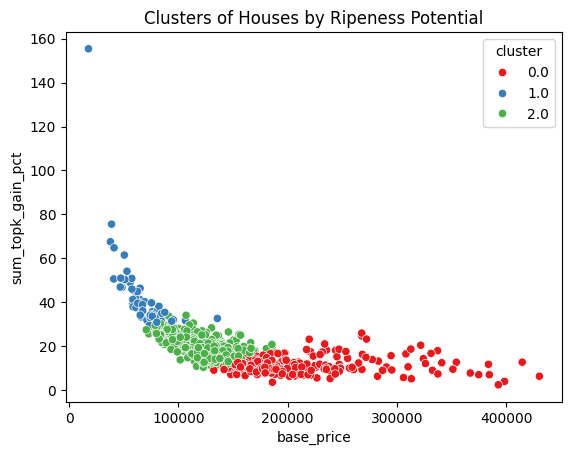

In [485]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1) Make a one-row-per-house ripeness table ---
agg_cols = {
    "sum_topk_gain_pct": "max",   # or "sum" if that's your definition
    "max_single_gain_pct": "max",
    "base_price": "first"
}
ripeness_house = (
    top_props
      .groupby("row_id", as_index=False)
      .agg(agg_cols)
      .set_index("row_id")
)

# parse numeric strings with commas, if any
for c in ["base_price", "sum_topk_gain_pct", "max_single_gain_pct"]:
    if ripeness_house[c].dtype == object:
        ripeness_house[c] = (ripeness_house[c].astype(str)
                             .str.replace(",", "", regex=False).astype(float))

# --- 2) Force a unique surrogate index before joining ---
X_base = X_fe.copy().reset_index(drop=True)  # <— unique 0..n-1 index
data_ripeness = X_base.join(ripeness_house, how="left")  # no explosion

print("data_ripeness shape:", data_ripeness.shape)  # should be (2580, ...)

# --- 3) Build clustering matrix + mask and assign via boolean mask ---
clust_features = ["base_price", "sum_topk_gain_pct", "max_single_gain_pct"]

# rows usable for clustering
mask = ~data_ripeness[clust_features].isna().any(axis=1)

X_clust = data_ripeness.loc[mask, clust_features].to_numpy()
X_scaled = StandardScaler().fit_transform(X_clust)

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)   # len == mask.sum()

# assign clusters ONLY to rows that participated (no index label ambiguity)
data_ripeness["cluster"] = np.nan
data_ripeness.loc[mask, "cluster"] = labels

# --- 4) Quick visual ---
sns.scatterplot(
    data=data_ripeness.loc[mask],
    x="base_price", y="sum_topk_gain_pct", hue="cluster", palette="Set1"
)
plt.title("Clusters of Houses by Ripeness Potential")
# plt.xscale('log')
plt.show()


In [466]:
thr = data_ripeness.loc[mask, "sum_topk_gain_pct"].quantile(0.75)
data_ripeness["ripe_flag"] = (data_ripeness["sum_topk_gain_pct"] >= thr).astype(int)

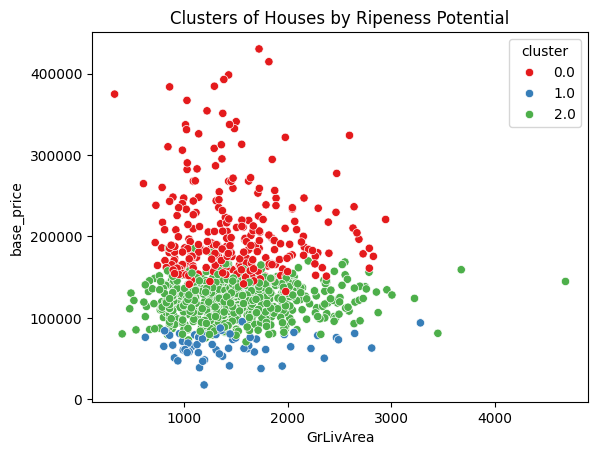

In [456]:
sns.scatterplot(
    data=data_ripeness.loc[mask],
    x="GrLivArea", y="base_price", hue="cluster", palette="Set1"
)
plt.title("Clusters of Houses by Ripeness Potential")

plt.show()

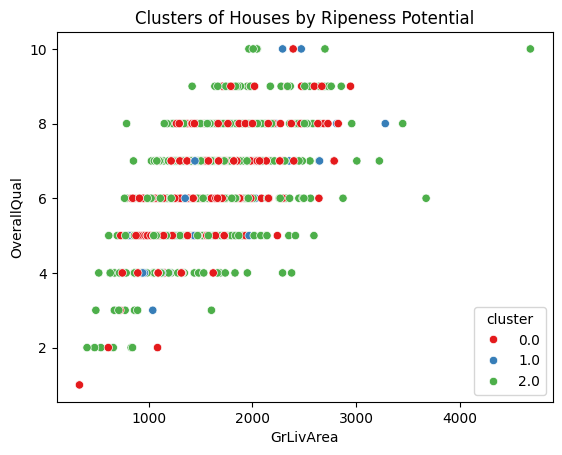

In [554]:
sns.scatterplot(
    data=data_ripeness.loc[mask],
    x="GrLivArea", y="OverallQual", hue="cluster", palette="Set1"
)
plt.title("Clusters of Houses by Ripeness Potential")

plt.show()

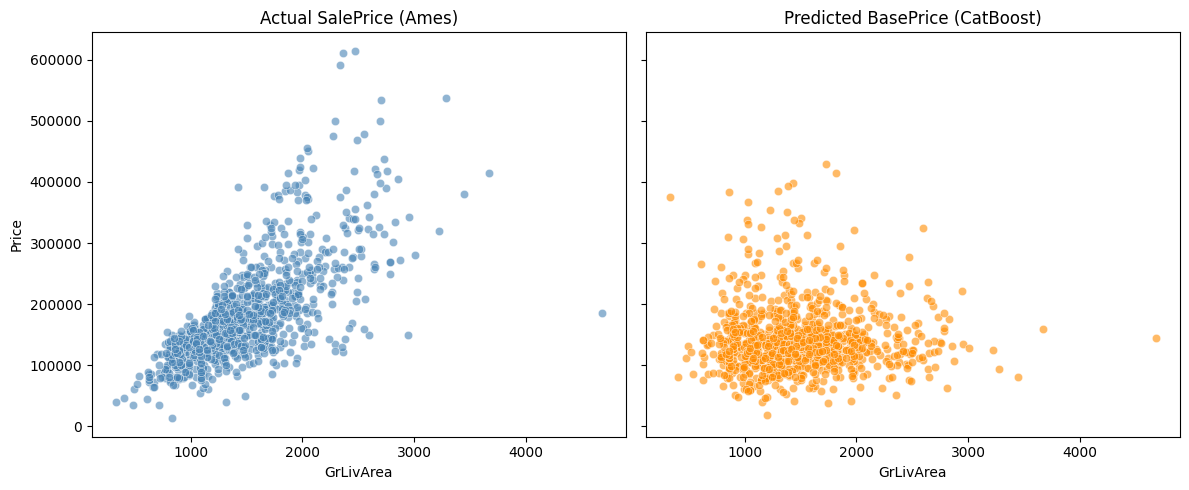

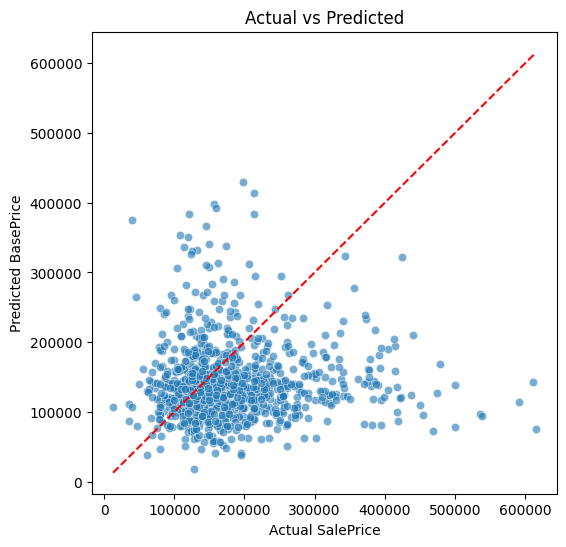

In [476]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# boolean mask as a NumPy array (length must match number of rows)
mask_arr = np.asarray(mask, dtype=bool)

# Slice by position and drop the old indices
ames_part = Ames.loc[mask_arr, ["GrLivArea", "SalePrice"]].reset_index(drop=True)
rip_part  = data_ripeness.iloc[mask_arr][["base_price"]].reset_index(drop=True)

# Put together without any reindexing/alignment headaches
compare_df = pd.concat([ames_part, rip_part.rename(columns={"base_price":"BasePrice"})], axis=1)

# Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
sns.scatterplot(data=compare_df, x="GrLivArea", y="SalePrice", ax=axes[0], alpha=0.6, color="steelblue")
axes[0].set_title("Actual SalePrice (Ames)")
sns.scatterplot(data=compare_df, x="GrLivArea", y="BasePrice",  ax=axes[1], alpha=0.6, color="darkorange")
axes[1].set_title("Predicted BasePrice (CatBoost)")
for ax in axes:
    ax.set_xlabel("GrLivArea"); ax.set_ylabel("Price")
plt.tight_layout(); plt.show()

# Actual vs. predicted
plt.figure(figsize=(6,6))
sns.scatterplot(data=compare_df, x="SalePrice", y="BasePrice", alpha=0.6)
lo, hi = compare_df[["SalePrice","BasePrice"]].min().min(), compare_df[["SalePrice","BasePrice"]].max().max()
plt.plot([lo, hi], [lo, hi], ls="--", color="red")
plt.xlabel("Actual SalePrice"); plt.ylabel("Predicted BasePrice"); plt.title("Actual vs Predicted")
plt.show()

In [535]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

clust_cols = ["base_price", "sum_topk_gain_pct", "max_single_gain_pct", "GrLivArea"]

# Build the table keyed by row
tbl = (X_fe.assign(__row_id__=range(len(X_fe)))[["__row_id__", "GrLivArea"]]
       .merge(data_ripeness.assign(__row_id__=range(len(data_ripeness)))
              [["__row_id__", "base_price","sum_topk_gain_pct","max_single_gain_pct"]],
              on="__row_id__", how="inner"))

# 1) Drop rows with any NaN in the clustering columns
tbl_clean = tbl.dropna(subset=clust_cols)

# 2) Sample and scale
X_clust = tbl_clean.sample(n=min(1000, len(tbl_clean)), random_state=42)
scaler  = StandardScaler()
X_scaled = scaler.fit_transform(X_clust[clust_cols])

# 3) KMeans
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)

# 4) Attach labels back to sampled rows
X_clust = X_clust.copy()
X_clust["cluster"] = labels

# 5) Join to Ames for plotting
Ames_plot = (Ames.assign(__row_id__=range(len(Ames)))[["__row_id__","GrLivArea","SalePrice"]]
             .merge(X_clust[["__row_id__","cluster"]], on="__row_id__", how="inner"))

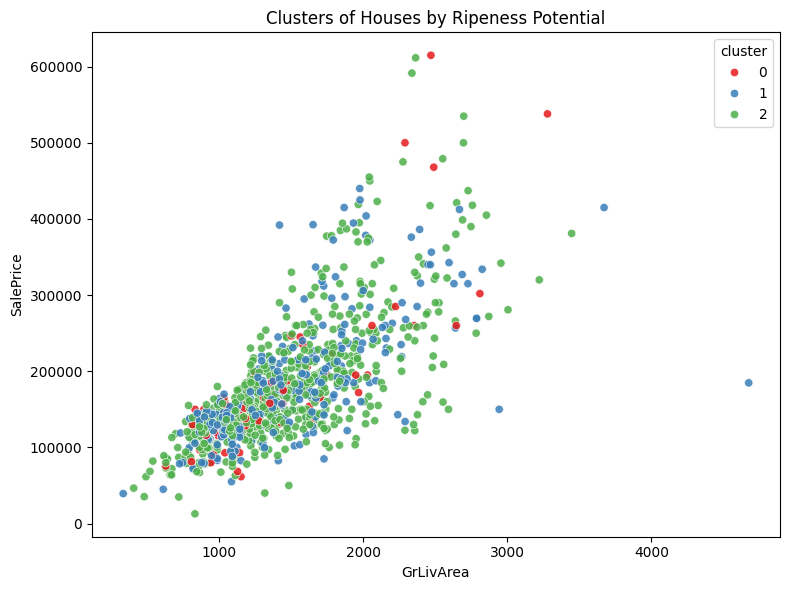

In [536]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.scatterplot(data=Ames_plot, x="GrLivArea", y="SalePrice",
                hue="cluster", palette="Set1", alpha=0.85)
plt.title("Clusters of Houses by Ripeness Potential")
plt.tight_layout()
plt.show()

In [553]:
# Make both the same type (ints are usually nicest)
num_profile["cluster"] = pd.to_numeric(num_profile["cluster"], errors="raise").astype("int64")
cat_profile["cluster"] = pd.to_numeric(cat_profile["cluster"], errors="coerce").astype("int64")

cluster_profile = num_profile.merge(cat_profile, on="cluster", how="left")

# ---------- 5) Merge numeric + categorical summaries ----------
cluster_profile = num_profile.merge(cat_profile, on="cluster", how="left")

display(cluster_profile.head())

,cluster,base_price_mean,base_price_median,sum_topk_gain_pct_mean,sum_topk_gain_pct_median,max_single_gain_pct_mean,max_single_gain_pct_median,GrLivArea_mean,GrLivArea_median,OverallQual_mean,...,GarageCars_mean,GarageCars_median,KitchenQual_code_mean,KitchenQual_code_median,ExterQual_code_mean,ExterQual_code_median,KitchenQual_mode,KitchenQual_share,ExterQual_mode,ExterQual_share
0,0,"205,919.64","186,579.58",11.57,11.38,4.69,4.63,"1,479.50","1,428.50",6.18,...,1.86,2.00,3.52,3.00,3.43,3.00,TA,0.49,TA,0.59
1,1,"69,542.30","69,143.01",41.26,36.12,20.21,16.14,"1,442.39","1,312.00",6.01,...,1.81,2.00,3.55,3.00,3.40,3.00,TA,0.49,TA,0.66
2,2,"122,936.06","124,482.30",19.43,18.86,8.40,7.98,"1,480.62","1,412.00",6.07,...,1.73,2.00,3.51,3.00,3.40,3.00,TA,0.52,TA,0.62


In [551]:
cat_profile = (
    combined.groupby("cluster")[["KitchenQual", "ExterQual"]]
            .apply(lambda df: pd.concat([mode_and_share(df[c]) for c in df.columns], axis=0))
            .reset_index()
)
cat_profile.columns = ["cluster",
                       "KitchenQual_mode","KitchenQual_share",
                       "ExterQual_mode","ExterQual_share"]

# now they’re both ints, so:
cluster_profile = num_profile.merge(cat_profile, on="cluster", how="left")

# ---------- 5) Merge numeric + categorical summaries ----------
cluster_profile = num_profile.merge(cat_profile, on="cluster", how="left")

print(cluster_profile.head())

   cluster  base_price_mean  base_price_median  sum_topk_gain_pct_mean  \
0     0.00       205,919.64         186,579.58                   11.57   
1     1.00        69,542.30          69,143.01                   41.26   
2     2.00       122,936.06         124,482.30                   19.43   

   sum_topk_gain_pct_median  max_single_gain_pct_mean  \
0                     11.38                      4.69   
1                     36.12                     20.21   
2                     18.86                      8.40   

   max_single_gain_pct_median  GrLivArea_mean  GrLivArea_median  \
0                        4.63        1,479.50          1,428.50   
1                       16.14        1,442.39          1,312.00   
2                        7.98        1,480.62          1,412.00   

   OverallQual_mean  ...  GarageCars_mean  GarageCars_median  \
0              6.18  ...             1.86               2.00   
1              6.01  ...             1.81               2.00   
2            

In [861]:
# === From X_fe + data_ripeness to trained CatBoost + full metrics ===
# Requirements: catboost, numpy, pandas, scikit-learn

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, classification_report, confusion_matrix, precision_recall_curve
from catboost import CatBoostClassifier, Pool

# ------------------------- 1) Build y from data_ripeness -------------------------
if "ripe" not in data_ripeness.columns:
    ripe_mask = (data_ripeness["sum_topk_gain_pct"] >= 30) | (data_ripeness["max_single_gain_pct"] >= 15)
    data_ripeness = data_ripeness.copy()
    data_ripeness["ripe"] = ripe_mask.astype(int)

# Align label to X rows (keeps X_fe order)
y = data_ripeness.loc[X_fe.index, "ripe"].astype(int).to_numpy()

# Optional: bring in original Ames df if present (for topK pretty-print)
try:
    ORIG_AMES = Ames.copy()
except NameError:
    ORIG_AMES = None

# ------------------------- 2) Utilities -------------------------
def prep_for_catboost(df, drop_cols=("__row_id__",)):
    """
    - Drop id-like columns
    - Numeric: fillna(median)
    - Non-numeric: cast to string, fill "__NA__"
    - Return prepped df and categorical feature indices
    """
    df_cb = df.copy()
    drop_cols = [c for c in drop_cols if c in df_cb.columns]
    if drop_cols:
        df_cb = df_cb.drop(columns=drop_cols)

    num_cols = df_cb.select_dtypes(include=["number"]).columns
    cat_cols = df_cb.columns.difference(num_cols)  # everything not numeric

    # clean numerics
    if len(num_cols):
        assert all(np.issubdtype(df_cb[c].dtype, np.number) for c in num_cols)
        df_cb[num_cols] = df_cb[num_cols].apply(lambda s: s.fillna(s.median()))

    # clean categoricals / others
    if len(cat_cols):
        df_cb[cat_cols] = (
            df_cb[cat_cols]
            .astype(str)                       # eliminates pandas 'category' reduction issues
            .replace({"nan": "__NA__"})
            .fillna("__NA__")
        )

    cat_idx = [df_cb.columns.get_loc(c) for c in cat_cols]
    return df_cb, cat_idx

def best_f1_from_pr(y_true, proba):
    p, r, t = precision_recall_curve(y_true, proba)
    f1 = (2*p*r)/(p+r+1e-12)
    i = np.nanargmax(f1)
    # thresholds array has len = len(p)-1, so map index carefully
    thr = float(t[max(i-1, 0)]) if len(t) else 0.5
    return float(f1[i]), thr

def summarize_cutoffs(y_true, proba, cutoffs=(0.05, 0.10, 0.20)):
    df = pd.DataFrame({"y": y_true, "proba": proba}).sort_values("proba", ascending=False)
    prev = df["y"].mean()
    rows, n = [], len(df)
    for c in cutoffs:
        K = max(1, int(round(c*n)))
        top = df.iloc[:K]
        prec = float(top["y"].mean())
        rec  = float(top["y"].sum() / max(1, df["y"].sum()))
        lift = (prec / prev) if prev > 0 else np.nan
        rows.append([f"{int(c*100)}%", K, round(prec,2), round(rec,2), round(lift,2), round(prev,2)])
    return pd.DataFrame(rows, columns=["cutoff","K","Precision_at_K","Recall_at_K","Lift_at_K","BaselinePrev"])

def build_topk_table(proba, X_test, top_k_frac=0.10, id_col="__row_id__", original_ames=None, original_cols=None):
    """
    Duplicate-index safe Top-K builder:
      - ranks by proba (descending) using positional order
      - attaches optional id from X_test by position
      - attaches selected columns from original_ames by mapping each label to its FIRST occurrence
    """
    df_eval = pd.DataFrame({"proba": np.asarray(proba)})
    df_eval["pos"] = np.arange(len(df_eval))
    df_eval["orig_index"] = X_test.index.to_numpy()
    df_eval = df_eval.sort_values("proba", ascending=False, kind="mergesort")

    K = max(1, int(round(top_k_frac * len(df_eval))))
    top = pd.DataFrame({"ripe_prob": df_eval["proba"].to_numpy()[:K]})
    top["ripe_prob"] = top["ripe_prob"].round(2)

    # Attach id by position (if present)
    top_pos = df_eval["pos"].to_numpy()[:K]
    if id_col in X_test.columns:
        top["orig_id"] = X_test.iloc[top_pos][id_col].to_numpy()

    # Attach original Ames columns (if provided)
    if (original_ames is not None) and original_cols:
        cols = [c for c in original_cols if c in original_ames.columns]
        if cols:
            ames_first = (
                original_ames
                .reset_index()
                .rename(columns={"index": "__lbl__"})
                .drop_duplicates(subset="__lbl__", keep="first")
                .set_index("__lbl__")
            )
            labels_for_top = df_eval["orig_index"].to_numpy()[:K]
            ames_slice = ames_first.loc[labels_for_top, cols].reset_index(drop=True)
            for c in cols:
                top[c] = ames_slice[c].to_numpy()

    top["orig_index"] = df_eval["orig_index"].to_numpy()[:K]
    return top

# ------------------------- 3) Train/test split (reuse if already exists) -------------------------
have_split = all(v in globals() for v in ["X_train", "X_test", "y_train", "y_test"])
if not have_split:
    X_train, X_test, y_train, y_test = train_test_split(
        X_fe, y, test_size=0.35, random_state=42, stratify=y
    )

# ------------------------- 4) Prep frames for CatBoost -------------------------
X_train_cb, cat_idx_train = prep_for_catboost(X_train)
X_test_cb,  _             = prep_for_catboost(X_test)

train_pool = Pool(X_train_cb, y_train, cat_features=cat_idx_train)
eval_pool  = Pool(X_test_cb,  y_test,  cat_features=cat_idx_train)

# ------------------------- 5) Optimized single CatBoost (your best config) -------------------------
model = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="PRAUC",          # directly optimizes AUPRC
    iterations=1500,
    learning_rate=0.05,
    depth=8,
    l2_leaf_reg=6.0,
    random_strength=0.5,          # your best random_strength
    bagging_temperature=0.0,      # winner in your sweep
    subsample=0.8,
    rsm=0.8,
    random_state=42,
    verbose=False
)

model.fit(
    train_pool,
    eval_set=eval_pool,
    use_best_model=True,
    early_stopping_rounds=200,
    verbose=False
)

# ------------------------- 6) Metrics & artifacts -------------------------
proba_test = model.predict_proba(eval_pool)[:, 1]
auprc = average_precision_score(y_test, proba_test)
best_f1, best_thr = best_f1_from_pr(y_test, proba_test)

print(f"AUPRC: {auprc:.3f} | best F1: {best_f1:.3f} @ thr: {best_thr:.3f}")

# Confusion matrix & classification report at best-F1 threshold
pred_test = (proba_test >= best_thr).astype(int)
print("\nClassification report:\n", classification_report(y_test, pred_test))
cm = confusion_matrix(y_test, pred_test)
cm_df = pd.DataFrame(cm, index=["actual_0","actual_1"], columns=["pred_0","pred_1"])
print("\nConfusion matrix:\n", cm_df)

# Decile lift (top decile first)
df_eval = pd.DataFrame({"y": y_test, "proba": proba_test}, index=X_test.index).sort_values("proba", ascending=False)
df_eval["decile"] = pd.qcut(df_eval["proba"].rank(method="first", ascending=False), 10, labels=False)
lift_by_decile = df_eval.groupby("decile")["y"].mean().sort_index(ascending=False)
print("\nDecile lift (top decile first):")
print(lift_by_decile)

# Cutoffs table (5%, 10%, 20%)
cut_tbl = summarize_cutoffs(y_test, proba_test, cutoffs=(0.05, 0.10, 0.20))
print("\n=== Precision/Recall/Lift across cutoffs ===")
print(cut_tbl.to_string(index=False))

# Top-K reviewer table
ORIG_SHOW_COLS = [
    "Neighborhood","MSZoning","YearBuilt","YearRemodAdd","LotArea","LotFrontage",
    "OverallQual","OverallCond","GrLivArea","TotalBsmtSF","GarageArea","KitchenQual",
    "FullBath","HalfBath","BedroomAbvGr","TotRmsAbvGrd",
]
topK = build_topk_table(
    proba=proba_test,
    X_test=X_test,
    top_k_frac=0.10,
    id_col="__row_id__",
    original_ames=Ames.copy(),
    original_cols=ORIG_SHOW_COLS
)
print("\nTop-K (preview):")
print(topK.head(10))

# Feature importances
fi = pd.DataFrame({
    "feature": X_train_cb.columns,
    "importance": model.get_feature_importance(train_pool, type="FeatureImportance")
}).sort_values("importance", ascending=False).reset_index(drop=True)
print("\nTop features:\n", fi.head(20).to_string(index=False))

# ------------------------- 7) Optional: save to disk -------------------------
out_dir = "cb_outputs_single"
import os; os.makedirs(out_dir, exist_ok=True)
fi.to_csv(f"{out_dir}/feature_importances.csv", index=False)
cm_df.to_csv(f"{out_dir}/confusion_matrix.csv")
lift_by_decile.to_csv(f"{out_dir}/decile_lift.csv")
cut_tbl.to_csv(f"{out_dir}/cutoffs.csv", index=False)
topK.to_csv(f"{out_dir}/topK_review_list.csv", index=False)
print(f"\nSaved CSVs to: {out_dir}/")

AUPRC: 0.704 | best F1: 0.637 @ thr: 0.354

Classification report:
               precision    recall  f1-score   support

           0       0.77      0.73      0.75       394
           1       0.61      0.67      0.64       251

    accuracy                           0.70       645
   macro avg       0.69      0.70      0.69       645
weighted avg       0.71      0.70      0.71       645


Confusion matrix:
           pred_0  pred_1
actual_0     287     107
actual_1      84     167

Decile lift (top decile first):
decile
9   0.23
8   0.28
7   0.18
6   0.25
5   0.19
4   0.32
3   0.48
2   0.40
1   0.61
0   0.94
Name: y, dtype: float64

=== Precision/Recall/Lift across cutoffs ===
cutoff   K  Precision_at_K  Recall_at_K  Lift_at_K  BaselinePrev
    5%  32            1.00         0.13       2.57          0.39
   10%  64            0.94         0.24       2.41          0.39
   20% 129            0.78         0.40       1.99          0.39

Top-K (preview):
   ripe_prob Neighborhood MSZoni

In [820]:
# ----------------------------------------------------------
# Compare CatBoost feature importance: Gain vs SHAP
# ----------------------------------------------------------

# Gain-based importance (default)
fi_gain = model.get_feature_importance(train_pool, type="PredictionValuesChange")
fi_gain_df = pd.DataFrame({
    "feature": X_train_cb.columns,
    "importance_gain": fi_gain
}).sort_values("importance_gain", ascending=False)

# SHAP-based importance (average absolute Shap values)
fi_shap = model.get_feature_importance(train_pool, type="ShapValues")
# ShapValues output shape = (n_samples, n_features+1) -> last col = expected value
shap_values = fi_shap[:, :-1]  
fi_shap_mean = np.abs(shap_values).mean(axis=0)

fi_shap_df = pd.DataFrame({
    "feature": X_train_cb.columns,
    "importance_shap": fi_shap_mean
}).sort_values("importance_shap", ascending=False)

# Merge for side-by-side comparison
fi_compare = (
    fi_gain_df.merge(fi_shap_df, on="feature", how="outer")
    .fillna(0)
    .sort_values("importance_shap", ascending=False)
)

print("\n=== Top features: Gain vs SHAP ===")
print(fi_compare.head(20).to_string(index=False))


=== Top features: Gain vs SHAP ===
           feature  importance_gain  importance_shap
        GarageArea             3.89             0.11
       LotFrontage             2.97             0.10
    TotalSF_x_Qual             3.87             0.10
          LotShape             2.57             0.10
         ExterQual             1.81             0.09
       KitchenQual             2.00             0.08
       OpenPorchSF             3.37             0.08
           LotArea             3.97             0.07
        WoodDeckSF             4.13             0.06
           TotalSF             3.35             0.06
        GarageCars             1.07             0.06
        CentralAir             1.50             0.05
        MSSubClass             1.90             0.05
      YearRemodAdd             2.11             0.05
       OverallQual             2.01             0.05
        BsmtFinSF1             2.79             0.05
         YearBuilt             1.11             0.04
          

In [886]:
# ================== ONE-SHOT CATBOOST PIPELINE ==================
# Inputs required in scope:
#   X_fe : pd.DataFrame  (engineered features; includes interactions)
#   data_ripeness : pd.DataFrame with columns:
#       - sum_topk_gain_pct, max_single_gain_pct
#   (optional) ORIG_AMES : pd.DataFrame of original Ames data (index aligns to X_fe)
#   (optional) ORIG_SHOW_COLS : list of columns to show from ORIG_AMES in Top-K

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    average_precision_score, precision_recall_curve,
    classification_report, confusion_matrix
)
from catboost import CatBoostClassifier, Pool

# ---------- 1) Build y from data_ripeness and align ----------
def build_y(X_fe, data_ripeness):
    dr = data_ripeness.copy()
    if "ripe" not in dr.columns:
        ripe_mask = (dr["sum_topk_gain_pct"] >= 30) | (dr["max_single_gain_pct"] >= 15)
        dr["ripe"] = ripe_mask.astype(int)
    # align to X_fe index, cast to int
    y = dr.loc[X_fe.index, "ripe"].astype(int).to_numpy()
    return y

# ---------- 2) Prep for CatBoost (dup-safe, dtype-safe) ----------
def prep_for_catboost(df, drop_cols=("__row_id__",)):
    df_cb = df.copy()
    # drop id-like cols if present
    drop_cols = [c for c in drop_cols if c in df_cb.columns]
    if drop_cols:
        df_cb = df_cb.drop(columns=drop_cols)

    # strict split by dtype
    num_cols = df_cb.select_dtypes(include=["number"]).columns
    cat_cols = df_cb.columns.difference(num_cols)

    # numerics: median impute
    if len(num_cols):
        assert all(np.issubdtype(df_cb[c].dtype, np.number) for c in num_cols)
        df_cb[num_cols] = df_cb[num_cols].apply(lambda s: s.fillna(s.median()))

    # categoricals: to string, fill __NA__
    if len(cat_cols):
        df_cb[cat_cols] = (
            df_cb[cat_cols]
            .astype(str)
            .replace({"nan": "__NA__"})
            .fillna("__NA__")
        )

    # cat indices (after casting)
    cat_idx = [df_cb.columns.get_loc(c) for c in cat_cols]
    return df_cb, cat_idx

# ---------- 3) Helpers (metrics / tables) ----------
def best_f1_from_pr(y_true, proba):
    p, r, t = precision_recall_curve(y_true, proba)
    f1 = (2*p*r) / (p + r + 1e-12)
    i = np.nanargmax(f1)
    thr = float(t[max(i-1, 0)])  # thresholds len = len(p)-1
    return float(f1[i]), thr

def summarize_cutoffs(y_true, proba, cutoffs=(0.05, 0.10, 0.20)):
    df = pd.DataFrame({"y": y_true, "proba": proba}).sort_values("proba", ascending=False)
    prev = df["y"].mean()
    rows = []
    n = len(df)
    for c in cutoffs:
        K = max(1, int(round(c*n)))
        top = df.iloc[:K]
        prec = float(top["y"].mean())
        rec  = float(top["y"].sum() / max(1, df["y"].sum()))
        lift = (prec / prev) if prev > 0 else np.nan
        rows.append([f"{int(c*100)}%", K, round(prec,2), round(rec,2), round(lift,2), round(prev,2)])
    return pd.DataFrame(rows, columns=["cutoff","K","Precision_at_K","Recall_at_K","Lift_at_K","BaselinePrev"])

def decile_lift(y_true, proba):
    df = pd.DataFrame({"y": y_true, "proba": proba})
    # rank descending, then bucket into deciles 0..9 (9 is top decile once sorted later)
    df["rank"] = df["proba"].rank(method="first", ascending=False)
    df["decile"] = pd.qcut(df["rank"], 10, labels=False)
    # return top-decile-first
    return df.groupby("decile")["y"].mean().sort_index(ascending=False)

def build_topk_table(proba, X_test, top_k_frac=0.10, id_col="__row_id__",
                     original_ames=None, original_cols=None):
    # position-safe, duplicate-index-safe
    df_eval = pd.DataFrame({"proba": np.asarray(proba)})
    df_eval["pos"] = np.arange(len(df_eval))
    df_eval["orig_index"] = X_test.index.to_numpy()
    df_eval = df_eval.sort_values("proba", ascending=False, kind="mergesort")

    K = max(1, int(round(top_k_frac * len(df_eval))))
    top = pd.DataFrame({"ripe_prob": np.round(df_eval["proba"].to_numpy()[:K], 2)})

    # optional id
    top_pos = df_eval["pos"].to_numpy()[:K]
    if id_col in X_test.columns:
        top["orig_id"] = X_test.iloc[top_pos][id_col].to_numpy()

    # optional original Ames columns
    if (original_ames is not None) and original_cols:
        cols = [c for c in original_cols if c in original_ames.columns]
        if cols:
            ames_first = (
                original_ames.reset_index()
                .rename(columns={"index": "__lbl__"})
                .drop_duplicates(subset="__lbl__", keep="first")
                .set_index("__lbl__")
            )
            labels_for_top = df_eval["orig_index"].to_numpy()[:K]
            ames_slice = ames_first.loc[labels_for_top, cols].reset_index(drop=True)
            for c in cols:
                top[c] = ames_slice[c].to_numpy()

    top["orig_index"] = df_eval["orig_index"].to_numpy()[:K]
    return top

def catboost_feature_importances(model, X_cb, cat_idx):
    # Gain FI (same data schema as training)
    train_pool = Pool(X_cb, cat_features=cat_idx)
    fi_gain = pd.DataFrame({
        "feature": X_cb.columns,
        "importance": model.get_feature_importance(type="FeatureImportance", data=train_pool)
    }).sort_values("importance", ascending=False, ignore_index=True)

    # SHAP: build Pool with cat_features too
    shap_vals = model.get_feature_importance(type="ShapValues", data=train_pool)
    shap_contrib = np.abs(shap_vals[:, :-1]).mean(axis=0)  # drop bias column
    fi_shap = pd.DataFrame({"feature": X_cb.columns, "importance_shap": shap_contrib}) \
               .sort_values("importance_shap", ascending=False, ignore_index=True)

    fi_merged = (
        fi_gain.rename(columns={"importance": "importance_gain"})
        .merge(fi_shap, on="feature", how="outer")
        .fillna(0.0)
        .sort_values(["importance_gain","importance_shap"], ascending=False, ignore_index=True)
    )
    return fi_gain, fi_shap, fi_merged

# ---------- 4) Train + evaluate single best model ----------
def run_single_catboost_pipeline(
    X_fe,
    data_ripeness,
    test_size=0.33,
    random_state=42,
    id_col="__row_id__",
    orig_ames=None,
    orig_cols=None,
    top_k_frac=0.10
):
    # y
    y = build_y(X_fe, data_ripeness)

    # split once (stratified for stable positivity in test)
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_fe, y, test_size=test_size, stratify=y, random_state=random_state
    )

    # prep
    X_tr_cb, cat_idx = prep_for_catboost(X_tr, drop_cols=(id_col,))
    X_te_cb, _       = prep_for_catboost(X_te, drop_cols=(id_col,))

    train_pool = Pool(X_tr_cb, y_tr, cat_features=cat_idx)
    eval_pool  = Pool(X_te_cb, y_te, cat_features=cat_idx)

    # locked, fast, strong params (your winner)
    model = CatBoostClassifier(
        loss_function="Logloss",
        eval_metric="PRAUC",
        iterations=1500,
        learning_rate=0.05,
        depth=8,
        l2_leaf_reg=2.0,
        random_strength=1.2,   # <- your sweet spot
        subsample=0.8,
        rsm=0.8,
        random_state=random_state,
        verbose=False
    )

    model.fit(
        train_pool,
        eval_set=eval_pool,
        use_best_model=True,
        early_stopping_rounds=200,
        verbose=False
    )

    # predictions
    proba = model.predict_proba(eval_pool)[:, 1]
    auprc = average_precision_score(y_te, proba)
    best_f1, best_thr = best_f1_from_pr(y_te, proba)

    # confusion/report @ best F1
    pred = (proba >= best_thr).astype(int)
    report = classification_report(y_te, pred, output_dict=False)
    cm = confusion_matrix(y_te, pred)

    # tables
    cut_tbl = summarize_cutoffs(y_te, proba, cutoffs=(0.05, 0.10, 0.20))
    lift = decile_lift(y_te, proba)
    topK = build_topk_table(
        proba=proba, X_test=X_te, top_k_frac=top_k_frac,
        id_col=id_col, original_ames=orig_ames, original_cols=orig_cols
    )

    # feature importances (gain + shap + merged view)
    fi_gain, fi_shap, fi_merged = catboost_feature_importances(model, X_tr_cb, cat_idx)

    # ---- print quick summary ----
    print(f"AUPRC: {auprc:.3f} | best F1: {best_f1:.3f} @ thr: {best_thr:.3f}\n")
    print("Classification report:")
    print(report)
    print("\nConfusion matrix:")
    print(pd.DataFrame(cm, index=["actual_0","actual_1"], columns=["pred_0","pred_1"]))
    print("\n=== Precision/Recall/Lift across cutoffs ===")
    print(cut_tbl.to_string(index=False))
    print("\nDecile lift (top decile first):")
    print(lift)

    # return everything
    return dict(
        model=model,
        y_test=y_te,
        proba=proba,
        best_f1=best_f1,
        best_thr=best_thr,
        cut_tbl=cut_tbl,
        lift=lift,
        topK=topK,
        fi_gain=fi_gain,
        fi_shap=fi_shap,
        fi=fi_merged
    )

# ================== HOW TO RUN ==================
# (Optional) define these for Top-K enrichment:
# ORIG_AMES = Ames  # your original DF
# ORIG_SHOW_COLS = [
#     "Neighborhood","MSZoning","YearBuilt","YearRemodAdd","LotArea","LotFrontage",
#     "OverallQual","OverallCond","GrLivArea","TotalBsmtSF","GarageArea","KitchenQual",
#     "FullBath","HalfBath","BedroomAbvGr","TotRmsAbvGrd"
# ]
# results = run_single_catboost_pipeline(
#     X_fe, data_ripeness,
#     test_size=0.33, random_state=42,
#     id_col="__row_id__",
#     orig_ames=ORIG_AMES, orig_cols=ORIG_SHOW_COLS,
#     top_k_frac=0.10
# )
# Access: results["cut_tbl"], results["lift"], results["topK"], results["fi"]

In [887]:
# ================== HOW TO RUN ==================
# (Optional) define these for Top-K enrichment:
ORIG_AMES = Ames  # your original DF
ORIG_SHOW_COLS = [
    "Neighborhood","MSZoning","YearBuilt","YearRemodAdd","LotArea","LotFrontage",
    "OverallQual","OverallCond","GrLivArea","TotalBsmtSF","GarageArea","KitchenQual",
    "FullBath","HalfBath","BedroomAbvGr","TotRmsAbvGrd"
]
results = run_single_catboost_pipeline(
    X_fe, data_ripeness,
    test_size=0.33, random_state=42,
    id_col="__row_id__",
    orig_ames=ORIG_AMES, orig_cols=ORIG_SHOW_COLS,
    top_k_frac=0.10
)
# Access: results["cut_tbl"], results["lift"], results["topK"], results["fi"]
print(results["cut_tbl"])

AUPRC: 0.696 | best F1: 0.605 @ thr: 0.290

Classification report:
              precision    recall  f1-score   support

           0       0.77      0.51      0.62       520
           1       0.50      0.76      0.60       332

    accuracy                           0.61       852
   macro avg       0.64      0.64      0.61       852
weighted avg       0.67      0.61      0.61       852


Confusion matrix:
          pred_0  pred_1
actual_0     267     253
actual_1      79     253

=== Precision/Recall/Lift across cutoffs ===
cutoff   K  Precision_at_K  Recall_at_K  Lift_at_K  BaselinePrev
    5%  43            1.00         0.13       2.57          0.39
   10%  85            0.95         0.24       2.45          0.39
   20% 170            0.76         0.39       1.96          0.39

Decile lift (top decile first):
decile
9   0.20
8   0.26
7   0.20
6   0.27
5   0.32
4   0.34
3   0.39
2   0.40
1   0.56
0   0.95
Name: y, dtype: float64
  cutoff    K  Precision_at_K  Recall_at_K  Lift_at_

In [888]:
# ================== ONE-SHOT CATBOOST (winner params + optional ensemble) ==================
# Inputs expected in scope:
#   X_fe : pd.DataFrame  (engineered features; may include interactions)
#   data_ripeness : pd.DataFrame with columns: sum_topk_gain_pct, max_single_gain_pct
# Optional for Top-K preview:
#   ORIG_AMES : pd.DataFrame (original Ames; index aligns to X_fe)
#   ORIG_SHOW_COLS : list[str] columns from ORIG_AMES to show in topK

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    average_precision_score, precision_recall_curve,
    classification_report, confusion_matrix
)
from catboost import CatBoostClassifier, Pool

# ---------------- CONFIG ----------------
TEST_SIZE   = 0.33
RANDOM_SEED = 42
TOP_K_FRAC  = 0.10
ID_COL      = "__row_id__"

# Winner params from your sweep
WINNER_PARAMS = dict(
    loss_function="Logloss",
    eval_metric="PRAUC",
    iterations=1500,
    learning_rate=0.05,   # keep as before; good speed/accuracy tradeoff
    depth=8,
    l2_leaf_reg=2.0,      # <— winner
    random_strength=1.2,  # <— winner
    subsample=0.8,
    rsm=0.8,
    random_state=RANDOM_SEED,
    verbose=False
)

# Ensemble toggle (optional)
USE_ENSEMBLE = False
ENSEMBLE_SEEDS = (42, 202, 999)

# ---------- 1) Build y from data_ripeness and align ----------
def build_y(X_fe, data_ripeness):
    dr = data_ripeness.copy()
    if "ripe" not in dr.columns:
        ripe_mask = (dr["sum_topk_gain_pct"] >= 30) | (dr["max_single_gain_pct"] >= 15)
        dr["ripe"] = ripe_mask.astype(int)
    y = dr.loc[X_fe.index, "ripe"].astype(int).to_numpy()
    return y

# ---------- 2) Prep for CatBoost (dup-safe, dtype-safe) ----------
def prep_for_catboost(df, drop_cols=(ID_COL,)):
    df_cb = df.copy()
    # drop id-like cols if present
    drop_cols = [c for c in drop_cols if c in df_cb.columns]
    if drop_cols:
        df_cb = df_cb.drop(columns=drop_cols)

    # strict split by dtype
    num_cols = df_cb.select_dtypes(include=["number"]).columns
    cat_cols = df_cb.columns.difference(num_cols)

    # numerics: median impute
    if len(num_cols):
        assert all(np.issubdtype(df_cb[c].dtype, np.number) for c in num_cols)
        df_cb[num_cols] = df_cb[num_cols].apply(lambda s: s.fillna(s.median()))

    # categoricals (object/category/bool): cast to string + fill sentinel
    if len(cat_cols):
        df_cb[cat_cols] = (
            df_cb[cat_cols]
            .astype(str)
            .replace({"nan": "__NA__"})
            .fillna("__NA__")
        )

    # cat indices (positions of non-numeric columns after casting)
    cat_idx = [df_cb.columns.get_loc(c) for c in cat_cols]
    return df_cb, cat_idx

# ---------- 3) Helpers (metrics / tables) ----------
def best_f1_from_pr(y_true, proba):
    p, r, t = precision_recall_curve(y_true, proba)
    f1 = (2*p*r) / (p + r + 1e-12)
    i = np.nanargmax(f1)
    thr = float(t[max(i-1, 0)])  # thresholds len = len(p)-1
    return float(f1[i]), thr

def summarize_cutoffs(y_true, proba, cutoffs=(0.05, 0.10, 0.20)):
    df = pd.DataFrame({"y": y_true, "proba": proba}).sort_values("proba", ascending=False)
    prev = df["y"].mean()
    rows = []
    n = len(df)
    for c in cutoffs:
        K = max(1, int(round(c*n)))
        top = df.iloc[:K]
        prec = float(top["y"].mean())
        rec  = float(top["y"].sum() / max(1, df["y"].sum()))
        lift = (prec / prev) if prev > 0 else np.nan
        rows.append([f"{int(c*100)}%", K, round(prec,2), round(rec,2), round(lift,2), round(prev,2)])
    return pd.DataFrame(rows, columns=["cutoff","K","Precision_at_K","Recall_at_K","Lift_at_K","BaselinePrev"])

def decile_lift(y_true, proba):
    df = pd.DataFrame({"y": y_true, "proba": proba})
    df["rank"] = df["proba"].rank(method="first", ascending=False)
    df["decile"] = pd.qcut(df["rank"], 10, labels=False)
    return df.groupby("decile")["y"].mean().sort_index(ascending=False)

def build_topk_table(proba, X_test, top_k_frac=TOP_K_FRAC, id_col=ID_COL,
                     original_ames=None, original_cols=None):
    df_eval = pd.DataFrame({"proba": np.asarray(proba)})
    df_eval["pos"] = np.arange(len(df_eval))
    df_eval["orig_index"] = X_test.index.to_numpy()
    df_eval = df_eval.sort_values("proba", ascending=False, kind="mergesort")

    K = max(1, int(round(top_k_frac * len(df_eval))))
    top = pd.DataFrame({"ripe_prob": np.round(df_eval["proba"].to_numpy()[:K], 2)})

    # optional id
    top_pos = df_eval["pos"].to_numpy()[:K]
    if id_col in X_test.columns:
        top["orig_id"] = X_test.iloc[top_pos][id_col].to_numpy()

    # optional original Ames columns
    if (original_ames is not None) and original_cols:
        cols = [c for c in original_cols if c in original_ames.columns]
        if cols:
            ames_first = (
                original_ames.reset_index()
                .rename(columns={"index": "__lbl__"})
                .drop_duplicates(subset="__lbl__", keep="first")
                .set_index("__lbl__")
            )
            labels_for_top = df_eval["orig_index"].to_numpy()[:K]
            ames_slice = ames_first.loc[labels_for_top, cols].reset_index(drop=True)
            for c in cols:
                top[c] = ames_slice[c].to_numpy()

    top["orig_index"] = df_eval["orig_index"].to_numpy()[:K]
    return top

def catboost_feature_importances(model, X_cb, cat_idx):
    pool = Pool(X_cb, cat_features=cat_idx)
    # Gain
    fi_gain = pd.DataFrame({
        "feature": X_cb.columns,
        "importance": model.get_feature_importance(type="FeatureImportance", data=pool)
    }).sort_values("importance", ascending=False, ignore_index=True)
    # SHAP (absolute mean of contributions)
    shap_vals = model.get_feature_importance(type="ShapValues", data=pool)
    shap_contrib = np.abs(shap_vals[:, :-1]).mean(axis=0)
    fi_shap = pd.DataFrame(
        {"feature": X_cb.columns, "importance_shap": shap_contrib}
    ).sort_values("importance_shap", ascending=False, ignore_index=True)
    # merged
    fi_merged = (
        fi_gain.rename(columns={"importance": "importance_gain"})
        .merge(fi_shap, on="feature", how="outer")
        .fillna(0.0)
        .sort_values(["importance_gain","importance_shap"], ascending=False, ignore_index=True)
    )
    return fi_gain, fi_shap, fi_merged

# ---------- 4) Train + evaluate ----------
def run_catboost_winner(
    X_fe, data_ripeness,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED,
    id_col=ID_COL,
    orig_ames=None,
    orig_cols=None,
    use_ensemble=USE_ENSEMBLE,
    ensemble_seeds=ENSEMBLE_SEEDS
):
    # labels
    y = build_y(X_fe, data_ripeness)

    # single, stratified split
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_fe, y, test_size=test_size, stratify=y, random_state=random_state
    )

    # prep for CatBoost
    X_tr_cb, cat_idx = prep_for_catboost(X_tr, drop_cols=(id_col,))
    X_te_cb,  _      = prep_for_catboost(X_te,  drop_cols=(id_col,))
    tr_pool = Pool(X_tr_cb, y_tr, cat_features=cat_idx)
    te_pool = Pool(X_te_cb, y_te, cat_features=cat_idx)

    def fit_one(seed=None):
        params = WINNER_PARAMS.copy()
        if seed is not None:
            params["random_state"] = seed
        model = CatBoostClassifier(**params)
        model.fit(tr_pool, eval_set=te_pool, use_best_model=True, early_stopping_rounds=200, verbose=False)
        return model

    if not use_ensemble:
        model = fit_one(seed=random_state)
        proba = model.predict_proba(te_pool)[:, 1]
    else:
        probs = []
        models = []
        for s in ensemble_seeds:
            m = fit_one(seed=s)
            models.append(m)
            probs.append(m.predict_proba(te_pool)[:, 1])
        proba = np.mean(np.vstack(probs), axis=0)
        model = models  # return list

    # metrics
    auprc = average_precision_score(y_te, proba)
    best_f1, best_thr = best_f1_from_pr(y_te, proba)
    pred = (proba >= best_thr).astype(int)
    cm = confusion_matrix(y_te, pred)
    report_txt = classification_report(y_te, pred)

    cut_tbl = summarize_cutoffs(y_te, proba, cutoffs=(0.05, 0.10, 0.20))
    lift = decile_lift(y_te, proba)
    topK = build_topk_table(proba, X_te, TOP_K_FRAC, id_col, orig_ames, orig_cols)

    # feature importances from a single representative model
    repr_model = model[0] if isinstance(model, list) else model
    fi_gain, fi_shap, fi_merged = catboost_feature_importances(repr_model, X_tr_cb, cat_idx)

    # print summary
    tag = "ENSEMBLE x{}".format(len(ensemble_seeds)) if isinstance(model, list) else "SINGLE"
    print(f"[{tag}] AUPRC: {auprc:.3f} | best F1: {best_f1:.3f} @ thr: {best_thr:.3f}\n")
    print("Classification report:\n", report_txt)
    print("Confusion matrix:\n", pd.DataFrame(cm, index=["actual_0","actual_1"], columns=["pred_0","pred_1"]))
    print("\n=== Precision/Recall/Lift across cutoffs ===")
    print(cut_tbl.to_string(index=False))
    print("\nDecile lift (top decile first):")
    print(lift)

    return dict(
        model=model,
        y_test=y_te,
        proba=proba,
        best_f1=best_f1,
        best_thr=best_thr,
        cut_tbl=cut_tbl,
        lift=lift,
        topK=topK,
        fi_gain=fi_gain,
        fi_shap=fi_shap,
        fi=fi_merged
    )

# ================== HOW TO RUN ==================
# Optional: for enriched Top-K preview
# ORIG_AMES = Ames
# ORIG_SHOW_COLS = [
#   "Neighborhood","MSZoning","YearBuilt","YearRemodAdd","LotArea","LotFrontage",
#   "OverallQual","OverallCond","GrLivArea","TotalBsmtSF","GarageArea","KitchenQual",
#   "FullBath","HalfBath","BedroomAbvGr","TotRmsAbvGrd"
# ]

# Example:
# results = run_catboost_winner(
#     X_fe, data_ripeness,
#     test_size=TEST_SIZE, random_state=RANDOM_SEED,
#     id_col=ID_COL,
#     orig_ames=ORIG_AMES, orig_cols=ORIG_SHOW_COLS,
#     use_ensemble=False  # set True to try x3 seeds
# )
# Access:
# results["cut_tbl"], results["lift"], results["topK"], results["fi"]  # merged FI

In [894]:
# ================== HOW TO RUN ==================
# Optional: for enriched Top-K preview
ORIG_AMES = Ames
ORIG_SHOW_COLS = [
  "Neighborhood","MSZoning","YearBuilt","YearRemodAdd","LotArea","LotFrontage",
  "OverallQual","OverallCond","GrLivArea","TotalBsmtSF","GarageArea","KitchenQual",
  "FullBath","HalfBath","BedroomAbvGr","TotRmsAbvGrd"
]

# Example:
results = run_catboost_winner(
    X_fe, data_ripeness,
    test_size=TEST_SIZE, random_state=RANDOM_SEED,
    id_col=ID_COL,
    orig_ames=ORIG_AMES, orig_cols=ORIG_SHOW_COLS,
    use_ensemble=True  # set True to try x3 seeds
)
# Access:
results["cut_tbl"], results["lift"], results["topK"], results["fi"]  # merged FI

[ENSEMBLE x3] AUPRC: 0.700 | best F1: 0.610 @ thr: 0.356

Classification report:
               precision    recall  f1-score   support

           0       0.75      0.72      0.74       520
           1       0.59      0.63      0.61       332

    accuracy                           0.69       852
   macro avg       0.67      0.68      0.67       852
weighted avg       0.69      0.69      0.69       852

Confusion matrix:
           pred_0  pred_1
actual_0     377     143
actual_1     124     208

=== Precision/Recall/Lift across cutoffs ===
cutoff   K  Precision_at_K  Recall_at_K  Lift_at_K  BaselinePrev
    5%  43            1.00         0.13       2.57          0.39
   10%  85            0.93         0.24       2.39          0.39
   20% 170            0.77         0.39       1.98          0.39

Decile lift (top decile first):
decile
9   0.26
8   0.22
7   0.19
6   0.28
5   0.32
4   0.26
3   0.40
2   0.44
1   0.60
0   0.93
Name: y, dtype: float64


(  cutoff    K  Precision_at_K  Recall_at_K  Lift_at_K  BaselinePrev
 0     5%   43            1.00         0.13       2.57          0.39
 1    10%   85            0.93         0.24       2.39          0.39
 2    20%  170            0.77         0.39       1.98          0.39,
 decile
 9   0.26
 8   0.22
 7   0.19
 6   0.28
 5   0.32
 4   0.26
 3   0.40
 2   0.44
 1   0.60
 0   0.93
 Name: y, dtype: float64,
     ripe_prob Neighborhood MSZoning  YearBuilt  YearRemodAdd  LotArea  \
 0        0.99      CollgCr       RL       1998          1999    12352   
 1        0.98      BrkSide       RL       1946          1950     5000   
 2        0.97      BrkSide       RM       1940          1950     6000   
 3        0.97        NAmes       RL       1962          1962    19296   
 4        0.97      Edwards       RL       1955          1955     6845   
 ..        ...          ...      ...        ...           ...      ...   
 80       0.72      OldTown       RL       1930          2001    10410 